# Subject Demographics & Data Quality Analysis

This kernel analyzes the final sample for the multiecho pilot study by:

1. **Loading demographics data** and separating main study participants from special participants
2. **Applying quality filters** to exclude subjects with incomplete data (SixRuns = 0)
3. **Removing motion outliers** based on MRIQC analysis results (tsnr & fd_mean)
4. **Reporting final sample characteristics** including:
   - Total sample size (N)
   - Age distribution (mean, SD, histogram)
   - Breakdown by headcoil type (20 vs 64 channel)

The analysis ensures we have a clean, well-characterized dataset for subsequent neuroimaging analyses.

Loading demographics from: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/code/multiecho-pilot_Demographics.xlsx

Initial separation:
- SP subjects (spSubs=1): 14 subjects
- Main subjects (spSubs=0): 50 subjects

=== MAIN POPULATION (spSubs=0) - ALL SUBJECTS ===
Total N: 50
Age: Mean = 28.8, SD = 13.4

=== AFTER REMOVING SixRuns=0 ===
Removed 9 subjects
Total N: 41
Age: Mean = 27.4, SD = 10.5

=== MOTION OUTLIER ANALYSIS ===
Loading outlier data from: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv
Successfully loaded 718 rows

Total outlier runs identified: 32
Unique subjects with outlier runs: 7
Outlier subjects (cleaned IDs): ['10085', '10094', '10438', '10659sp', '10716', '10738', '10741sp']
Removed 3 subjects due to motion outliers

=== FINAL POPULATION (After All Filters) ===
Total N: 38
Age: Mean = 25.4, SD = 7.8
Gender breakdown:
- Males: 18
- Females: 20

Breakdown by Headcoil:
- Headcoil 20

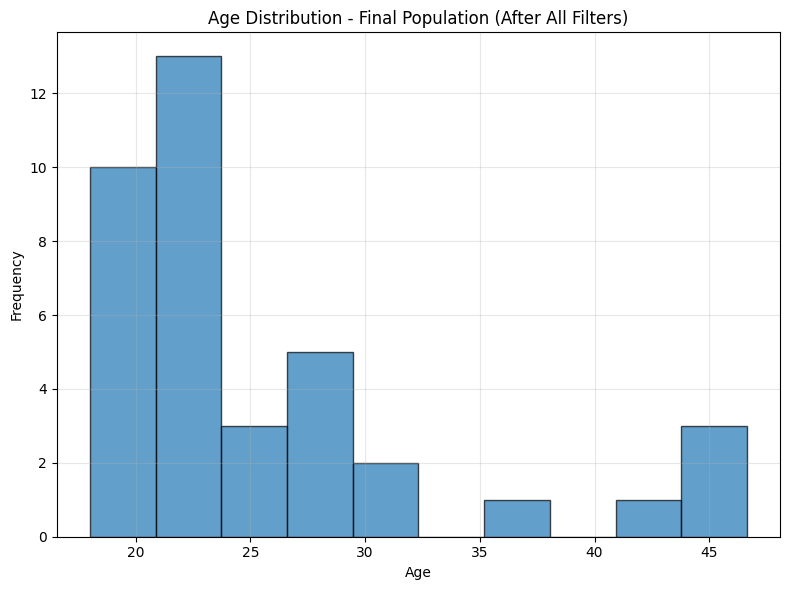


=== DATAFRAMES READY FOR NEXT STEPS ===
main_df_final: 38 subjects (filtered main population)
sp_df: 14 subjects (SP population for later use)


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Set up paths relative to the multiecho-pilot directory
# This will work across different operating systems and user setups
project_root = Path.cwd()
while project_root.name != 'multiecho-pilot' and project_root.parent != project_root:
    project_root = project_root.parent
    
if project_root.name != 'multiecho-pilot':
    raise ValueError("Could not find 'multiecho-pilot' directory. Please run this script from within the project directory.")

# Define file paths relative to project root
demographics_path = project_root / 'code' / 'multiecho-pilot_Demographics.xlsx'
outlier_path = project_root / 'derivatives' / 'Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv'

# Read the demographics Excel file
print(f"Loading demographics from: {demographics_path}")
df = pd.read_excel(demographics_path)

# Separate data based on spSubs column
sp_df = df[df['spSubs'] == 1].copy()
main_df = df[df['spSubs'] == 0].copy()

print(f"\nInitial separation:")
print(f"- SP subjects (spSubs=1): {len(sp_df)} subjects")
print(f"- Main subjects (spSubs=0): {len(main_df)} subjects")

# Print initial statistics for main population
print("\n=== MAIN POPULATION (spSubs=0) - ALL SUBJECTS ===")
print(f"Total N: {len(main_df)}")  # Since OpenNeuro is binary and all are 1
print(f"Age: Mean = {main_df['Age'].mean():.1f}, SD = {main_df['Age'].std():.1f}")

# Filter 1: Remove subjects with SixRuns = 0
main_df_filtered = main_df[main_df['SixRuns'] != 0].copy()
subjects_removed_sixruns = len(main_df) - len(main_df_filtered)

print("\n=== AFTER REMOVING SixRuns=0 ===")
print(f"Removed {subjects_removed_sixruns} subjects")
print(f"Total N: {len(main_df_filtered)}")
print(f"Age: Mean = {main_df_filtered['Age'].mean():.1f}, SD = {main_df_filtered['Age'].std():.1f}")

# Filter 2: Remove subjects with motion outliers
print("\n=== MOTION OUTLIER ANALYSIS ===")
print(f"Loading outlier data from: {outlier_path}")

# Read the outlier TSV file
outlier_df = pd.read_csv(outlier_path, sep='\t')
print(f"Successfully loaded {len(outlier_df)} rows")

# Find outlier runs (where outlier_acq_Custom1 is True)
outlier_runs = outlier_df[outlier_df['outlier_acq_Custom1'] == True]
print(f"\nTotal outlier runs identified: {len(outlier_runs)}")

if len(outlier_runs) > 0:
    # Extract unique subject IDs from outlier runs
    outlier_subjects_raw = outlier_runs['Sub'].unique()
    print(f"Unique subjects with outlier runs: {len(outlier_subjects_raw)}")
    
    # Convert outlier subject IDs to match demographics format
    # Remove 'sub-' prefix but keep the full ID (including 'sp' suffix if present)
    outlier_subjects_clean = []
    for sub in outlier_subjects_raw:
        if sub.startswith('sub-'):
            clean_id = sub.replace('sub-', '')
            outlier_subjects_clean.append(clean_id)
    
    print(f"Outlier subjects (cleaned IDs): {sorted(outlier_subjects_clean)}")
    
    # Since demographics Subject column can be either numeric or string with 'sp' suffix,
    # we need to convert to string for comparison
    main_df_filtered['Subject_str'] = main_df_filtered['Subject'].astype(str)
    
    # Remove subjects with outlier runs from main_df_filtered
    main_df_final = main_df_filtered[~main_df_filtered['Subject_str'].isin(outlier_subjects_clean)].copy()
    
    # Drop the temporary string column
    main_df_final = main_df_final.drop(columns=['Subject_str'])
    subjects_removed_outliers = len(main_df_filtered) - len(main_df_final)
    print(f"Removed {subjects_removed_outliers} subjects due to motion outliers")
else:
    print("No outlier runs found.")
    main_df_final = main_df_filtered.copy()
    subjects_removed_outliers = 0

# Print final statistics
print("\n=== FINAL POPULATION (After All Filters) ===")
print(f"Total N: {len(main_df_final)}")
print(f"Age: Mean = {main_df_final['Age'].mean():.1f}, SD = {main_df_final['Age'].std():.1f}")
if 'Gender' in main_df_final.columns:
    gender_counts = main_df_final['Gender'].value_counts()
    print(f"Gender breakdown:")
    if 'Male' in gender_counts:
        print(f"- Males: {gender_counts['Male']}")
    if 'Female' in gender_counts:
        print(f"- Females: {gender_counts['Female']}")
    if 'Non-binary' in gender_counts:
        print(f"- Non-binary: {gender_counts['Non-binary']}")
    
    # Handle any other unexpected gender categories
    for gender_type, count in gender_counts.items():
        if gender_type not in ['Male', 'Female', 'Non-binary']:
            print(f"- {gender_type}: {count} (Other/Unspecified)")
else:
    print("Warning: 'Gender' column not found in the final dataset. Cannot provide gender breakdown.")

# Print breakdown by Headcoil
print(f"\nBreakdown by Headcoil:")
headcoil_counts = main_df_final['Headcoil'].value_counts().sort_index()
for headcoil, count in headcoil_counts.items():
    print(f"- Headcoil {headcoil}: N = {count}")

# Summary of filtering
print("\n=== FILTERING SUMMARY ===")
print(f"Initial main subjects: {len(main_df)}")
print(f"Removed due to SixRuns=0: {subjects_removed_sixruns}")
print(f"Removed due to motion outliers: {subjects_removed_outliers}")
print(f"Final sample size: {len(main_df_final)}")

# Create histogram of age for final filtered population
plt.figure(figsize=(8, 6))
plt.hist(main_df_final['Age'], bins=10, edgecolor='black', alpha=0.7)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age Distribution - Final Population (After All Filters)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Store the key dataframes for use in subsequent kernels
print("\n=== DATAFRAMES READY FOR NEXT STEPS ===")
print(f"main_df_final: {len(main_df_final)} subjects (filtered main population)")
print(f"sp_df: {len(sp_df)} subjects (SP population for later use)")

# Spatial Smoothness Analysis (Fig. 3)
This kernel analyzes spatial smoothness in fMRI data before and after preprocessing by:
1. **Loading smoothness measurements** from two CSV files (pre- and post-smoothing)
2. **Filtering subjects** to include only those from the main study population with complete data
3. **Running Linear Mixed Effects models** to test effects of:
   - Headcoil type (20 vs 64 channel)
   - Multiband acceleration factor (mb1, mb3, mb6)
   - Multi-echo acquisition (me1, me4)
   - All interactions between these factors
4. **Generating visualizations** in a 2×2 subplot layout showing:
   - Top row: Pre-smoothing spatial smoothness
   - Bottom row: Post-smoothing spatial smoothness
   - Columns separated by headcoil type
5. **Saving outputs** to `derivatives/plots/` including:
   - APA-formatted ANOVA tables
   - Complete subject lists
   - Combined bar plot figure

The analysis quantifies how acquisition parameters affect spatial smoothness and the impact of preprocessing.

SMOOTHNESS ANALYSIS PIPELINE - PRE AND POST SMOOTHING
Filtering to 38 subjects from main population
Pre-smoothing file: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/code/smoothness-all-zero.csv
Post-smoothing file: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/code/smoothness-all.csv
Output directory: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/plots

PART 1: PRE-SMOOTHING DATA ANALYSIS

Pre-smoothing complete subjects: 38
  - 20-channel headcoil: 16
  - 64-channel headcoil: 22
Complete subjects table saved to '/Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/plots/complete_subjects_smoothness_pre_with_headcoil.csv'

Running LME analysis for pre-smoothing data
Observations: 228, Subjects: 38
Linear mixed model fit by REML [’lmerMod’]
Formula: smoothness~headcoil*mb*me+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 228	 Groups: {'subject': 38.0}

Log-likelihood: 266.879 	 AIC: -505.759

Random

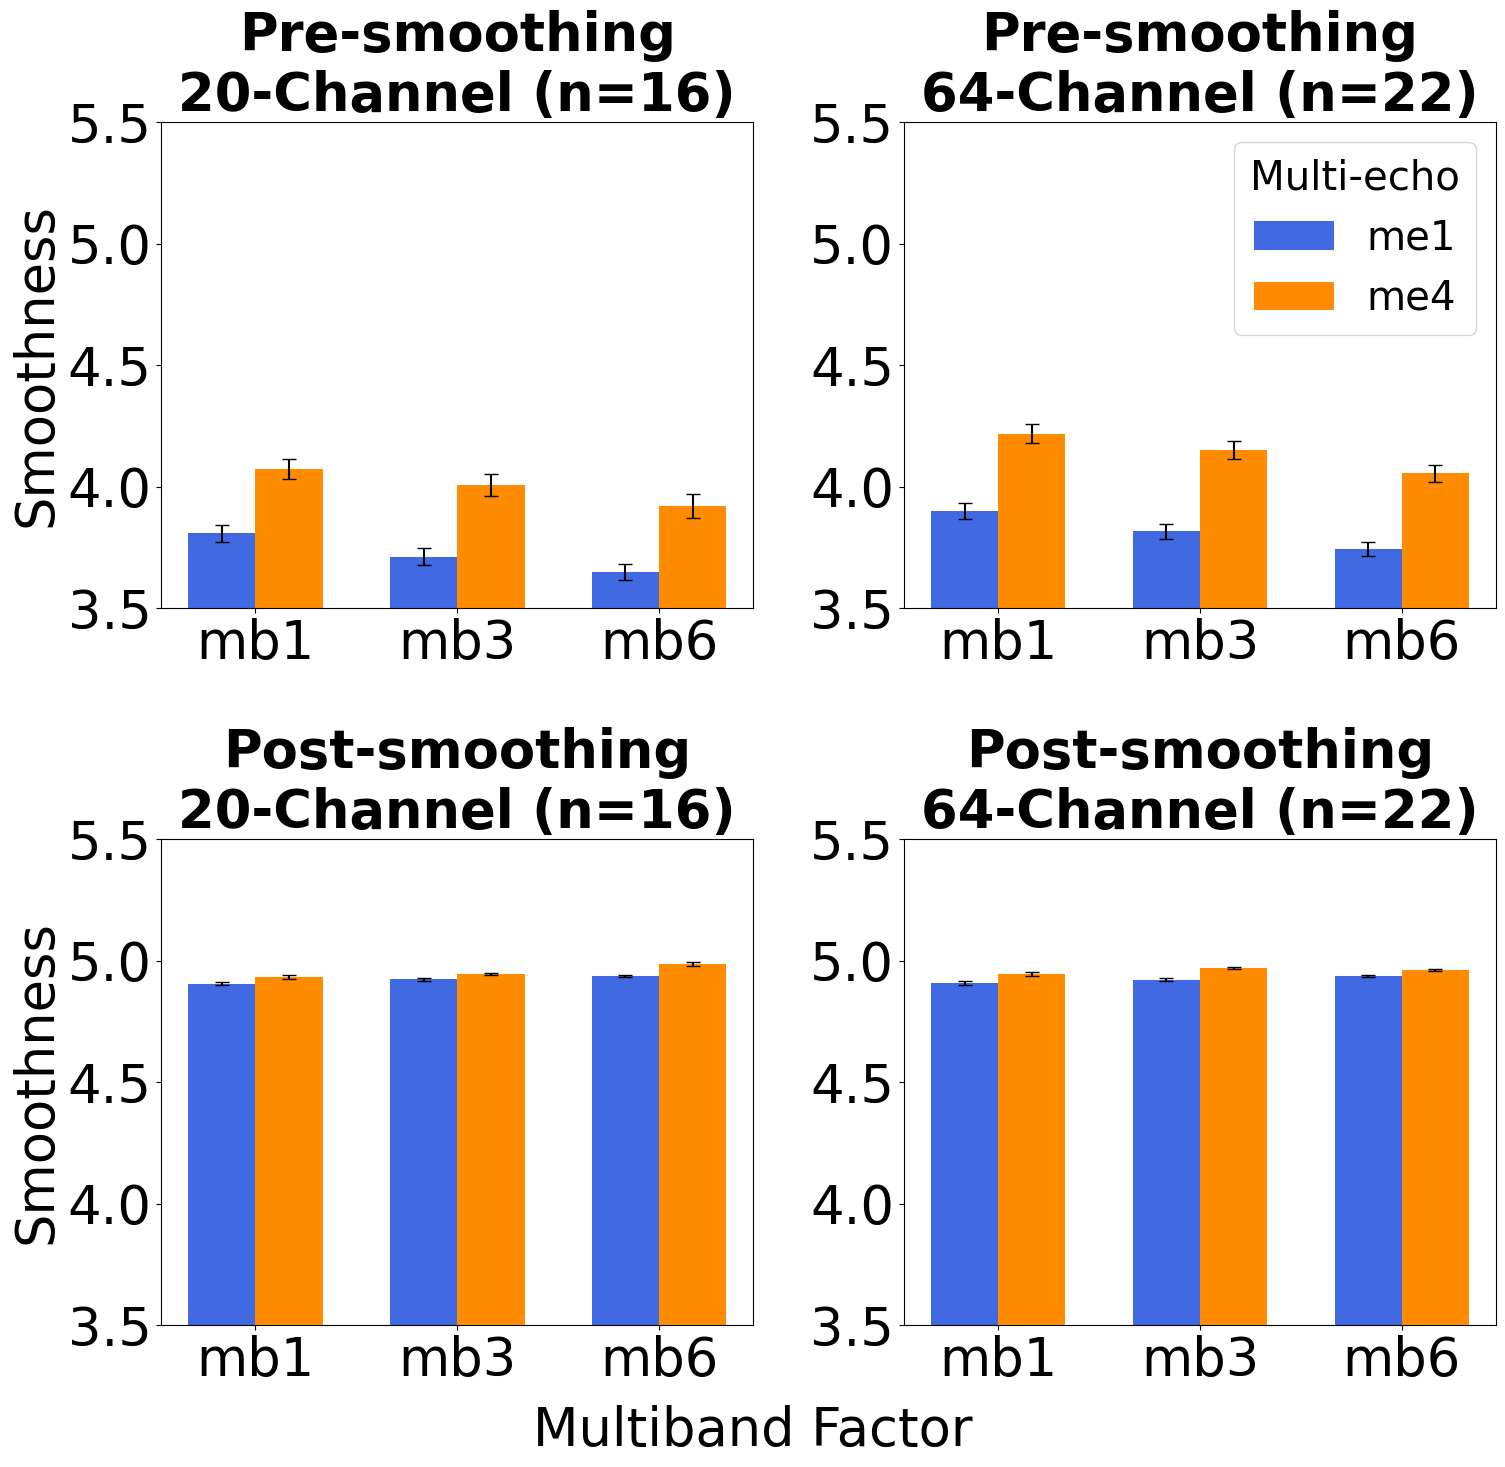


ANALYSIS COMPLETE - SUMMARY

Pre-smoothing data:
  Complete subjects: 38
  - 20-channel: 16
  - 64-channel: 22

Post-smoothing data:
  Complete subjects: 38
  - 20-channel: 16
  - 64-channel: 22

Files generated in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/plots:
  - complete_subjects_smoothness_pre_with_headcoil.csv
  - complete_subjects_smoothness_post_with_headcoil.csv
  - smoothness_pre_lme_anova_complete_subjects.csv
  - smoothness_post_lme_anova_complete_subjects.csv
  - smoothness_combined_bar_plot.png


In [9]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import warnings
from pymer4.models import Lmer
from pathlib import Path

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")

print("=" * 80)
print("SMOOTHNESS ANALYSIS PIPELINE - PRE AND POST SMOOTHING")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Define paths to both CSV files
demographics_path = project_root / 'code' / 'multiecho-pilot_Demographics.xlsx'
outlier_path = project_root / 'derivatives' / 'Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv'

csv_path_pre = project_root / 'code' / 'smoothness-all-zero.csv'
csv_path_post = project_root / 'code' / 'smoothness-all.csv'

# Create output directory if it doesn't exist
output_dir = project_root / 'derivatives' / 'plots'
output_dir.mkdir(parents=True, exist_ok=True)

# Get valid subjects and headcoil information from main_df_final
valid_subjects = main_df_final['Subject'].astype(str).tolist()
headcoil_mapping = dict(zip(main_df_final['Subject'].astype(str), 
                           main_df_final['Headcoil'].astype(str)))

print(f"Filtering to {len(valid_subjects)} subjects from main population")

# Output file names
complete_subjects_file_pre = output_dir / 'complete_subjects_smoothness_pre_with_headcoil.csv'
complete_subjects_file_post = output_dir / 'complete_subjects_smoothness_post_with_headcoil.csv'
anova_table_file_pre = output_dir / 'smoothness_pre_lme_anova_complete_subjects.csv'
anova_table_file_post = output_dir / 'smoothness_post_lme_anova_complete_subjects.csv'
combined_plot_file = output_dir / 'smoothness_combined_bar_plot.png'

print(f"Pre-smoothing file: {csv_path_pre}")
print(f"Post-smoothing file: {csv_path_post}")
print(f"Output directory: {output_dir}")

# ============================================================================
# SHARED FUNCTIONS
# ============================================================================

def load_and_process_data(csv_path, valid_subjects, headcoil_mapping):
    """Load and process the CSV file with shift-up correction"""
    try:
        data = pd.read_csv(csv_path)
        
        # Rename columns for clarity
        data = data.rename(columns={
            data.columns[0]: 'path',
            'Unnamed: 3': 'smoothness'
        })
        
        # Apply shift up procedure to align smoothness values with correct acquisition
        data['file_path'] = data['path'].shift(1)
        
        # Filter rows with non-null smoothness and file_path
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        
        # Extract subject, mb, and me from file_path
        def parse_path(path):
            try:
                if not isinstance(path, str):
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]  # e.g., mb1
                    me = acq[3:]  # e.g., me1
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception as e:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)
        
        # Filter to only include valid subjects from main_df_final
        data = data[data['subject'].isin(valid_subjects)]
        
        # Assign headcoil based on mapping from main_df_final
        data['headcoil'] = data['subject'].map(headcoil_mapping)
        
        # Select relevant columns
        data = data[['subject', 'headcoil', 'mb', 'me', 'smoothness']]
        
        # Convert to categorical
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        
        # Filter out invalid rows
        data = data.dropna(subset=['subject', 'mb', 'me', 'smoothness'])
        
        return data
        
    except FileNotFoundError:
        print(f"Error: File not found at {csv_path}")
        return None
    except Exception as e:
        print(f"Error processing data: {str(e)}")
        return None

def identify_complete_subjects(data):
    """Identify subjects with complete data across all 6 acquisitions"""
    # Create a combined mb_me column for pivoting
    data['mb_me'] = data['mb'].astype(str) + data['me'].astype(str)
    
    # Pivot the data to create a table with subjects as rows and mb_me combinations as columns
    pivot_table = data.pivot_table(
        values='smoothness',
        index='subject',
        columns='mb_me',
        aggfunc='mean'  # In case of duplicates, take the mean
    )
    
    # Ensure all expected mb_me combinations are present as columns
    expected_columns = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']
    pivot_table = pivot_table.reindex(columns=expected_columns)
    
    # Identify subjects with no NaN values across all mb_me columns
    complete_subjects = pivot_table.dropna()
    
    # Sort the index (subjects) for consistency
    complete_subjects = complete_subjects.sort_index()
    
    # Round smoothness values to 3 decimal places for readability
    complete_subjects = complete_subjects.round(3)
    
    # Get headcoil information for complete subjects
    headcoil_data = data[['subject', 'headcoil']].drop_duplicates().set_index('subject')
    complete_headcoil = headcoil_data.loc[complete_subjects.index].astype(str)
    
    # Add headcoil as a column to the complete subjects table
    complete_subjects = complete_subjects.reset_index().merge(
        complete_headcoil[['headcoil']].reset_index(),
        on='subject',
        how='left'
    ).set_index('subject')
    
    # Reorder columns to have headcoil first
    cols = ['headcoil'] + expected_columns
    complete_subjects = complete_subjects[cols]
    
    return complete_subjects

def run_lme_analysis(data_complete, label):
    """Run Linear Mixed Effects analysis and return results"""
    print(f"\nRunning LME analysis for {label} data")
    print(f"Observations: {len(data_complete)}, Subjects: {data_complete['subject'].nunique()}")
    
    # Prepare data for LME model with sum-to-zero contrasts
    data_model = data_complete.copy()
    data_model['headcoil'] = data_model['headcoil'].cat.codes - 0.5  # 20=-0.5, 64=0.5
    
    # Fit the LME model
    model = Lmer('smoothness ~ headcoil * mb * me + (1 | subject)', data=data_model)
    model.fit()
    
    # Get ANOVA table
    anova_table = model.anova()
    
    # Define effect names and numerator df for APA table
    effect_map = {
        'headcoil': 'Head Coil',
        'mb': 'Multiband',
        'me': 'Multi-echo',
        'headcoil:mb': 'Head Coil × Multiband',
        'headcoil:me': 'Head Coil × Multi-echo',
        'mb:me': 'Multiband × Multi-echo',
        'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
    }
    
    df_dict = {
        'Head Coil': 1,
        'Multiband': 2,
        'Multi-echo': 1,
        'Head Coil × Multiband': 2,
        'Head Coil × Multi-echo': 1,
        'Multiband × Multi-echo': 2,
        'Head Coil × Multiband × Multi-echo': 2
    }
    
    # Build APA table
    apa_data = []
    for effect in anova_table.index:
        if effect in ['(Intercept)', 'Residuals']:
            continue
        effect_name = effect_map.get(effect, effect)
        apa_data.append({
            'Effect': effect_name,
            'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
            'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
            'Num df': df_dict.get(effect_name, np.nan),
            'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
            'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
            'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
            'Partial η²': np.nan  # Computed below
        })
    
    # Compute partial eta-squared
    try:
        residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
    except (KeyError, IndexError):
        residual_var = model.ranef_var.iloc[1]['Var']
    
    n_obs = len(data_model)
    n_fixed = sum(df_dict.values())
    n_subj = data_model['subject'].nunique()
    ss_residual = residual_var * (n_obs - n_fixed - n_subj)
    
    for i, row in enumerate(apa_data):
        ss_effect = row['Sum Sq']
        if pd.notna(ss_effect):
            apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)
    
    # Create APA table
    apa_table = pd.DataFrame(apa_data)
    apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
    apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
    apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
    apa_table['Den df'] = apa_table['Den df'].round(2)
    apa_table['F'] = apa_table['F'].round(2)
    apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
    apa_table['Partial η²'] = apa_table['Partial η²'].round(3)
    
    return apa_table

def process_data_for_plotting(data, value_column='smoothness'):
    """Calculate mean and standard error by multiband, multi-echo, and headcoil"""
    if data is None or data.empty:
        return pd.DataFrame()
    
    data = data.dropna(subset=['mb', 'me', 'headcoil', value_column])
    
    if data.empty:
        return pd.DataFrame()
    
    agg_data = data.groupby(['mb', 'me', 'headcoil'], observed=True).agg({
        value_column: 'mean',
        'subject': 'nunique'
    }).reset_index()
    
    std_error = data.groupby(['mb', 'me', 'headcoil'], observed=True)[value_column].apply(
        lambda x: x.std() / np.sqrt(len(x))
    ).reset_index()
    std_error.columns = ['mb', 'me', 'headcoil', 'se']
    
    result = pd.merge(agg_data, std_error, on=['mb', 'me', 'headcoil'])
    result.columns = ['mb', 'me', 'headcoil', value_column, 'n_subjects', 'se']
    
    return result

# ============================================================================
# PART 1: PROCESS PRE-SMOOTHING DATA
# ============================================================================

print("\n" + "=" * 80)
print("PART 1: PRE-SMOOTHING DATA ANALYSIS")
print("=" * 80)

# Load and process pre-smoothing data
data_pre = load_and_process_data(csv_path_pre, valid_subjects, headcoil_mapping)

if data_pre is None:
    raise Exception("Failed to load pre-smoothing data. Stopping execution.")

# Identify complete subjects
complete_subjects_table_pre = identify_complete_subjects(data_pre)
total_n_pre = len(complete_subjects_table_pre)
headcoil_counts_pre = complete_subjects_table_pre['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nPre-smoothing complete subjects: {total_n_pre}")
print(f"  - 20-channel headcoil: {headcoil_counts_pre['20']}")
print(f"  - 64-channel headcoil: {headcoil_counts_pre['64']}")

# Save complete subjects table
complete_subjects_table_pre.to_csv(complete_subjects_file_pre)
print(f"Complete subjects table saved to '{complete_subjects_file_pre}'")

# Filter data to complete subjects only
complete_subject_list_pre = [str(subj) for subj in complete_subjects_table_pre.index.tolist()]
data_complete_pre = data_pre[data_pre['subject'].isin(complete_subject_list_pre)]

# Run LME analysis
apa_table_pre = run_lme_analysis(data_complete_pre, "pre-smoothing")
print("\nAPA-Style ANOVA Table for Pre-smoothing Data:")
print(apa_table_pre.to_string(index=False))
apa_table_pre.to_csv(anova_table_file_pre, index=False)

# ============================================================================
# PART 2: PROCESS POST-SMOOTHING DATA
# ============================================================================

print("\n" + "=" * 80)
print("PART 2: POST-SMOOTHING DATA ANALYSIS")
print("=" * 80)

# Load and process post-smoothing data
data_post = load_and_process_data(csv_path_post, valid_subjects, headcoil_mapping)

if data_post is None:
    raise Exception("Failed to load post-smoothing data. Stopping execution.")

# Identify complete subjects
complete_subjects_table_post = identify_complete_subjects(data_post)
total_n_post = len(complete_subjects_table_post)
headcoil_counts_post = complete_subjects_table_post['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nPost-smoothing complete subjects: {total_n_post}")
print(f"  - 20-channel headcoil: {headcoil_counts_post['20']}")
print(f"  - 64-channel headcoil: {headcoil_counts_post['64']}")

# Save complete subjects table
complete_subjects_table_post.to_csv(complete_subjects_file_post)
print(f"Complete subjects table saved to '{complete_subjects_file_post}'")

# Filter data to complete subjects only
complete_subject_list_post = [str(subj) for subj in complete_subjects_table_post.index.tolist()]
data_complete_post = data_post[data_post['subject'].isin(complete_subject_list_post)]

# Run LME analysis
apa_table_post = run_lme_analysis(data_complete_post, "post-smoothing")
print("\nAPA-Style ANOVA Table for Post-smoothing Data:")
print(apa_table_post.to_string(index=False))
apa_table_post.to_csv(anova_table_file_post, index=False)

# ============================================================================
# PART 3: COMBINED VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("PART 3: GENERATING COMBINED BAR PLOTS")
print("=" * 80)

# Process data for plotting
smoothness_processed_pre = process_data_for_plotting(data_complete_pre, 'smoothness')
smoothness_processed_post = process_data_for_plotting(data_complete_post, 'smoothness')

# Get n_subjects per coil for both datasets
n_subjects_per_coil_pre = data_complete_pre.groupby('headcoil', observed=True)['subject'].nunique().to_dict()
n_subjects_per_coil_post = data_complete_post.groupby('headcoil', observed=True)['subject'].nunique().to_dict()

# Create combined 2x2 plot
plt.rcParams.update({'font.size': 38})  # Match TSNR formatting
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

width = 0.4  # Match TSNR bar width
x1 = [0, 1.2, 2.4]
x2 = [x + width for x in x1]
me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
mb_levels = ['mb1', 'mb3', 'mb6']

# Set consistent y-axis limits for all subplots
y_limits = (3.5, 5.5)

# Function to plot data in a subplot
def plot_smoothness_data(ax, data_processed, n_subjects_per_coil, headcoil, title_prefix):
    """Plot smoothness data for a specific headcoil"""
    
    coil_data = data_processed[data_processed['headcoil'] == headcoil]
    
    if coil_data.empty:
        ax.set_title(f"{title_prefix}\n{headcoil}-Channel (n=0)", fontsize=20, fontweight='bold')
        ax.set_ylim(y_limits)
        return
    
    me1_data = coil_data[coil_data['me'] == 'me1']
    me4_data = coil_data[coil_data['me'] == 'me4']
    
    me1_means = me1_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
    me1_errors = me1_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
    me4_means = me4_data.set_index('mb')['smoothness'].reindex(mb_levels).fillna(0)
    me4_errors = me4_data.set_index('mb')['se'].reindex(mb_levels).fillna(0)
    
    ax.bar(x1, me1_means, width, color=me_colors['me1'], label='me1', 
           yerr=me1_errors, capsize=5)
    ax.bar(x2, me4_means, width, color=me_colors['me4'], label='me4', 
           yerr=me4_errors, capsize=5)
    
    ax.set_xticks([width/2, 1.2+width/2, 2.4+width/2])
    ax.set_xticklabels(mb_levels, fontsize=38)
    ax.tick_params(axis='both', which='major', labelsize=38)
    
    n_subjects = n_subjects_per_coil.get(headcoil, 0)
    ax.set_title(f"{title_prefix}\n{headcoil}-Channel (n={n_subjects})", fontsize=38, fontweight='bold')
    ax.set_ylim(y_limits)

# Plot data in 2x2 layout
# Top row: Pre-smoothing
plot_smoothness_data(axes[0, 0], smoothness_processed_pre, n_subjects_per_coil_pre, '20', 'Pre-smoothing')
plot_smoothness_data(axes[0, 1], smoothness_processed_pre, n_subjects_per_coil_pre, '64', 'Pre-smoothing')

# Bottom row: Post-smoothing
plot_smoothness_data(axes[1, 0], smoothness_processed_post, n_subjects_per_coil_post, '20', 'Post-smoothing')
plot_smoothness_data(axes[1, 1], smoothness_processed_post, n_subjects_per_coil_post, '64', 'Post-smoothing')

# Add labels
axes[0, 0].set_ylabel('Smoothness', fontsize=38)
axes[1, 0].set_ylabel('Smoothness', fontsize=38)

# Add legend to the top right subplot
axes[0, 1].legend(title='Multi-echo', fontsize=29, title_fontsize=29, 
                  loc='upper right')

# Add shared x-label for entire figure
fig.supxlabel('Multiband Factor', fontsize=38, y=0.06)

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(combined_plot_file, dpi=300, bbox_inches='tight')
print(f"Combined plot saved to '{combined_plot_file}'")

plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)
print(f"\nPre-smoothing data:")
print(f"  Complete subjects: {total_n_pre}")
print(f"  - 20-channel: {headcoil_counts_pre['20']}")
print(f"  - 64-channel: {headcoil_counts_pre['64']}")
print(f"\nPost-smoothing data:")
print(f"  Complete subjects: {total_n_post}")
print(f"  - 20-channel: {headcoil_counts_post['20']}")
print(f"  - 64-channel: {headcoil_counts_post['64']}")
print(f"\nFiles generated in {output_dir}:")
print(f"  - {complete_subjects_file_pre.name}")
print(f"  - {complete_subjects_file_post.name}")
print(f"  - {anova_table_file_pre.name}")
print(f"  - {anova_table_file_post.name}")
print(f"  - {combined_plot_file.name}")
print("=" * 80)

# Temporal Signal-to-Noise Ratio (TSNR) Analysis (Fig. 4)
This kernel analyzes TSNR in fMRI data with spatial smoothness as a covariate by:
1. **Loading and merging datasets** from TSNR measurements and smoothness data
2. **Filtering subjects** to include only those from the main study population with complete data in both metrics
3. **Running Linear Mixed Effects models** testing the effects of:
   - Headcoil type (20 vs 64 channel)
   - Multiband acceleration factor (mb1, mb3, mb6)
   - Multi-echo acquisition (me1, me4)
   - Spatial smoothness as a continuous covariate
   - All interactions between acquisition parameters
4. **Generating visualizations** showing TSNR median values:
   - Bar plots separated by headcoil type
   - Error bars representing standard error
   - Legend indicating multi-echo conditions
5. **Saving outputs** to `derivatives/plots/` including:
   - Complete APA-formatted ANOVA table with effect sizes
   - List of subjects with complete data
   - Bar plot figure comparing acquisition parameters

The analysis quantifies how acquisition parameters and spatial smoothness jointly influence temporal signal quality.

TSNR ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE
Filtering to 38 subjects from main population

PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS
Complete TSNR subjects: 38
Complete smoothness subjects: 38

Common complete subjects: 38

Final dataset: 38 subjects, 228 observations
  20-channel: 16
  64-channel: 22

Complete subjects table saved to '/Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/plots/complete_subjects_tsnr_common_with_headcoil.csv'

PART 2: LINEAR MIXED EFFECTS ANALYSIS
Linear mixed model fit by REML [’lmerMod’]
Formula: tsnrMedian~headcoil_encoded*mb*me+smoothness+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 228	 Groups: {'subject': 38.0}

Log-likelihood: -582.411 	 AIC: 1194.821

Random effects:

                 Name    Var    Std
subject   (Intercept)  9.767  3.125
Residual               7.918  2.814

No random effect correlations specified

Fixed effects:

SS Type III Analysis of Variance Table with Satterthwaite ap

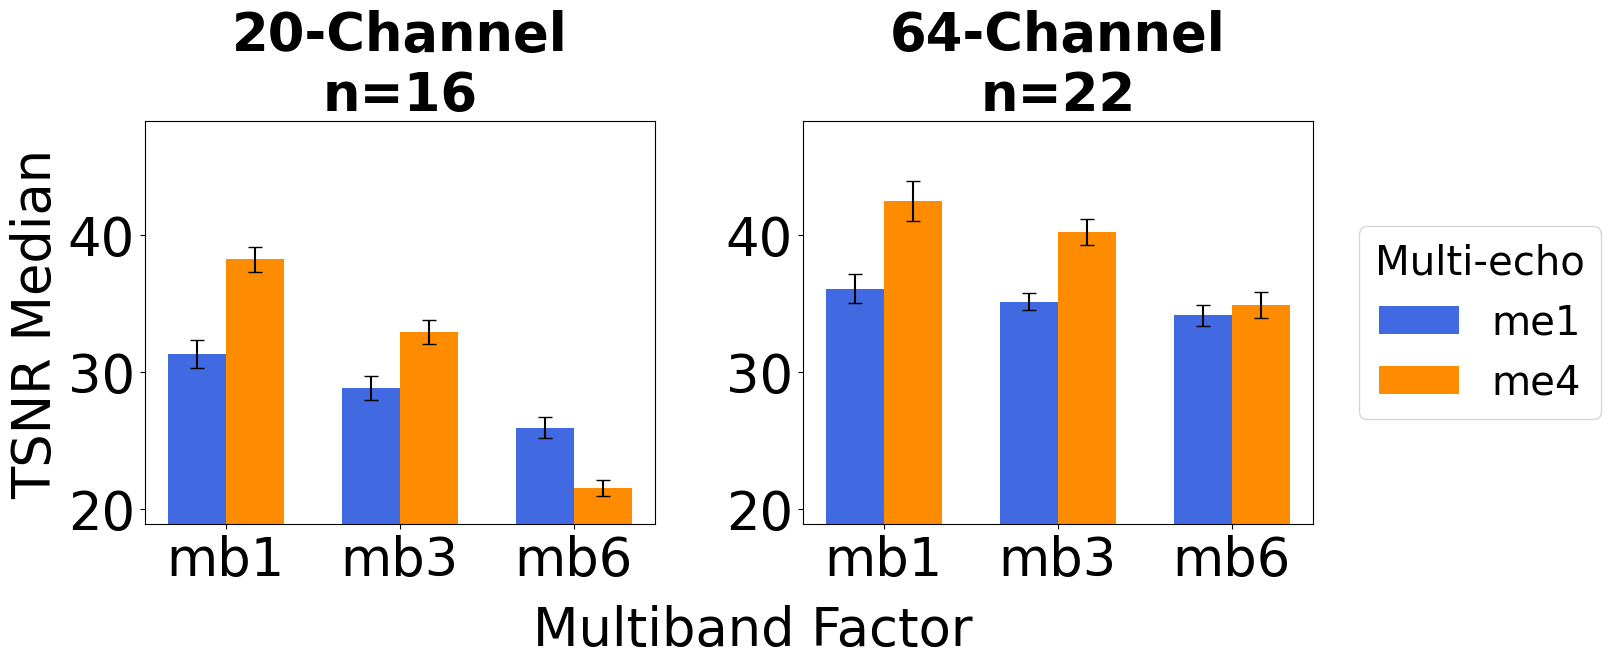


ANALYSIS COMPLETE - SUMMARY
Common complete subjects: 38
  - 20-channel: 16
  - 64-channel: 22

Files generated in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/plots:
  - complete_subjects_tsnr_common_with_headcoil.csv
  - tsnr_lme_anova_with_smoothness.csv
  - tsnr_bar_plot_median.png


In [12]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import warnings
from pymer4.models import Lmer
from pathlib import Path

# Suppress warnings
warnings.filterwarnings("ignore")

print("=" * 80)
print("TSNR ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Define paths relative to project root
tsnr_path = project_root / 'code' / 'combined_tsnr_coil_output.csv'
smoothness_path = project_root / 'code' / 'smoothness-all.csv'

# Create output directory
output_dir = project_root / 'derivatives' / 'plots'
output_dir.mkdir(parents=True, exist_ok=True)

# Get valid subjects and headcoil information from main_df_final
valid_subjects = main_df_final['Subject'].astype(str).tolist()
headcoil_mapping = dict(zip(main_df_final['Subject'].astype(str), 
                           main_df_final['Headcoil'].astype(str)))

print(f"Filtering to {len(valid_subjects)} subjects from main population")

# Output file names
complete_subjects_file = output_dir / 'complete_subjects_tsnr_common_with_headcoil.csv'
anova_table_file = output_dir / 'tsnr_lme_anova_with_smoothness.csv'
tsnr_plot_file = output_dir / 'tsnr_bar_plot_median.png'

# ============================================================================
# DATA PROCESSING FUNCTIONS
# ============================================================================

def load_and_process_tsnr_data(csv_path, valid_subjects, headcoil_mapping):
    """Load and process TSNR data"""
    try:
        data = pd.read_csv(csv_path)
        
        # Ensure string types
        data['Subject'] = data['Subject'].astype(str)
        data['AcquisitionType'] = data['AcquisitionType'].astype(str)
        
        # Filter to valid subjects only
        data = data[data['Subject'].isin(valid_subjects)]
        
        # Extract mb and me from AcquisitionType
        data['mb'] = data['AcquisitionType'].str.extract(r'(mb\d)')
        data['me'] = data['AcquisitionType'].str.extract(r'(me\d)')
        
        # Add headcoil from mapping
        data['headcoil'] = data['Subject'].map(headcoil_mapping)
        
        # Rename for consistency
        data = data.rename(columns={'Subject': 'subject'})
        
        # Create combined mb_me label
        data['mb_me'] = data['mb'].astype(str) + data['me'].astype(str)
        
        # Select relevant columns
        required_cols = ['subject', 'headcoil', 'mb', 'me', 'mb_me', 'tsnrMean', 'tsnrMedian']
        if not all(col in data.columns for col in required_cols):
            missing = [col for col in required_cols if col not in data.columns]
            raise ValueError(f"Missing required columns: {missing}")
            
        data = data[required_cols]
        
        # Convert to categorical
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        
        # Drop NaN values
        data = data.dropna()
        
        return data

    except Exception as e:
        print(f"Error processing TSNR data: {str(e)}")
        return None

def load_and_process_smoothness_data(csv_path, valid_subjects, headcoil_mapping):
    """Load and process smoothness data with shift correction"""
    try:
        data = pd.read_csv(csv_path)
        
        # Rename columns
        data = data.rename(columns={
            data.columns[0]: 'path',
            'Unnamed: 3': 'smoothness'
        })
        
        # Apply shift correction
        data['file_path'] = data['path'].shift(1)
        
        # Filter valid rows
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        
        # Extract subject, mb, me
        data['subject'] = data['file_path'].str.extract(r'sub-(\d+)')
        data['acq'] = data['file_path'].str.extract(r'acq-(mb\dme\d)')
        data['mb'] = data['acq'].str[:3]
        data['me'] = data['acq'].str[3:]
        
        # Filter to valid subjects
        data = data[data['subject'].isin(valid_subjects)]
        
        # Add headcoil from mapping
        data['headcoil'] = data['subject'].map(headcoil_mapping)
        
        # Create combined mb_me label
        data['mb_me'] = data['mb'].astype(str) + data['me'].astype(str)
        
        # Select relevant columns
        data = data[['subject', 'headcoil', 'mb', 'me', 'mb_me', 'smoothness']]
        
        # Convert to categorical
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        
        # Drop NaN values
        data = data.dropna()
        
        return data
        
    except Exception as e:
        print(f"Error processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects(data, value_col):
    """Identify subjects with complete data across all 6 acquisitions"""
    pivot = data.pivot_table(
        values=value_col,
        index='subject',
        columns='mb_me',
        aggfunc='first'
    )
    
    expected_cols = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']
    pivot = pivot.reindex(columns=expected_cols)
    
    complete_subjects = pivot.dropna().index.tolist()
    return complete_subjects

# ============================================================================
# PART 1: LOAD DATA AND IDENTIFY COMMON COMPLETE SUBJECTS
# ============================================================================

print("\n" + "=" * 80)
print("PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS")
print("=" * 80)

# Load TSNR data
tsnr_data = load_and_process_tsnr_data(tsnr_path, valid_subjects, headcoil_mapping)
if tsnr_data is None:
    raise Exception("Failed to load TSNR data")

# Load smoothness data
smoothness_data = load_and_process_smoothness_data(smoothness_path, valid_subjects, headcoil_mapping)
if smoothness_data is None:
    raise Exception("Failed to load smoothness data")

# Identify complete subjects in each dataset
complete_tsnr = identify_complete_subjects(tsnr_data, 'tsnrMedian')
complete_smoothness = identify_complete_subjects(smoothness_data, 'smoothness')

print(f"Complete TSNR subjects: {len(complete_tsnr)}")
print(f"Complete smoothness subjects: {len(complete_smoothness)}")

# Find common complete subjects
common_complete = sorted(list(set(complete_tsnr) & set(complete_smoothness)))
print(f"\nCommon complete subjects: {len(common_complete)}")

if not common_complete:
    raise Exception("No common complete subjects found")

# Filter data to common complete subjects
tsnr_filtered = tsnr_data[tsnr_data['subject'].isin(common_complete)].copy()
smoothness_filtered = smoothness_data[smoothness_data['subject'].isin(common_complete)].copy()

# Merge datasets for analysis
merged_data = pd.merge(
    tsnr_filtered[['subject', 'headcoil', 'mb', 'me', 'tsnrMedian']],
    smoothness_filtered[['subject', 'mb', 'me', 'smoothness']],
    on=['subject', 'mb', 'me'],
    how='inner'
).dropna()

# Summary statistics
total_n = merged_data['subject'].nunique()
headcoil_counts = merged_data[['subject', 'headcoil']].drop_duplicates()['headcoil'].value_counts()

print(f"\nFinal dataset: {total_n} subjects, {len(merged_data)} observations")
print(f"  20-channel: {headcoil_counts.get('20', 0)}")
print(f"  64-channel: {headcoil_counts.get('64', 0)}")

# Save complete subjects table
tsnr_complete_table = tsnr_filtered.pivot_table(
    values='tsnrMean',
    index='subject',
    columns='mb_me',
    aggfunc='mean'
).round(3)

# Add headcoil info
headcoil_info = tsnr_filtered[['subject', 'headcoil']].drop_duplicates().set_index('subject')
tsnr_complete_table = pd.concat([headcoil_info, tsnr_complete_table], axis=1)
tsnr_complete_table.to_csv(complete_subjects_file)
print(f"\nComplete subjects table saved to '{complete_subjects_file}'")

# ============================================================================
# PART 2: LINEAR MIXED EFFECTS ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("PART 2: LINEAR MIXED EFFECTS ANALYSIS")
print("=" * 80)

# Prepare data for LME
model_data = merged_data.copy()
model_data['headcoil_encoded'] = model_data['headcoil'].cat.codes - 0.5

# Fit model with smoothness as covariate
model = Lmer('tsnrMedian ~ headcoil_encoded * mb * me + smoothness + (1 | subject)', 
             data=model_data)
model.fit()

# Get ANOVA results
anova_results = model.anova()

# Create APA table
effect_names = {
    'headcoil_encoded': 'Head Coil',
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'smoothness': 'Smoothness',
    'headcoil_encoded:mb': 'Head Coil × Multiband',
    'headcoil_encoded:me': 'Head Coil × Multi-echo',
    'mb:me': 'Multiband × Multi-echo',
    'headcoil_encoded:mb:me': 'Head Coil × Multiband × Multi-echo'
}

# Define degrees of freedom for each effect
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Smoothness': 1,
    'Head Coil × Multiband': 2,
    'Head Coil × Multi-echo': 1,
    'Multiband × Multi-echo': 2,
    'Head Coil × Multiband × Multi-echo': 2
}

# Build APA data
apa_data = []
for effect in anova_results.index:
    if effect not in ['(Intercept)', 'Residuals']:
        effect_name = effect_names.get(effect, effect)
        apa_data.append({
            'Effect': effect_name,
            'Sum Sq': anova_results.loc[effect, 'SS'] if 'SS' in anova_results.columns else np.nan,
            'Mean Sq': anova_results.loc[effect, 'MS'] if 'MS' in anova_results.columns else np.nan,
            'Num df': df_dict.get(effect_name, np.nan),
            'Den df': anova_results.loc[effect, 'DenomDF'] if 'DenomDF' in anova_results.columns else np.nan,
            'F': anova_results.loc[effect, 'F-stat'] if 'F-stat' in anova_results.columns else np.nan,
            'p': anova_results.loc[effect, 'P-val'] if 'P-val' in anova_results.columns else np.nan,
            'Partial η²': np.nan  # Computed below
        })

# Compute partial eta-squared
try:
    residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
except (KeyError, IndexError):
    residual_var = model.ranef_var.iloc[1]['Var']

n_obs = len(model_data)
n_fixed = sum(df_dict.values())
n_subj = model_data['subject'].nunique()
ss_residual = residual_var * (n_obs - n_fixed - n_subj)

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    if pd.notna(ss_effect):
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)

# Create APA table
apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

# Display results
print("\nAPA-Style ANOVA Table for Linear Mixed Effects Model:")
print(f"Model: tsnrMedian ~ headcoil * mb * me + smoothness + (1 | subject)")
print(f"Data: Common complete subjects (N = {total_n})\n")
print(apa_table.to_string(index=False))

# Save APA table
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")

# ============================================================================
# PART 3: VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("PART 3: GENERATING BAR PLOTS")
print("=" * 80)

# Calculate means and SEs for plotting
plot_data = tsnr_filtered.groupby(['mb', 'me', 'headcoil']).agg({
    'tsnrMedian': ['mean', 'sem']
}).reset_index()
plot_data.columns = ['mb', 'me', 'headcoil', 'mean', 'sem']

# Create bar plot
plt.rcParams.update({'font.size': 38})  # Reduced to ~80% of 48
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

width = 0.4
x_pos = np.array([0, 1.2, 2.4])
colors = {'me1': 'royalblue', 'me4': 'darkorange'}

# Calculate y-axis limits based on data
all_values = plot_data['mean'].values
all_errors = plot_data['sem'].values
y_max = max(all_values + all_errors) * 1.1
y_min = min(all_values - all_errors) * 0.9
y_limits = (max(0, y_min), y_max)

for idx, (headcoil, ax) in enumerate(zip(['20', '64'], axes)):
    hc_data = plot_data[plot_data['headcoil'] == headcoil]
    
    for me_level in ['me1', 'me4']:
        me_data = hc_data[hc_data['me'] == me_level]
        
        means = []
        sems = []
        for mb in ['mb1', 'mb3', 'mb6']:
            mb_data = me_data[me_data['mb'] == mb]
            if not mb_data.empty:
                means.append(mb_data['mean'].iloc[0])
                sems.append(mb_data['sem'].iloc[0])
            else:
                means.append(0)
                sems.append(0)
        
        offset = -width/2 if me_level == 'me1' else width/2
        ax.bar(x_pos + offset, means, width, 
               label=me_level, color=colors[me_level],
               yerr=sems, capsize=5)
    
    # Customize subplot
    ax.set_xticks(x_pos)
    ax.set_xticklabels(['mb1', 'mb3', 'mb6'])
    ax.tick_params(axis='both', which='major', labelsize=38)
    ax.set_ylim(y_limits)
    
    n_subjects = len(tsnr_filtered[tsnr_filtered['headcoil'] == headcoil]['subject'].unique())
    ax.set_title(f'{headcoil}-Channel\nn={n_subjects}', fontsize=38, fontweight='bold')
    
    if idx == 0:
        ax.set_ylabel('TSNR Median', fontsize=38)

# Add legend outside the plots
axes[1].legend(title='Multi-echo', fontsize=29, title_fontsize=29,  # ~80% of 36
               loc='center left', bbox_to_anchor=(1.05, 0.5))

# Add shared x-label
fig.supxlabel('Multiband Factor', fontsize=38, y=0.12)

plt.tight_layout()
fig.subplots_adjust(right=0.85)

# Save figure
plt.savefig(tsnr_plot_file, dpi=300, bbox_inches='tight')
print(f"Plot saved to '{tsnr_plot_file}'")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)
print(f"Common complete subjects: {total_n}")
print(f"  - 20-channel: {headcoil_counts.get('20', 0)}")
print(f"  - 64-channel: {headcoil_counts.get('64', 0)}")
print(f"\nFiles generated in {output_dir}:")
print(f"  - {complete_subjects_file.name}")
print(f"  - {anova_table_file.name}")
print(f"  - {tsnr_plot_file.name}")
print("=" * 80)

# ROI-Based Temporal Signal-to-Noise Ratio (TSNR) Analysis (Fig. 5)
This kernel analyzes TSNR in fMRI data from 3 ROIs with spatial smoothness as a covariate by:
1. **Loading and merging datasets** from TSNR measurements and smoothness data
2. **Filtering subjects** to include only those from the main study population with complete data in both metrics
3. **Running Linear Mixed Effects models** testing the effects of:
   - Headcoil type (20 vs 64 channel)
   - Multiband acceleration factor (mb1, mb3, mb6)
   - Multi-echo acquisition (me1, me4)
   - Spatial smoothness as a continuous covariate
   - All interactions between acquisition parameters
4. **Generating visualizations** showing TSNR median values:
   - Bar plots separated by headcoil type
   - Error bars representing standard error
   - Legend indicating multi-echo conditions
5. **Saving outputs** to `derivatives/plots/` including:
   - Complete APA-formatted ANOVA table with effect sizes
   - List of subjects with complete data
   - Bar plot figure comparing acquisition parameters

The analysis quantifies how acquisition parameters and spatial smoothness jointly influence temporal signal quality.

MULTI-ROI TSNR ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE
Filtering to 38 subjects from main population
Processing TSNR for ROIs: VSconstrained, rFFA, bilateralMotor

PART 1: LOADING DATA AND IDENTIFYING COMPLETE SUBJECTS
Complete smoothness subjects: 38

Processing VSconstrained...
Complete VSconstrained subjects: 38
Common complete subjects: 38

Processing rFFA...
Complete rFFA subjects: 38
Common complete subjects: 38

Processing bilateralMotor...
Complete bilateralMotor subjects: 38
Common complete subjects: 38

PART 2: LINEAR MIXED EFFECTS ANALYSES

=== Ventral Striatum (VSconstrained) ===
N = 38 subjects (16 20-ch, 22 64-ch)
Linear mixed model fit by REML [’lmerMod’]
Formula: tsnr~headcoil_encoded*mb*me+smoothness+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 228	 Groups: {'subject': 38.0}

Log-likelihood: -707.507 	 AIC: 1445.014

Random effects:

                 Name     Var    Std
subject   (Intercept)  45.444  6.741
Residual               23.

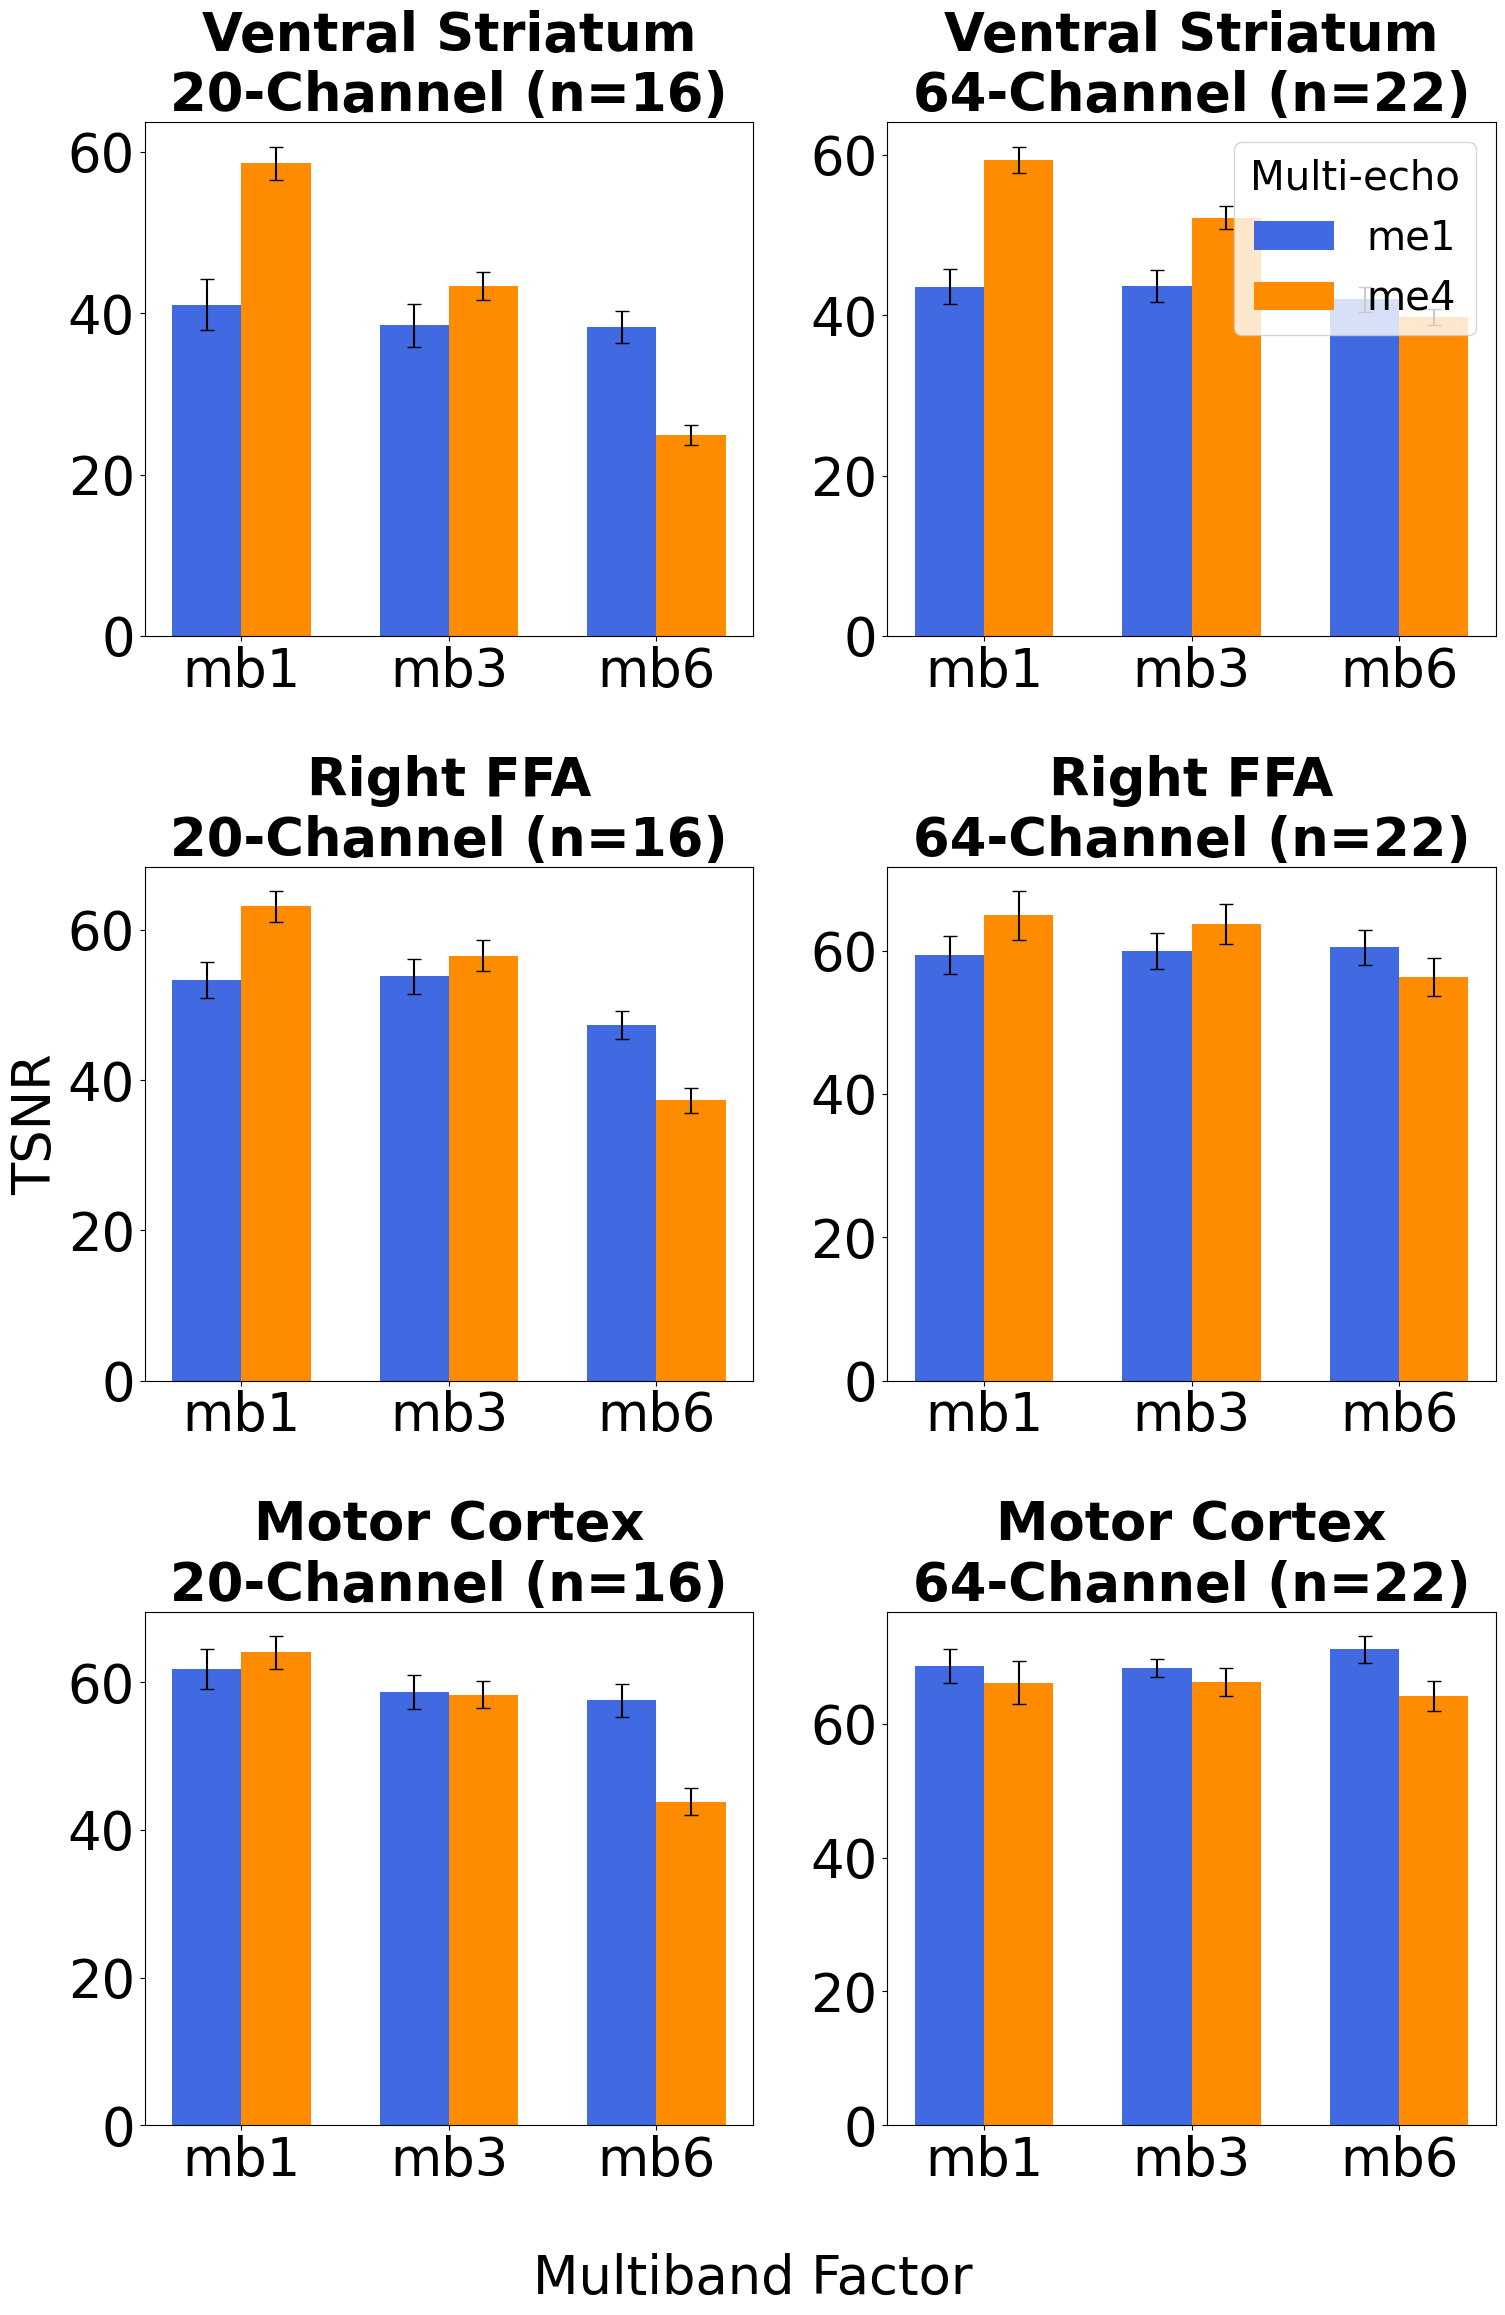


ANALYSIS COMPLETE - SUMMARY
ROIs analyzed: VSconstrained, rFFA, bilateralMotor

Subject counts by ROI:
  Ventral Striatum: 38 total (16 20-ch, 22 64-ch)
  Right FFA: 38 total (16 20-ch, 22 64-ch)
  Motor Cortex: 38 total (16 20-ch, 22 64-ch)

Files generated in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/plots:
  - multi_roi_tsnr_bar_plot.png
  - VSconstrained_tsnr_lme_anova_with_smoothness.csv
  - rFFA_tsnr_lme_anova_with_smoothness.csv
  - bilateralMotor_tsnr_lme_anova_with_smoothness.csv


In [15]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import glob
import warnings
from pymer4.models import Lmer
from pathlib import Path

# Suppress warnings
warnings.filterwarnings("ignore")

print("=" * 80)
print("MULTI-ROI TSNR ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Define paths relative to project root
extractions_dir = project_root / 'derivatives' / 'extractions'
smoothness_path = project_root / 'code' / 'smoothness-all.csv'

# Create output directory
output_dir = project_root / 'derivatives' / 'plots'
output_dir.mkdir(parents=True, exist_ok=True)

# Define parameters
TYPE_VALUE = "act"
IMG_VALUE = "tsnr"
DENOISE_VALUE = "base"

# Define ROIs to analyze
ROIS = ["VSconstrained", "rFFA", "bilateralMotor"]
ROI_LABELS = {
    "VSconstrained": "Ventral Striatum",
    "rFFA": "Right FFA", 
    "bilateralMotor": "Motor Cortex"
}

# Get valid subjects and headcoil information from main_df_final
valid_subjects = main_df_final['Subject'].astype(str).tolist()
headcoil_mapping = dict(zip(main_df_final['Subject'].astype(str), 
                           main_df_final['Headcoil'].astype(str)))

print(f"Filtering to {len(valid_subjects)} subjects from main population")
print(f"Processing TSNR for ROIs: {', '.join(ROIS)}")

# Output file names
complete_subjects_file = output_dir / 'complete_subjects_multi_roi_tsnr_with_smoothness.csv'
combined_plot_file = output_dir / 'multi_roi_tsnr_bar_plot.png'

# ============================================================================
# DATA PROCESSING FUNCTIONS
# ============================================================================

def extract_roi_tsnr_data(base_dir, type_value, img_value, mask_value, denoise_value, valid_subjects, headcoil_mapping):
    """Extract ROI TSNR data from .txt files"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_records = []
    acq_params_list = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip if not matching criteria
            if (sub_id not in valid_subjects or 
                file_type != type_value or 
                img != img_value or 
                mask != mask_value or 
                denoise != denoise_value or
                acq not in acq_params_list):
                continue

            try:
                with open(file_path, 'r') as f:
                    value = float(f.read().strip())
                
                # Extract mb and me
                mb_match = re.search(r'(mb\d)', acq)
                me_match = re.search(r'(me\d)', acq)
                mb = mb_match.group(1) if mb_match else None
                me = me_match.group(1) if me_match else None

                headcoil = headcoil_mapping.get(sub_id, None)
                
                data_records.append({
                    'subject': sub_id,
                    'headcoil': headcoil,
                    'mb': mb,
                    'me': me,
                    'acq_combined': acq,
                    img_value: value
                })
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    if not data_records:
        return None

    df = pd.DataFrame(data_records)
    
    # Convert to categorical
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])
    df['subject'] = df['subject'].astype(str)
    
    # Drop NaN values
    df = df.dropna()
    
    return df

def load_smoothness_data(csv_path, valid_subjects, headcoil_mapping):
    """Load and process smoothness data with shift correction"""
    try:
        data = pd.read_csv(csv_path)
        
        # Rename columns
        data = data.rename(columns={
            data.columns[0]: 'path',
            'Unnamed: 3': 'smoothness'
        })
        
        # Apply shift correction
        data['file_path'] = data['path'].shift(1)
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        
        # Extract subject, mb, me
        data['subject'] = data['file_path'].str.extract(r'sub-(\d+)')
        data['acq'] = data['file_path'].str.extract(r'acq-(mb\dme\d)')
        data['mb'] = data['acq'].str[:3]
        data['me'] = data['acq'].str[3:]
        
        # Filter to valid subjects
        data = data[data['subject'].isin(valid_subjects)]
        
        # Add headcoil from mapping
        data['headcoil'] = data['subject'].map(headcoil_mapping)
        
        # Create combined label
        data['acq_combined'] = data['mb'].astype(str) + data['me'].astype(str)
        
        # Select columns
        data = data[['subject', 'headcoil', 'mb', 'me', 'acq_combined', 'smoothness']]
        
        # Convert to categorical
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        
        # Drop NaN values
        data = data.dropna()
        
        return data
        
    except Exception as e:
        print(f"Error processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects(data_df, value_col):
    """Identify subjects with complete data across all 6 acquisitions"""
    expected_acq = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']
    
    pivot = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='acq_combined',
        aggfunc='first'
    ).reindex(columns=expected_acq)
    
    complete = pivot.dropna().index.tolist()
    return complete

def run_lme_analysis(merged_data, roi_name):
    """Run LME analysis for a specific ROI"""
    # Prepare data
    model_data = merged_data.copy()
    model_data['headcoil_encoded'] = model_data['headcoil'].cat.codes - 0.5
    
    # Fit model
    model = Lmer(f'{IMG_VALUE} ~ headcoil_encoded * mb * me + smoothness + (1 | subject)', 
                 data=model_data)
    model.fit()
    
    # Get ANOVA results
    anova_results = model.anova()
    
    # Define effect names
    effect_names = {
        'headcoil_encoded': 'Head Coil',
        'mb': 'Multiband',
        'me': 'Multi-echo',
        'smoothness': 'Smoothness',
        'headcoil_encoded:mb': 'Head Coil × Multiband',
        'headcoil_encoded:me': 'Head Coil × Multi-echo',
        'mb:me': 'Multiband × Multi-echo',
        'headcoil_encoded:mb:me': 'Head Coil × Multiband × Multi-echo'
    }
    
    # Define degrees of freedom
    df_dict = {
        'Head Coil': 1,
        'Multiband': 2,
        'Multi-echo': 1,
        'Smoothness': 1,
        'Head Coil × Multiband': 2,
        'Head Coil × Multi-echo': 1,
        'Multiband × Multi-echo': 2,
        'Head Coil × Multiband × Multi-echo': 2
    }
    
    # Build APA table
    apa_data = []
    for effect in anova_results.index:
        if effect not in ['(Intercept)', 'Residuals']:
            effect_name = effect_names.get(effect, effect)
            apa_data.append({
                'Effect': effect_name,
                'Sum Sq': anova_results.loc[effect, 'SS'] if 'SS' in anova_results.columns else np.nan,
                'Mean Sq': anova_results.loc[effect, 'MS'] if 'MS' in anova_results.columns else np.nan,
                'Num df': df_dict.get(effect_name, np.nan),
                'Den df': anova_results.loc[effect, 'DenomDF'] if 'DenomDF' in anova_results.columns else np.nan,
                'F': anova_results.loc[effect, 'F-stat'] if 'F-stat' in anova_results.columns else np.nan,
                'p': anova_results.loc[effect, 'P-val'] if 'P-val' in anova_results.columns else np.nan,
                'Partial η²': np.nan
            })
    
    # Compute partial eta-squared
    try:
        residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
    except (KeyError, IndexError):
        residual_var = model.ranef_var.iloc[1]['Var']
    
    n_obs = len(model_data)
    n_fixed = sum(df_dict.values())
    n_subj = model_data['subject'].nunique()
    ss_residual = residual_var * (n_obs - n_fixed - n_subj)
    
    for i, row in enumerate(apa_data):
        ss_effect = row['Sum Sq']
        if pd.notna(ss_effect):
            apa_data[i]['Partial η²'] = ss_effect / (ss_effect + ss_residual)
    
    # Create APA table
    apa_table = pd.DataFrame(apa_data)
    apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
    apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
    apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
    apa_table['Den df'] = apa_table['Den df'].round(2)
    apa_table['F'] = apa_table['F'].round(2)
    apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
    apa_table['Partial η²'] = apa_table['Partial η²'].round(3)
    
    return apa_table

# ============================================================================
# PART 1: LOAD DATA AND IDENTIFY COMPLETE SUBJECTS
# ============================================================================

print("\n" + "=" * 80)
print("PART 1: LOADING DATA AND IDENTIFYING COMPLETE SUBJECTS")
print("=" * 80)

# Load smoothness data
smoothness_data = load_smoothness_data(smoothness_path, valid_subjects, headcoil_mapping)
if smoothness_data is None:
    raise Exception("Failed to load smoothness data")

complete_smoothness = identify_complete_subjects(smoothness_data, 'smoothness')
print(f"Complete smoothness subjects: {len(complete_smoothness)}")

# Process each ROI
roi_results = {}
all_roi_data = {}

for roi in ROIS:
    print(f"\nProcessing {roi}...")
    
    # Load ROI data
    roi_data = extract_roi_tsnr_data(extractions_dir, TYPE_VALUE, IMG_VALUE, 
                                     roi, DENOISE_VALUE, valid_subjects, headcoil_mapping)
    
    if roi_data is None:
        print(f"Warning: No data found for {roi}")
        continue
    
    # Find complete subjects
    complete_roi = identify_complete_subjects(roi_data, IMG_VALUE)
    print(f"Complete {roi} subjects: {len(complete_roi)}")
    
    # Find common complete subjects
    common_complete = sorted(list(set(complete_roi) & set(complete_smoothness)))
    print(f"Common complete subjects: {len(common_complete)}")
    
    if not common_complete:
        print(f"No common complete subjects for {roi}")
        continue
    
    # Filter data
    roi_filtered = roi_data[roi_data['subject'].isin(common_complete)].copy()
    smoothness_filtered = smoothness_data[smoothness_data['subject'].isin(common_complete)].copy()
    
    # Merge datasets
    merged = pd.merge(
        roi_filtered[['subject', 'headcoil', 'mb', 'me', IMG_VALUE]],
        smoothness_filtered[['subject', 'mb', 'me', 'smoothness']],
        on=['subject', 'mb', 'me'],
        how='inner'
    ).dropna()
    
    # Store results
    roi_results[roi] = {
        'data': merged,
        'n_subjects': merged['subject'].nunique(),
        'n_20ch': len(merged[merged['headcoil'] == '20']['subject'].unique()),
        'n_64ch': len(merged[merged['headcoil'] == '64']['subject'].unique())
    }
    
    all_roi_data[roi] = roi_filtered

# ============================================================================
# PART 2: RUN LME ANALYSES FOR ALL ROIS
# ============================================================================

print("\n" + "=" * 80)
print("PART 2: LINEAR MIXED EFFECTS ANALYSES")
print("=" * 80)

for roi in ROIS:
    if roi not in roi_results:
        continue
        
    print(f"\n=== {ROI_LABELS[roi]} ({roi}) ===")
    roi_data = roi_results[roi]
    print(f"N = {roi_data['n_subjects']} subjects ({roi_data['n_20ch']} 20-ch, {roi_data['n_64ch']} 64-ch)")
    
    # Run LME
    apa_table = run_lme_analysis(roi_data['data'], roi)
    
    # Display results
    print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model:")
    print(f"Model: {IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)")
    print(f"Data: {ROI_LABELS[roi]} ROI\n")
    print(apa_table.to_string(index=False))
    
    # Save APA table
    anova_file = output_dir / f'{roi}_{IMG_VALUE}_lme_anova_with_smoothness.csv'
    apa_table.to_csv(anova_file, index=False)
    print(f"\nAPA table saved to '{anova_file.name}'")

# ============================================================================
# PART 3: CREATE COMBINED VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("PART 3: GENERATING COMBINED BAR PLOTS")
print("=" * 80)

# Calculate plot data for each ROI
plot_data_by_roi = {}
for roi in ROIS:
    if roi not in all_roi_data:
        continue
        
    roi_df = all_roi_data[roi]
    plot_data = roi_df.groupby(['mb', 'me', 'headcoil']).agg({
        IMG_VALUE: ['mean', 'sem']
    }).reset_index()
    plot_data.columns = ['mb', 'me', 'headcoil', 'mean', 'sem']
    plot_data_by_roi[roi] = plot_data

# Create 3x2 subplot layout
plt.rcParams.update({'font.size': 38})
fig, axes = plt.subplots(len(ROIS), 2, figsize=(16, 8 * len(ROIS)))

width = 0.4
x_pos = np.array([0, 1.2, 2.4])
colors = {'me1': 'royalblue', 'me4': 'darkorange'}
mb_levels = ['mb1', 'mb3', 'mb6']

# Function to plot data in a subplot
def plot_roi_data(ax, data, headcoil, roi_label, n_subjects):
    """Plot TSNR data for a specific ROI and headcoil"""
    
    hc_data = data[data['headcoil'] == headcoil]
    
    if hc_data.empty:
        ax.set_title(f"{roi_label}\n{headcoil}-Channel (n=0)", fontsize=38, fontweight='bold')
        return
    
    for me_level in ['me1', 'me4']:
        me_data = hc_data[hc_data['me'] == me_level]
        
        means = []
        sems = []
        for mb in mb_levels:
            mb_data = me_data[me_data['mb'] == mb]
            if not mb_data.empty:
                means.append(mb_data['mean'].iloc[0])
                sems.append(mb_data['sem'].iloc[0])
            else:
                means.append(0)
                sems.append(0)
        
        offset = -width/2 if me_level == 'me1' else width/2
        ax.bar(x_pos + offset, means, width, 
               label=me_level, color=colors[me_level],
               yerr=sems, capsize=5)
    
    ax.set_xticks(x_pos)
    ax.set_xticklabels(mb_levels)
    ax.tick_params(axis='both', which='major', labelsize=38)
    
    ax.set_title(f"{roi_label}\n{headcoil}-Channel (n={n_subjects})", 
                 fontsize=38, fontweight='bold')

# Plot each ROI
for roi_idx, roi in enumerate(ROIS):
    if roi not in plot_data_by_roi:
        continue
    
    plot_data = plot_data_by_roi[roi]
    roi_label = ROI_LABELS[roi]
    
    # Get subject counts
    if roi in all_roi_data:
        n_20ch = len(all_roi_data[roi][all_roi_data[roi]['headcoil'] == '20']['subject'].unique())
        n_64ch = len(all_roi_data[roi][all_roi_data[roi]['headcoil'] == '64']['subject'].unique())
    else:
        n_20ch = n_64ch = 0
    
    # Plot 20-channel (left column)
    plot_roi_data(axes[roi_idx, 0], plot_data, '20', roi_label, n_20ch)
    
    # Plot 64-channel (right column)
    plot_roi_data(axes[roi_idx, 1], plot_data, '64', roi_label, n_64ch)
    
    # Add y-axis label to leftmost plots
    if roi_idx == 1:  # Middle row
        axes[roi_idx, 0].set_ylabel('TSNR', fontsize=38)

# Add legend to top right subplot
axes[0, 1].legend(title='Multi-echo', fontsize=29, title_fontsize=29, 
                  loc='upper right')

# Add shared x-label
fig.supxlabel('Multiband Factor', fontsize=38, y=0.02)

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(combined_plot_file, dpi=300, bbox_inches='tight')
print(f"Combined plot saved to '{combined_plot_file}'")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)
print(f"ROIs analyzed: {', '.join(ROIS)}")
print(f"\nSubject counts by ROI:")
for roi in ROIS:
    if roi in roi_results:
        r = roi_results[roi]
        print(f"  {ROI_LABELS[roi]}: {r['n_subjects']} total ({r['n_20ch']} 20-ch, {r['n_64ch']} 64-ch)")
print(f"\nFiles generated in {output_dir}:")
print(f"  - {combined_plot_file.name}")
for roi in ROIS:
    if roi in roi_results:
        print(f"  - {roi}_{IMG_VALUE}_lme_anova_with_smoothness.csv")
print("=" * 80)

MULTI-ROI BETA ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND EMMs
Filtering to 38 subjects from main population
Processing beta values for ROIs: VSconstrained, rFFA, bilateralMotor

PART 1: LOADING DATA AND IDENTIFYING COMPLETE SUBJECTS
Complete smoothness subjects: 38

Processing VSconstrained...
Complete VSconstrained subjects: 38
Common complete subjects: 38

Processing rFFA...
Complete rFFA subjects: 38
Common complete subjects: 38

Processing bilateralMotor...
Complete bilateralMotor subjects: 36
Common complete subjects: 36

PART 2: LINEAR MIXED EFFECTS ANALYSES

=== Ventral Striatum (VSconstrained) ===
N = 38 subjects (16 20-ch, 22 64-ch)
Linear mixed model fit by REML [’lmerMod’]
Formula: beta~headcoil*mb*me+smoothness+(1|subject)

Family: gaussian	 Inference: parametric

Number of observations: 228	 Groups: {'subject': 38.0}

Log-likelihood: -1427.603 	 AIC: 2885.207

Random effects:

                 Name        Var      Std
subject   (Intercept)   1777.432   42.160
Residua

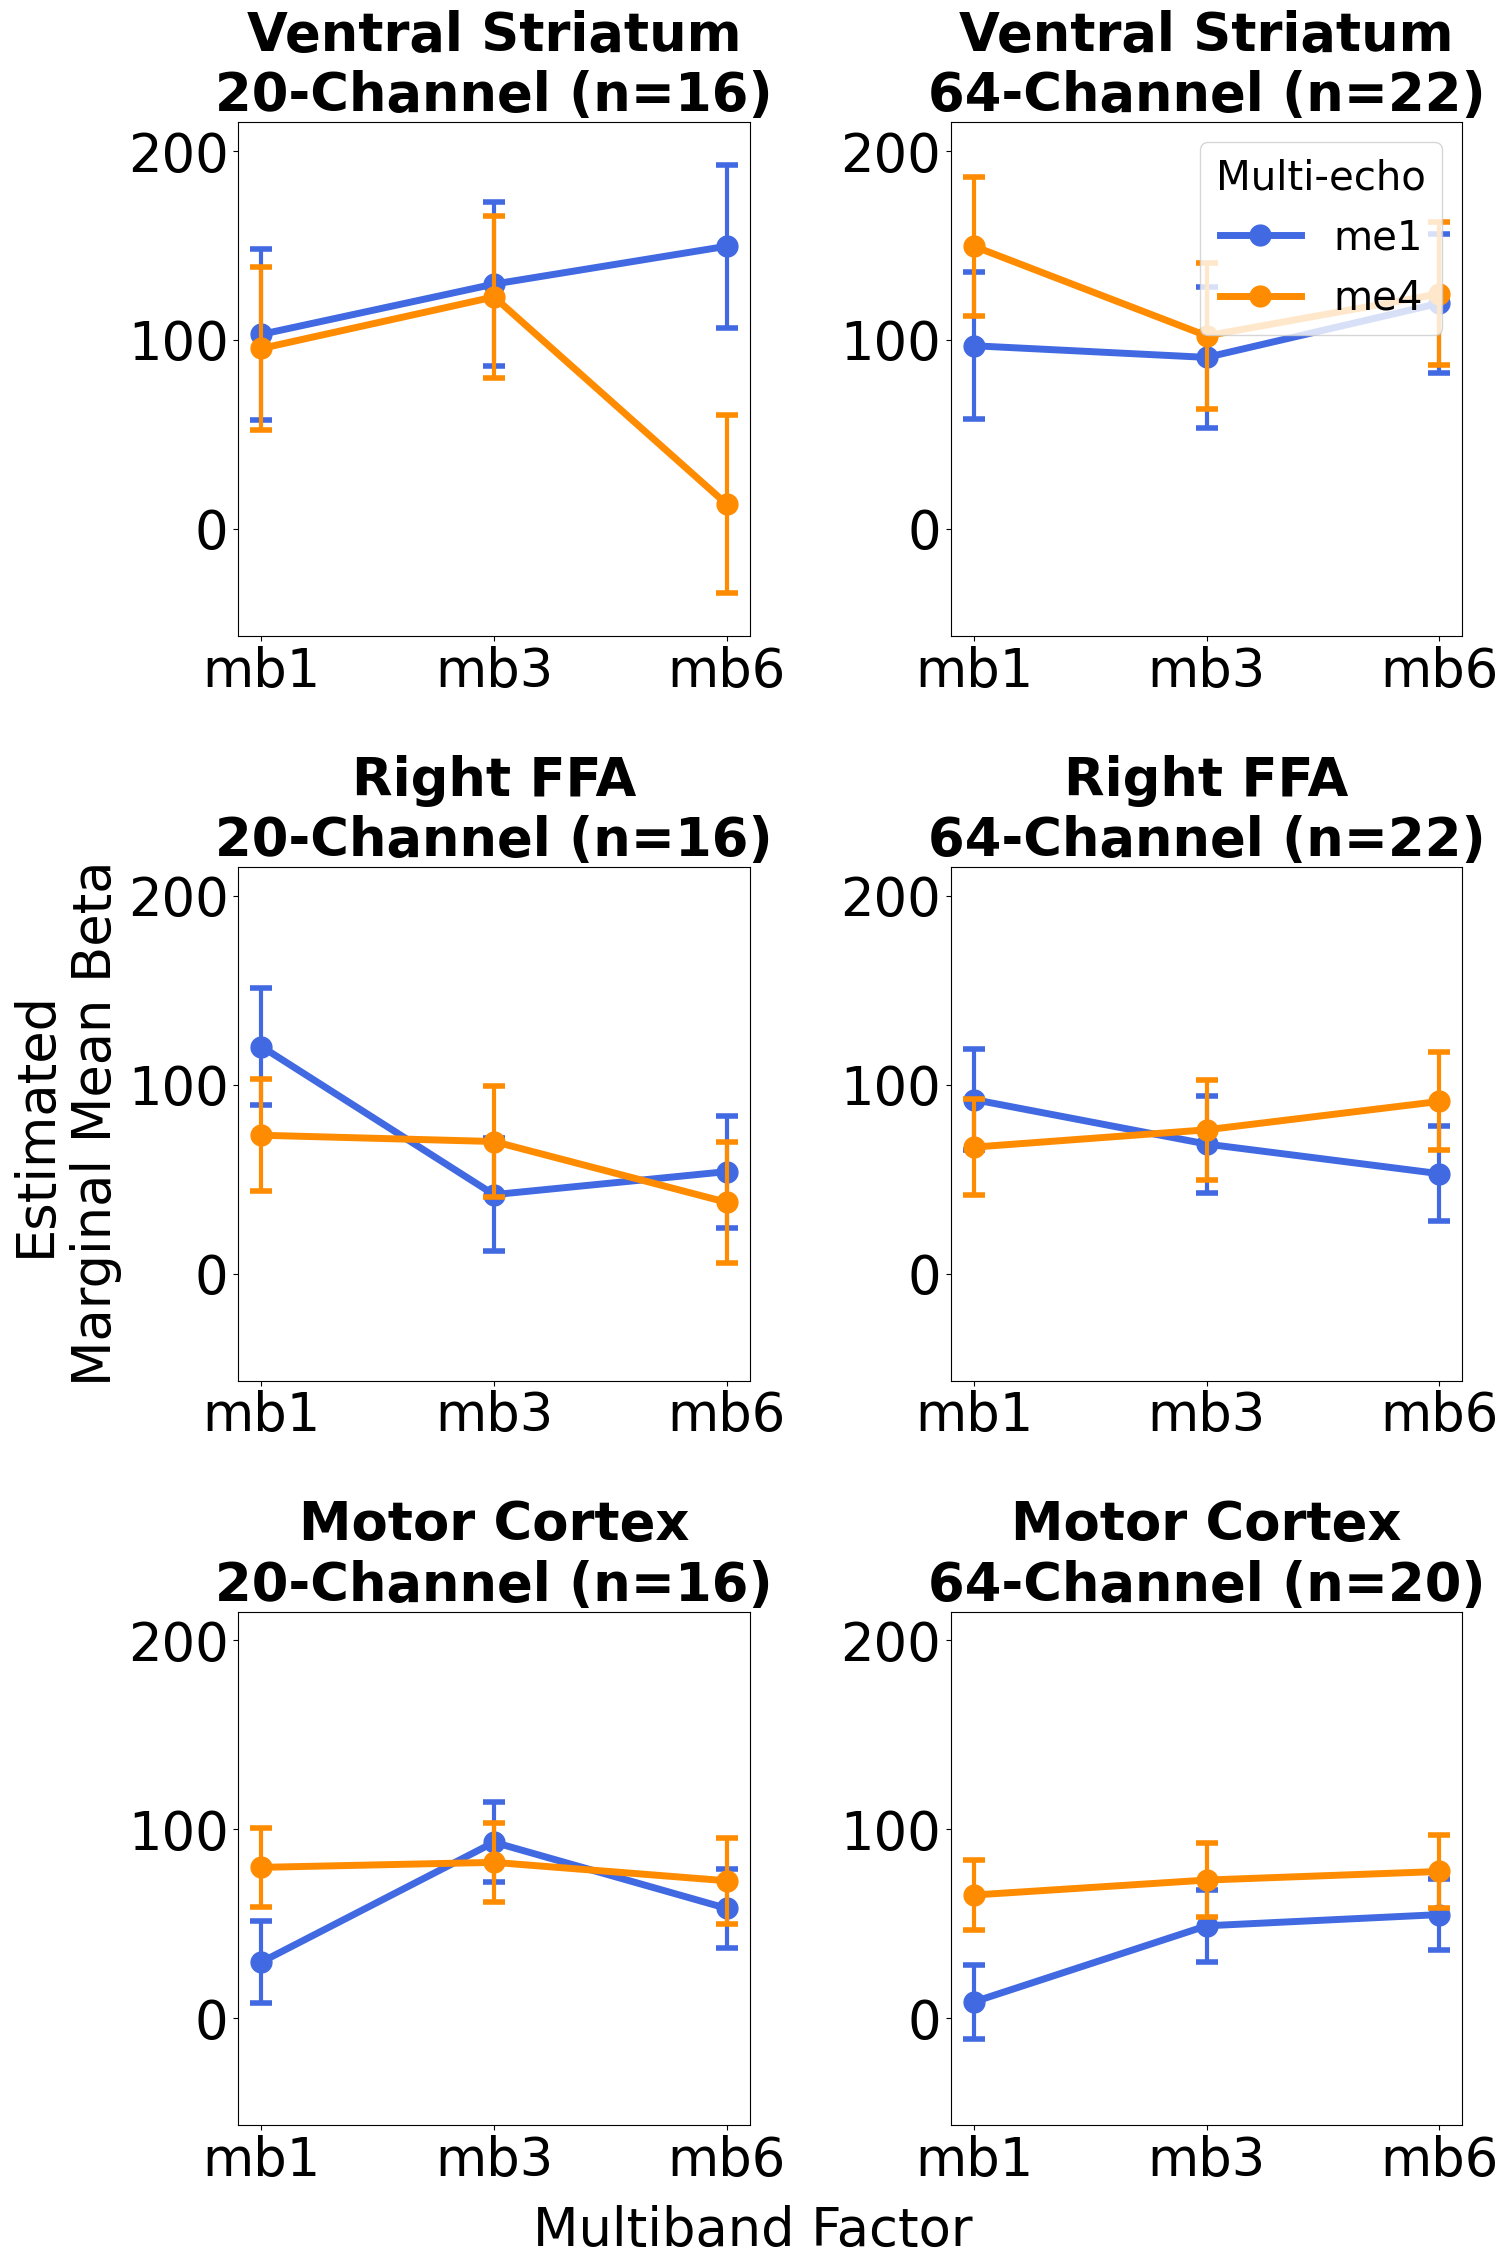


ANALYSIS COMPLETE - SUMMARY
ROIs analyzed: VSconstrained, rFFA, bilateralMotor

Subject counts by ROI:
  Ventral Striatum: 38 total (16 20-ch, 22 64-ch)
  Right FFA: 38 total (16 20-ch, 22 64-ch)
  Motor Cortex: 36 total (16 20-ch, 20 64-ch)

Files generated in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/plots:
  - multi_roi_beta_emm_plot.png
  - VSconstrained_beta_lme_anova_with_smoothness.csv
  - rFFA_beta_lme_anova_with_smoothness.csv
  - bilateralMotor_beta_lme_anova_with_smoothness.csv


In [23]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import glob
import warnings
from pymer4.models import Lmer
from pathlib import Path

# R integration for EMM calculations
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects.numpy2ri as numpy2ri
import rpy2.robjects as ro
from rpy2.robjects.packages import importr

# Activate conversions
numpy2ri.activate()
pandas2ri.activate()

# Import R packages
lme4 = importr('lme4')
emmeans = importr('emmeans')
base = importr('base')
stats = importr('stats')

# Suppress warnings
warnings.filterwarnings("ignore")

print("=" * 80)
print("MULTI-ROI BETA ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND EMMs")
print("=" * 80)

# ============================================================================
# CONFIGURATION
# ============================================================================

# Define paths relative to project root
extractions_dir = project_root / 'derivatives' / 'extractions'
smoothness_path = project_root / 'code' / 'smoothness-all.csv'

# Create output directory
output_dir = project_root / 'derivatives' / 'plots'
output_dir.mkdir(parents=True, exist_ok=True)

# Define parameters
TYPE_VALUE = "act"
IMG_VALUE = "beta"
DENOISE_VALUE = "base"

# Define ROIs to analyze
ROIS = ["VSconstrained", "rFFA", "bilateralMotor"]
ROI_LABELS = {
    "VSconstrained": "Ventral Striatum",
    "rFFA": "Right FFA", 
    "bilateralMotor": "Motor Cortex"
}

# Get valid subjects and headcoil information from main_df_final
valid_subjects = main_df_final['Subject'].astype(str).tolist()
headcoil_mapping = dict(zip(main_df_final['Subject'].astype(str), 
                           main_df_final['Headcoil'].astype(str)))

print(f"Filtering to {len(valid_subjects)} subjects from main population")
print(f"Processing beta values for ROIs: {', '.join(ROIS)}")

# Output file
combined_emm_plot_file = output_dir / 'multi_roi_beta_emm_plot.png'

# ============================================================================
# DATA PROCESSING FUNCTIONS
# ============================================================================

def extract_roi_beta_data(base_dir, type_value, img_value, mask_value, denoise_value, valid_subjects, headcoil_mapping):
    """Extract ROI beta data from .txt files"""
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_records = []
    acq_params_list = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            
            # Skip if not matching criteria
            if (sub_id not in valid_subjects or 
                file_type != type_value or 
                img != img_value or 
                mask != mask_value or 
                denoise != denoise_value or
                acq not in acq_params_list):
                continue

            try:
                with open(file_path, 'r') as f:
                    value = float(f.read().strip())
                
                # Extract mb and me
                mb_match = re.search(r'(mb\d)', acq)
                me_match = re.search(r'(me\d)', acq)
                mb = mb_match.group(1) if mb_match else None
                me = me_match.group(1) if me_match else None

                headcoil = headcoil_mapping.get(sub_id, None)
                
                data_records.append({
                    'subject': sub_id,
                    'headcoil': headcoil,
                    'mb': mb,
                    'me': me,
                    'acq_combined': acq,
                    img_value: value
                })
            except Exception as e:
                print(f"Error processing file {filename}: {e}")

    if not data_records:
        return None

    df = pd.DataFrame(data_records)
    
    # Convert to categorical
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])
    df['subject'] = df['subject'].astype(str)
    
    # Drop NaN values
    df = df.dropna()
    
    return df

def load_smoothness_data(csv_path, valid_subjects, headcoil_mapping):
    """Load and process smoothness data with shift correction"""
    try:
        data = pd.read_csv(csv_path)
        
        # Rename columns
        data = data.rename(columns={
            data.columns[0]: 'path',
            'Unnamed: 3': 'smoothness'
        })
        
        # Apply shift correction
        data['file_path'] = data['path'].shift(1)
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        
        # Extract subject, mb, me
        data['subject'] = data['file_path'].str.extract(r'sub-(\d+)')
        data['acq'] = data['file_path'].str.extract(r'acq-(mb\dme\d)')
        data['mb'] = data['acq'].str[:3]
        data['me'] = data['acq'].str[3:]
        
        # Filter to valid subjects
        data = data[data['subject'].isin(valid_subjects)]
        
        # Add headcoil from mapping
        data['headcoil'] = data['subject'].map(headcoil_mapping)
        
        # Create combined label
        data['acq_combined'] = data['mb'].astype(str) + data['me'].astype(str)
        
        # Select columns
        data = data[['subject', 'headcoil', 'mb', 'me', 'acq_combined', 'smoothness']]
        
        # Convert to categorical
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        
        # Drop NaN values
        data = data.dropna()
        
        return data
        
    except Exception as e:
        print(f"Error processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects(data_df, value_col):
    """Identify subjects with complete data across all 6 acquisitions"""
    expected_acq = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']
    
    pivot = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='acq_combined',
        aggfunc='first'
    ).reindex(columns=expected_acq)
    
    complete = pivot.dropna().index.tolist()
    return complete

def run_lme_analysis(merged_data, roi_name):
    """Run LME analysis for a specific ROI"""
    # Prepare data
    model_data = merged_data.copy()
    
    # Fit model using pymer4
    model = Lmer(f'{IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)', 
                 data=model_data)
    model.fit()
    
    # Get ANOVA results
    anova_results = model.anova()
    
    # Define effect names
    effect_names = {
        'headcoil': 'Head Coil',
        'mb': 'Multiband',
        'me': 'Multi-echo',
        'smoothness': 'Smoothness',
        'headcoil:mb': 'Head Coil × Multiband',
        'headcoil:me': 'Head Coil × Multi-echo',
        'mb:me': 'Multiband × Multi-echo',
        'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo'
    }
    
    # Define degrees of freedom
    df_dict = {
        'Head Coil': 1,
        'Multiband': 2,
        'Multi-echo': 1,
        'Smoothness': 1,
        'Head Coil × Multiband': 2,
        'Head Coil × Multi-echo': 1,
        'Multiband × Multi-echo': 2,
        'Head Coil × Multiband × Multi-echo': 2
    }
    
    # Build APA table
    apa_data = []
    for effect in anova_results.index:
        if effect not in ['(Intercept)', 'Residuals']:
            effect_name = effect_names.get(effect, effect)
            apa_data.append({
                'Effect': effect_name,
                'Sum Sq': anova_results.loc[effect, 'SS'] if 'SS' in anova_results.columns else np.nan,
                'Mean Sq': anova_results.loc[effect, 'MS'] if 'MS' in anova_results.columns else np.nan,
                'Num df': df_dict.get(effect_name, np.nan),
                'Den df': anova_results.loc[effect, 'DenomDF'] if 'DenomDF' in anova_results.columns else np.nan,
                'F': anova_results.loc[effect, 'F-stat'] if 'F-stat' in anova_results.columns else np.nan,
                'p': anova_results.loc[effect, 'P-val'] if 'P-val' in anova_results.columns else np.nan,
                'Partial η²': np.nan
            })
    
    # Compute partial eta-squared
    try:
        residual_var = model.ranef_var.loc[model.ranef_var['Name'] == '', 'Var'].iloc[0]
    except (KeyError, IndexError):
        residual_var = model.ranef_var.iloc[1]['Var']
    
    for i, row in enumerate(apa_data):
        ss_effect = row['Sum Sq']
        denom_df = row['Den df']
        if pd.notna(ss_effect) and pd.notna(residual_var) and pd.notna(denom_df):
            apa_data[i]['Partial η²'] = ss_effect / (ss_effect + (residual_var * denom_df))
    
    # Create APA table
    apa_table = pd.DataFrame(apa_data)
    apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
    apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
    apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
    apa_table['Den df'] = apa_table['Den df'].round(2)
    apa_table['F'] = apa_table['F'].round(2)
    apa_table['p'] = apa_table['p'].apply(lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A')
    apa_table['Partial η²'] = apa_table['Partial η²'].round(3)
    
    return apa_table, model_data

def compute_emms_for_roi(data, roi_name):
    """Compute estimated marginal means using R for a specific ROI"""
    # Prepare data for R
    data_r = data.rename(columns={
        'subject': 'Subj',
        'headcoil': 'HC',
        'mb': 'MB',
        'me': 'ME',
        IMG_VALUE: 'BetaValue'
    })
    
    # Drop NaN values
    data_r = data_r.dropna(subset=['BetaValue', 'MB', 'ME', 'HC', 'Subj', 'smoothness'])
    
    # Ensure string types
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    # Convert to R DataFrame
    r_df_temp = pandas2ri.py2rpy(data_r)
    r_df_name = f"temp_emm_data_{roi_name}"
    ro.globalenv[r_df_name] = r_df_temp
    
    # Define factor levels in R
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    levels_HC <- c("20", "64")
    ''')
    
    # Apply factor conversions
    r_df = ro.r(f'''
    transform({r_df_name}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC, levels = levels_HC))
    ''')
    
    # Clean up
    del ro.globalenv[r_df_name]
    
    # Fit model in R
    formula = Formula('BetaValue ~ HC * MB * ME + smoothness + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Compute EMMs
    emm = emmeans.emmeans(model, 'MB', by=ro.StrVector(['HC', 'ME']))
    
    # Convert to pandas DataFrame
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric factors back to strings
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_map = {1: '20', 2: '64'}
    
    emm_df['MB'] = emm_df['MB'].map(mb_map)
    emm_df['ME'] = emm_df['ME'].map(me_map)
    emm_df['HC'] = emm_df['HC'].map(hc_map)
    
    return emm_df

# ============================================================================
# PART 1: LOAD DATA AND IDENTIFY COMPLETE SUBJECTS
# ============================================================================

print("\n" + "=" * 80)
print("PART 1: LOADING DATA AND IDENTIFYING COMPLETE SUBJECTS")
print("=" * 80)

# Load smoothness data
smoothness_data = load_smoothness_data(smoothness_path, valid_subjects, headcoil_mapping)
if smoothness_data is None:
    raise Exception("Failed to load smoothness data")

complete_smoothness = identify_complete_subjects(smoothness_data, 'smoothness')
print(f"Complete smoothness subjects: {len(complete_smoothness)}")

# Process each ROI
roi_results = {}
emm_results = {}

for roi in ROIS:
    print(f"\nProcessing {roi}...")
    
    # Load ROI data
    roi_data = extract_roi_beta_data(extractions_dir, TYPE_VALUE, IMG_VALUE, 
                                     roi, DENOISE_VALUE, valid_subjects, headcoil_mapping)
    
    if roi_data is None:
        print(f"Warning: No data found for {roi}")
        continue
    
    # Find complete subjects
    complete_roi = identify_complete_subjects(roi_data, IMG_VALUE)
    print(f"Complete {roi} subjects: {len(complete_roi)}")
    
    # Find common complete subjects
    common_complete = sorted(list(set(complete_roi) & set(complete_smoothness)))
    print(f"Common complete subjects: {len(common_complete)}")
    
    if not common_complete:
        print(f"No common complete subjects for {roi}")
        continue
    
    # Filter data
    roi_filtered = roi_data[roi_data['subject'].isin(common_complete)].copy()
    smoothness_filtered = smoothness_data[smoothness_data['subject'].isin(common_complete)].copy()
    
    # Merge datasets
    merged = pd.merge(
        roi_filtered[['subject', 'headcoil', 'mb', 'me', IMG_VALUE]],
        smoothness_filtered[['subject', 'mb', 'me', 'smoothness']],
        on=['subject', 'mb', 'me'],
        how='inner'
    ).dropna()
    
    # Store results
    roi_results[roi] = {
        'data': merged,
        'n_subjects': merged['subject'].nunique(),
        'n_20ch': len(merged[merged['headcoil'] == '20']['subject'].unique()),
        'n_64ch': len(merged[merged['headcoil'] == '64']['subject'].unique()),
        'filtered_data': roi_filtered
    }

# ============================================================================
# PART 2: RUN LME ANALYSES FOR ALL ROIS
# ============================================================================

print("\n" + "=" * 80)
print("PART 2: LINEAR MIXED EFFECTS ANALYSES")
print("=" * 80)

for roi in ROIS:
    if roi not in roi_results:
        continue
        
    print(f"\n=== {ROI_LABELS[roi]} ({roi}) ===")
    roi_data = roi_results[roi]
    print(f"N = {roi_data['n_subjects']} subjects ({roi_data['n_20ch']} 20-ch, {roi_data['n_64ch']} 64-ch)")
    
    # Run LME
    apa_table, model_data = run_lme_analysis(roi_data['data'], roi)
    
    # Display results
    print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model:")
    print(f"Model: {IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)")
    print(f"Data: {ROI_LABELS[roi]} ROI\n")
    print(apa_table.to_string(index=False))
    
    # Save APA table
    anova_file = output_dir / f'{roi}_{IMG_VALUE}_lme_anova_with_smoothness.csv'
    apa_table.to_csv(anova_file, index=False)
    print(f"\nAPA table saved to '{anova_file.name}'")
    
    # Compute EMMs
    emm_df = compute_emms_for_roi(roi_data['data'], roi)
    emm_results[roi] = emm_df

# ============================================================================
# PART 3: CREATE COMBINED EMM VISUALIZATION
# ============================================================================

print("\n" + "=" * 80)
print("PART 3: GENERATING COMBINED EMM PLOTS")
print("=" * 80)

# Create 3x2 subplot layout
plt.rcParams.update({'font.size': 38})
fig, axes = plt.subplots(len(ROIS), 2, figsize=(16, 8 * len(ROIS)))

me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}

# Function to plot EMM data in a subplot
def plot_emm_data(ax, emm_df, headcoil, roi_label, n_subjects):
    """Plot EMM data for a specific ROI and headcoil"""
    
    coil_data = emm_df[emm_df['HC'] == headcoil]
    
    if coil_data.empty:
        ax.set_title(f"{roi_label}\n{headcoil}-Channel (n=0)", fontsize=38, fontweight='bold')
        return
    
    for me in ['me1', 'me4']:
        me_data = coil_data[coil_data['ME'] == me]
        me_data = me_data.sort_values('MB', key=lambda x: x.str.extract(r'mb(\d+)')[0].astype(int))
        
        ax.plot(me_data['MB'], me_data['emmean'], 
                marker='o', color=me_colors[me], label=me, 
                linewidth=5, markersize=15)
        ax.errorbar(me_data['MB'], me_data['emmean'], yerr=me_data['SE'], 
                    fmt='none', color=me_colors[me], 
                    capsize=8, capthick=4, elinewidth=3)
    
    ax.set_title(f"{roi_label}\n{headcoil}-Channel (n={n_subjects})", 
                 fontsize=38, fontweight='bold')
    ax.tick_params(axis='both', which='major', labelsize=38)

# Calculate global y-limits across all ROIs
all_y_values = []
all_y_errors = []
for roi in ROIS:
    if roi in emm_results:
        emm_df = emm_results[roi]
        all_y_values.extend(emm_df['emmean'].values)
        all_y_errors.extend(emm_df['SE'].values)

if all_y_values:
    y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
    y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
    margin = (y_max - y_min) * 0.1
    y_limits = (y_min - margin, y_max + margin)
else:
    y_limits = (-1, 1)

# Plot each ROI
for roi_idx, roi in enumerate(ROIS):
    if roi not in emm_results:
        continue
    
    emm_df = emm_results[roi]
    roi_label = ROI_LABELS[roi]
    roi_data = roi_results[roi]
    
    # Plot 20-channel (left column)
    plot_emm_data(axes[roi_idx, 0], emm_df, '20', roi_label, roi_data['n_20ch'])
    axes[roi_idx, 0].set_ylim(y_limits)
    
    # Plot 64-channel (right column)
    plot_emm_data(axes[roi_idx, 1], emm_df, '64', roi_label, roi_data['n_64ch'])
    axes[roi_idx, 1].set_ylim(y_limits)
    
    # Add y-axis label to leftmost plots
    if roi_idx == 1:  # Middle row
        axes[roi_idx, 0].set_ylabel('Estimated\nMarginal Mean Beta', fontsize=38)

# Add legend to top right subplot
axes[0, 1].legend(title='Multi-echo', fontsize=29, title_fontsize=29, 
                  loc='upper right')

# Add shared x-label
fig.supxlabel('Multiband Factor', fontsize=38, y=0.04)

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(combined_emm_plot_file, dpi=300, bbox_inches='tight')
print(f"Combined EMM plot saved to '{combined_emm_plot_file}'")
plt.show()

# ============================================================================
# SUMMARY
# ============================================================================

print("\n" + "=" * 80)
print("ANALYSIS COMPLETE - SUMMARY")
print("=" * 80)
print(f"ROIs analyzed: {', '.join(ROIS)}")
print(f"\nSubject counts by ROI:")
for roi in ROIS:
    if roi in roi_results:
        r = roi_results[roi]
        print(f"  {ROI_LABELS[roi]}: {r['n_subjects']} total ({r['n_20ch']} 20-ch, {r['n_64ch']} 64-ch)")
print(f"\nFiles generated in {output_dir}:")
print(f"  - {combined_emm_plot_file.name}")
for roi in ROIS:
    if roi in roi_results:
        print(f"  - {roi}_{IMG_VALUE}_lme_anova_with_smoothness.csv")
print("=" * 80)

# BETAs: Estimated Marginal Means (EMMs) Line Plots (Figure 6)
This kernel is dedicated to visualizing the Estimated Marginal Means (EMMs) derived from the Linear Mixed Effects (LME) model fitted in the previous section. EMMs, also known as least-squares means, are predictions from a statistical model over a regular grid of predictor values, often adjusted for covariates. They're especially useful for interpreting effects in complex models like LMEs, particularly when interactions between factors are present.

The code here uses the rpy2 library to connect with R's powerful statistical packages, specifically lme4 for the mixed-effects model and emmeans for calculating these estimated marginal means.

## How it Works:
- Input Data: It takes your preprocessed and merged analysis data (which includes subject, headcoil, mb, me, your beta values, and smoothness) as its main input. It also uses the subject counts per head coil to display in the plot titles.
- LME Model Fitting: A simplified LME model is re-fitted internally within the plotting function using rpy2 and R's lme4. This model includes the headcoil, multiband, multi-echo factors, their interactions, and the smoothness covariate, with subject as a random effect. This ensures the EMMs are properly adjusted for all relevant variables.
- EMM Calculation: After the model is fitted, rpy2 calls R's emmeans package to compute the estimated marginal means of your beta values across the multiband factor, conditioned on headcoil and multi-echo levels.
- Visualization: Using matplotlib, the kernel generates clear line plots. Each subplot represents a head coil type, showing the EMMs for different multiband factors, with distinct lines for multi-echo types. Error bars indicate the standard error of the means. The y-axis is kept consistent across subplots for easy comparison.
- Output: The generated plot is saved as a PNG image (rFFA_beta_emm_plot.png) and displayed right in your notebook.

This visualization offers an intuitive way to understand the main effects and interactions of your experimental factors on the beta values, all while accounting for the smoothness covariate and individual subject variability.

BETA VS ROI ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND EMMs
ROI Beta extraction directory: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Smoothness input file: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/code/smoothness-all.csv
Processing Beta for ROI: VSconstrained
Initiating data processing...

PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR VSconstrained BETA AND SMOOTHNESS
Scanning 11361 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions for VSconstrained beta data...
Successfully extracted 240 VSconstrained beta data points.
Successfully extracted 311 smoothness data points.
Subjects with complete ROI Beta data (VSconstrained): 40
Subjects with complete Smoothness data: 41

Total common complete subjects for combined VSconstrained beta and Smoothness analysis: 40

Final dataset for LME analysis contains 40 subjects for VSconstrained beta.
Subject count per Headcoil (for LME analysis dataset):

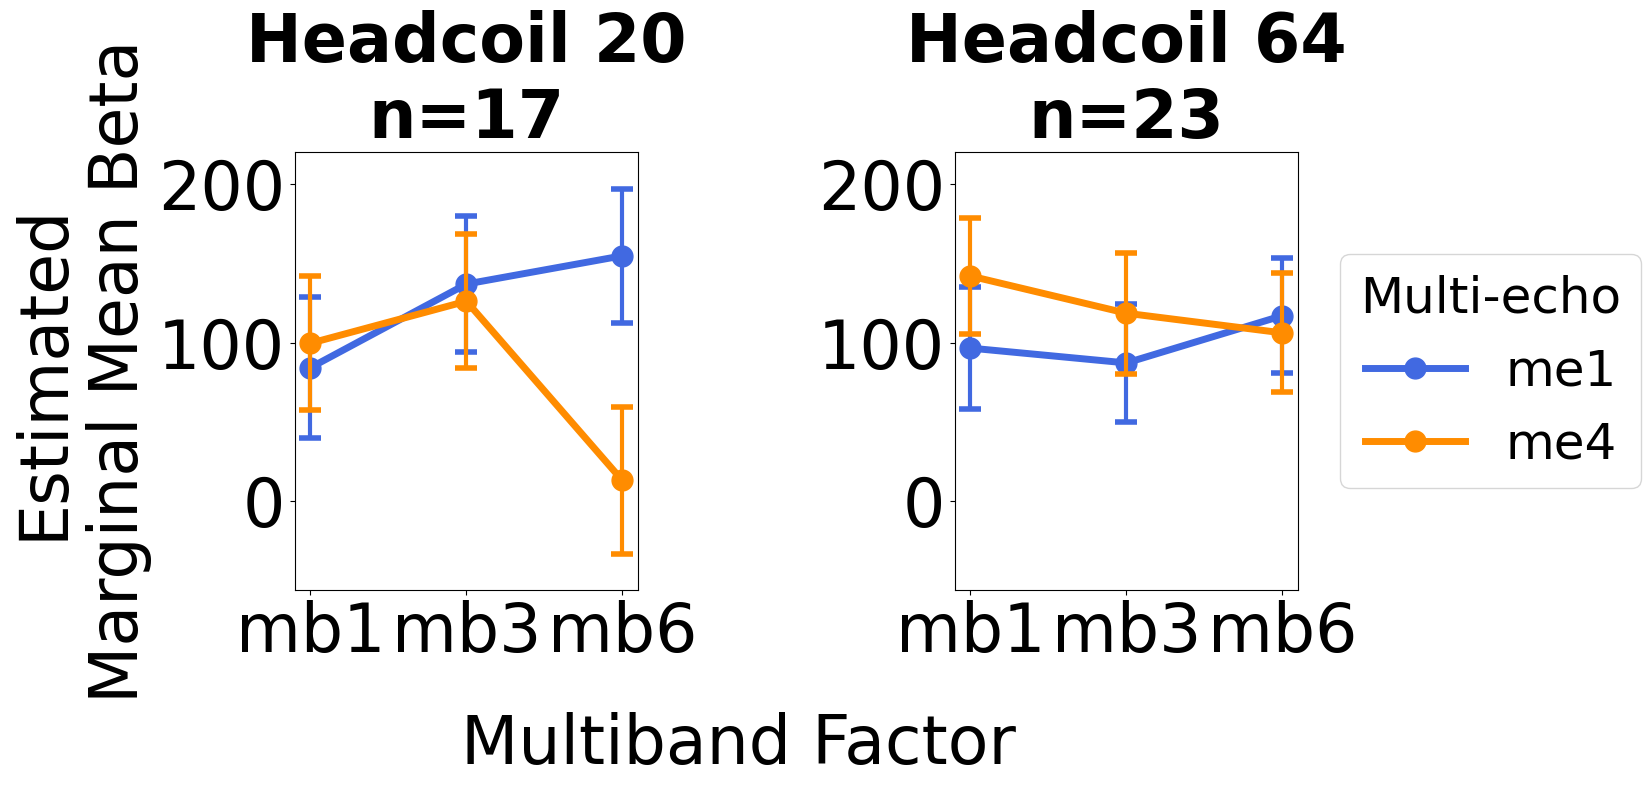

In [25]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import glob
import warnings
from pymer4.models import Lmer
from patsy import dmatrix
import rpy2.robjects as robjects
from rpy2.robjects import conversion
import rpy2.robjects.numpy2ri as numpy2ri

# --- Add rpy2 specific imports and setup for EMM plots ---
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate numpy2ri conversion (already present)
numpy2ri.activate()
# Activate pandas2ri conversion (NEW)
pandas2ri.activate()

# Import R packages required for EMM plotting (NEW)
lme4 = importr('lme4')
lmerTest = importr('lmerTest') # Useful if you run LME directly in R, though pymer4 handles it
emmeans = importr('emmeans')
base = importr('base')
stats = importr('stats')

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")
warnings.filterwarnings("ignore", message="The 'n_eff' parameter is deprecated")

print("=" * 80)
print("BETA VS ROI ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND EMMs")
print("=" * 80)

# Configuration
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
TYPE_VALUE = "act"
IMG_VALUE = "beta" # This variable holds the name of your value column (e.g., 'beta')
MASK_VALUE = "VSconstrained"
DENOISE_VALUE = "base"
smoothness_csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/code/smoothness-all.csv')

HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

complete_subjects_roi_beta_file = f'complete_subjects_{MASK_VALUE}_{IMG_VALUE}_common_with_smoothness.csv'
anova_table_file = f'{MASK_VALUE}_{IMG_VALUE}_lme_anova_with_smoothness.csv'
emm_table_file = f'{MASK_VALUE}_{IMG_VALUE}_emm_table.csv'

print(f"ROI Beta extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Processing Beta for ROI: {MASK_VALUE}")
print(f"Initiating data processing...")

# --- NEW: Function to create EMM Line Plots, adapted for this kernel's data ---
def create_emm_line_plots(data, n_subjects_per_coil, img_value_col_name):
    """
    Create line plots for estimated marginal means of beta values with consistent y-axis across subplots.

    Args:
        data (pd.DataFrame): The input DataFrame containing ROI beta and smoothness data.
                             Expected columns: 'subject', 'headcoil', 'mb', 'me', img_value_col_name, 'smoothness'.
        n_subjects_per_coil (dict): A dictionary mapping coil names ('20', '64') to the number of subjects for each coil.
        img_value_col_name (str): The name of the column in 'data' that contains the values to plot EMMs for (e.g., 'beta').
    """
    # Prepare data for R
    # Rename columns to match R-friendly names (e.g., 'BetaValue' for the outcome)
    data_r = data.rename(columns={'subject': 'Subj', 'headcoil': 'HC', 'mb': 'MB', 'me': 'ME',
                                  img_value_col_name: 'BetaValue'})
    
    # Drop rows with any NaN in critical columns before sending to R
    data_r = data_r.dropna(subset=['BetaValue', 'MB', 'ME', 'HC', 'Subj', 'smoothness'])
    
    # Ensure relevant columns are of string type for R factor conversion
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    # Convert pandas DataFrame to R DataFrame
    r_df_temp = pandas2ri.py2rpy(data_r) # Renamed to avoid confusion with R object name

    # Push the R DataFrame object to the R global environment with a temporary name
    r_df_name = "temp_emm_data_df" # A unique temporary name for the R object
    ro.globalenv[r_df_name] = r_df_temp

    # Define factor levels in R to ensure correct ordering in plots/models
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    levels_HC <- c("20", "64") # Explicitly define headcoil levels
    ''')

    # Apply factor conversions in R to the DataFrame
    # Now, explicitly use the name we gave the DataFrame in R
    r_df = ro.r(f'''
    transform({r_df_name}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC, levels = levels_HC))
    ''') # No .format() needed here because we use f-string and the R name

    # Clean up the temporary R object (optional)
    del ro.globalenv[r_df_name]
    
    # Fit the Linear Mixed Effects Model using lme4
    # IMPORTANT: Added 'smoothness' covariate to the formula
    formula = Formula(f'BetaValue ~ HC * MB * ME + smoothness + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Compute Estimated Marginal Means (EMMs) using emmeans
    emm = emmeans.emmeans(model, 'MB', by=ro.StrVector(['HC', 'ME']))
    
    # Convert the R EMMs object to a pandas DataFrame
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric factor indices back to original string labels from R
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_levels = sorted(data['headcoil'].unique()) # Get actual headcoil levels from data
    hc_map = {i + 1: hc for i, hc in enumerate(hc_levels)}
    
    emm_df['MB'] = emm_df['MB'].map(mb_map)
    emm_df['ME'] = emm_df['ME'].map(me_map)
    emm_df['HC'] = emm_df['HC'].map(hc_map)
    
    # --- Plotting Section ---
    plt.rcParams.update({'font.size': 48})
    
    coil_types = emm_df['HC'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    
    if len(coil_types) == 1:
        axes = [axes]
    
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = emm_df[emm_df['HC'] == coil]
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            if not me_data.empty:
                y_values = me_data['emmean'].values
                y_errors = me_data['SE'].values
                all_y_values.extend(y_values)
                all_y_errors.extend(y_errors)
    
    if all_y_values:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1
        y_limits = (y_min - margin, y_max + margin) # Allow negative if data goes there
    else:
        y_limits = (-1, 1) # Default limits if no data
    
    for i, coil in enumerate(coil_types):
        ax = axes[i]
        coil_data = emm_df[emm_df['HC'] == coil]
        
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            me_data = me_data.sort_values('MB', key=lambda x: x.str.extract(r'mb(\d+)')[0].astype(int))
            
            ax.plot(me_data['MB'], me_data['emmean'], marker='o', color=me_colors[me], label=me, linewidth=5, markersize=15)
            ax.errorbar(me_data['MB'], me_data['emmean'], yerr=me_data['SE'], fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        # Adjusted title to use 'Headcoil' instead of 'Channel' if '20' or '64' are your nominal headcoil types
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"Headcoil {coil}\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        if i == 0:
            ax.set_ylabel(f'Estimated\nMarginal Mean {img_value_col_name.capitalize()}', fontsize=48)
        
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.set_ylim(y_limits)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    plt.savefig(f'{MASK_VALUE}_{IMG_VALUE}_emm_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

# Part 1: Data Processing and Common Complete Subject Identification
print("\n" + "=" * 80)
print(f"PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR {MASK_VALUE} BETA AND SMOOTHNESS")
print("=" * 80)

def extract_roi_data(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects):
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_records = []
    acq_params_list = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    print(f"Scanning {len(file_paths)} files in {base_dir} for {mask_value} {img_value} data...")
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or (file_type != type_value or img != img_value or mask != mask_value or denoise != denoise_value):
                continue
            if acq not in acq_params_list:
                continue
            try:
                with open(file_path, 'r') as f:
                    value = float(f.read().strip())
                mb_match = re.search(r'(mb\d)', acq)
                me_match = re.search(r'(me\d)', acq)
                mb = mb_match.group(1) if mb_match else None
                me = me_match.group(1) if me_match else None
                headcoil = '64' if sub_id in headcoil_64_subjects else '20'
                data_records.append({
                    'subject': sub_id,
                    'headcoil': headcoil,
                    'mb': mb,
                    'me': me,
                    'acq_combined': acq,
                    img_value: value
                })
            except (ValueError, IOError) as e:
                print(f"Error processing file {filename}: {e}")
            except Exception as e:
                print(f"Unexpected error for file {filename}: {e}")
    if not data_records:
        print(f"Warning: No valid ROI data records found for type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}.")
        return None
    df = pd.DataFrame(data_records)
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])
    df['subject'] = df['subject'].astype(str)
    df = df.dropna(subset=['subject', 'headcoil', 'mb', 'me', img_value])
    print(f"Successfully extracted {len(df)} {mask_value} {img_value} data points.")
    return df

def load_and_process_smoothness_data(csv_path, headcoil_64_subjects):
    try:
        data = pd.read_csv(csv_path)
        data = data.rename(columns={data.columns[0]: 'path', 'Unnamed: 3': 'smoothness'})
        data['file_path'] = data['path'].shift(1)
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        def parse_path(path):
            try:
                if not isinstance(path, str):
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]
                    me = acq[3:]
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)
        data['acq_combined'] = data['mb'].astype(str) + data['me'].astype(str)
        data['headcoil'] = data['subject'].apply(
            lambda x: '64' if x in headcoil_64_subjects else '20' if x else None
        )
        # Corrected: Filter to select only relevant columns and remove any 'nan' from subject
        data = data[['subject', 'headcoil', 'mb', 'me', 'acq_combined', 'smoothness']]
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        data = data.dropna(subset=['subject', 'mb', 'me', 'acq_combined', 'smoothness'])
        data = data[~data['subject'].str.contains('sp', na=False)]
        data = data[data['subject'] != 'nan']
        print(f"Successfully extracted {len(data)} smoothness data points.")
        return data
    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Please check the path.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects_for_metric(data_df, value_col, expected_acq_combinations):
    pivot_table = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='acq_combined',
        aggfunc='first'
    )
    pivot_table = pivot_table.reindex(columns=expected_acq_combinations)
    complete_subjects = pivot_table.dropna()
    return complete_subjects.index.tolist()

expected_acq_combinations = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

roi_beta_data_preprocessed = extract_roi_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE, HEADCOIL_64_SUBJECTS)
if roi_beta_data_preprocessed is None:
    raise Exception("Critical: ROI Beta data loading failed. Aborting script.")

smoothness_data_preprocessed = load_and_process_smoothness_data(smoothness_csv_path, HEADCOIL_64_SUBJECTS)
if smoothness_data_preprocessed is None:
    raise Exception("Critical: Smoothness data loading failed. Aborting script.")

complete_roi_beta_subjects = identify_complete_subjects_for_metric(
    roi_beta_data_preprocessed.copy(),
    IMG_VALUE,
    expected_acq_combinations
)
print(f"Subjects with complete ROI Beta data ({MASK_VALUE}): {len(complete_roi_beta_subjects)}")

complete_smoothness_subjects = identify_complete_subjects_for_metric(
    smoothness_data_preprocessed.copy(),
    'smoothness',
    expected_acq_combinations
)
print(f"Subjects with complete Smoothness data: {len(complete_smoothness_subjects)}")

common_complete_subjects = list(set(complete_roi_beta_subjects) & set(complete_smoothness_subjects))
common_complete_subjects.sort()
print(f"\nTotal common complete subjects for combined {MASK_VALUE} {IMG_VALUE} and Smoothness analysis: {len(common_complete_subjects)}")

if not common_complete_subjects:
    raise Exception("No common complete subjects for analysis.")

roi_beta_data_filtered = roi_beta_data_preprocessed[
    roi_beta_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

smoothness_data_filtered = smoothness_data_preprocessed[
    smoothness_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

for df in [roi_beta_data_filtered, smoothness_data_filtered]:
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])

merged_analysis_data = pd.merge(
    roi_beta_data_filtered[['subject', 'headcoil', 'mb', 'me', IMG_VALUE]],
    smoothness_data_filtered[['subject', 'mb', 'me', 'smoothness']],
    on=['subject', 'mb', 'me'],
    how='inner'
)
merged_analysis_data.dropna(inplace=True)

total_subjects_for_lme = merged_analysis_data['subject'].nunique()
headcoil_counts_for_lme = merged_analysis_data[['subject', 'headcoil']].drop_duplicates()['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nFinal dataset for LME analysis contains {total_subjects_for_lme} subjects for {MASK_VALUE} {IMG_VALUE}.")
print("Subject count per Headcoil (for LME analysis dataset):")
print(f"  Headcoil 20: {headcoil_counts_for_lme['20']}")
print(f"  Headcoil 64: {headcoil_counts_for_lme['64']}")
print("\nFirst 5 rows of the merged data (used for LME):")
print(merged_analysis_data.head())

roi_beta_complete_table_for_output = roi_beta_data_filtered.pivot_table(
    values=IMG_VALUE,
    index='subject',
    columns='acq_combined',
    aggfunc='mean'
).reindex(columns=expected_acq_combinations).dropna().sort_index().round(3)

headcoil_df_for_output = roi_beta_data_filtered[['subject', 'headcoil']].drop_duplicates().set_index('subject')
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output.reset_index().merge(
    headcoil_df_for_output.loc[roi_beta_complete_table_for_output.index].reset_index(),
    on='subject',
    how='left'
).set_index('subject')
cols_output = ['headcoil'] + expected_acq_combinations
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output[cols_output]
roi_beta_complete_table_for_output.to_csv(complete_subjects_roi_beta_file)
print(f"\nComplete {MASK_VALUE} {IMG_VALUE} subjects table saved to '{complete_subjects_roi_beta_file}'")

# Part 2: Linear Mixed Effects Analysis
print("\n" + "=" * 80)
print(f"PART 2: LINEAR MIXED EFFECTS ANALYSIS WITH SMOOTHNESS COVARIATE FOR {MASK_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    raise Exception("Error: Merged data for LME analysis is empty. Cannot run LME.")

print(f"Running LME analysis on {len(merged_analysis_data)} observations from {merged_analysis_data['subject'].nunique()} subjects.")

data_model_for_lme = merged_analysis_data.copy()
# pymer4 automatically handles categorical encoding, so headcoil_encoded might not be strictly needed for pymer4,
# but if you use dmatrix explicitly or found it necessary, keep it.
# For R's lmer, it prefers factors directly, which we handle in the create_emm_line_plots.
# data_model_for_lme['headcoil_encoded'] = data_model_for_lme['headcoil'].cat.codes - 0.5

# LME model using pymer4 (this part remains unchanged)
lme_formula = f'{IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)' # Use 'headcoil' directly if pymer4 handles factors
model = Lmer(lme_formula, data=data_model_for_lme)
print("Fitting LME model... This may take a moment.")
model.fit()
print("LME model fitting complete.")

anova_table = model.anova()

# Map pymer4 effect names to APA-style names
effect_map = {
    'headcoil': 'Head Coil', # Changed from headcoil_encoded
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'smoothness': 'Smoothness',
    'headcoil:mb': 'Head Coil × Multiband', # Changed from headcoil_encoded:mb
    'headcoil:me': 'Head Coil × Multi-echo', # Changed from headcoil_encoded:me
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo' # Changed from headcoil_encoded:mb:me
}

# The NumDF values for the main effects and interactions are fixed based on levels:
# Head Coil (2 levels) - 1 df
# Multiband (3 levels) - 2 df
# Multi-echo (2 levels) - 1 df
# Smoothness (continuous) - 1 df
# Interactions are product of main effect DFs
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Smoothness': 1,
    'Head Coil × Multiband': 1 * 2,
    'Head Coil × Multi-echo': 1 * 1,
    'Multiband × Multi-echo': 2 * 1,
    'Head Coil × Multiband × Multi-echo': 1 * 2 * 1
}

apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan
    })

try:
    # Attempt to get residual variance from pymer4 model's ranef_var
    # pymer4's residual variance is often labelled as '__sigma__' or 'residual'
    residual_var_row = model.ranef_var.loc[model.ranef_var['Name'].isin(['Residual', '__sigma__']), 'Var']
    if not residual_var_row.empty:
        residual_var = residual_var_row.iloc[0]
    else:
        # Fallback if specific residual label not found, often last entry
        residual_var = model.ranef_var.iloc[-1]['Var'] if not model.ranef_var.empty else np.nan
        print(f"Warning: 'Residual' variance not explicitly found by name. Using fallback value: {residual_var}.")
except (KeyError, IndexError):
    print("Warning: Could not determine residual variance from model.ranef_var. Partial eta-squared might be inaccurate.")
    residual_var = np.nan

# Calculate partial eta-squared (assuming type III SS from pymer4)
# For partial eta-squared, we need SS_effect and SS_error (residual SS)
# pymer4's SS are Type 3 by default, suitable for this calculation.
# The total sum of squares for the effect and error needs to be sum of SS_effect and SS_Residual.
# The `model.ranef_var` contains variance components, not necessarily SS_residual directly for fixed effects.
# A common simplification for partial eta-squared in mixed models is SS_effect / (SS_effect + SS_error_for_that_effect)
# However, without direct SS_error from pymer4's ANOVA for each effect, we rely on total residual variance from the model.
# This approximation might not be perfectly aligned with more complex mixed model eta-squared calculations
# (e.g., those considering denominator degrees of freedom).
# For now, keeping the previous logic of ss_effect / (ss_effect + SS_residual_overall_from_model) as an approximation.

# Re-evaluating residual SS calculation:
# For lmer/lmerTest, the residual variance (sigma^2) is reported.
# SS_residual = residual_variance * residual_df.
# From anova_table, DenomDF is often the error df for that effect.
# For fixed effects, a simpler approximation of partial eta-squared is SS_effect / (SS_effect + SS_error)
# where SS_error could be the sum of squares for the residual from the overall ANOVA table.
# pymer4's anova doesn't directly report an 'Error' row with SS.
# Let's use the total residual variance from the model for a common (though approximate) partial eta-squared.
# The original code's calculation of ss_residual was more of an estimation based on total observations.

# A more robust calculation for partial eta-squared from pymer4's output would involve:
# For each effect, Partial η² = SS_effect / (SS_effect + SS_error_for_that_effect)
# However, pymer4's ANOVA table doesn't directly provide SS_error_for_that_effect.
# We'll use the residual variance `residual_var` from `model.ranef_var` as an overall residual variance estimate.
# The calculation in the original code for `ss_residual` was:
# `residual_var * anova_df['Den Df']` from the R `anova` table.
# Since we are using pymer4 here, we have `anova_table['DenomDF']`.
# Let's adapt the calculation to be closer to what `lmerTest` does for approximate partial eta-squared.

# If DenomDF is available from pymer4's anova, we can use it to derive an approximate SS_error per effect.
# This assumes DenomDF represents the error degrees of freedom associated with that F-test.
# SS_error_approx = residual_var * anova_table.loc[effect, 'DenomDF']
# For simplicity, let's keep the existing loop logic for now, using the overall residual_var
# and assuming it's a common denominator for the partial eta-squared.

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    denom_df = row['Den df'] # Denominator DF for this effect
    # The true SS_error is complex in mixed models.
    # An approximation for partial eta-squared for fixed effects is often
    # SS_effect / (SS_effect + SS_Residual from overall model).
    # Since pymer4 doesn't give a direct SS_Residual for the fixed effects ANOVA,
    # and the 'smoothness' is added, we use the `residual_var` as an overall error component.
    # A more precise partial eta^2 for lmer models might require more specific formulas or another R package.
    
    # Using the logic from the original kernel for the effect size calculation:
    # partial_eta2 = SS_effect / (SS_effect + SS_residual)
    # The SS_residual was approximated from model deviance or variance components (sigma^2 * Den Df).
    
    # If we assume `residual_var` (sigma^2) is the common error variance:
    # SS_error for a given effect is approximately residual_var * DenomDF for that effect.
    if pd.notna(ss_effect) and pd.notna(residual_var) and pd.notna(denom_df) and (ss_effect + (residual_var * denom_df)) > 0:
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + (residual_var * denom_df))
    else:
        apa_data[i]['Partial η²'] = np.nan


apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(
    lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A'
)
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")


# Part 3: Estimated Marginal Means (EMMs) Calculation
print("\n" + "=" * 80)
print(f"PART 3: ESTIMATED MARGINAL MEANS (EMMs) FOR {MASK_VALUE} {IMG_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    print("Skipping EMM plot generation: Merged analysis data is empty.")
else:
    # Prepare n_subjects_per_coil for the plotting function
    # It should map '20' to count and '64' to count
    n_subjects_per_coil_for_plot = headcoil_counts_for_lme.to_dict()
    
    # Call the EMM plotting function
    print("Generating EMM line plots...")
    emm_plot_fig = create_emm_line_plots(merged_analysis_data, n_subjects_per_coil_for_plot, IMG_VALUE)
    print(f"EMM line plot saved to '{MASK_VALUE}_{IMG_VALUE}_emm_plot.png'")
    plt.show() # Display the plot in the notebook

BETA rFFA ROI ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND EMMs
ROI Beta extraction directory: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions
Smoothness input file: /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/code/smoothness-all.csv
Processing Beta for ROI: rFFA
Initiating data processing...

PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR rFFA BETA AND SMOOTHNESS
Scanning 11361 files in /Users/jameswyngaarden/Documents/GitHub/multiecho-pilot/derivatives/extractions for rFFA beta data...
Successfully extracted 240 rFFA beta data points.
Successfully extracted 311 smoothness data points.
Subjects with complete ROI Beta data (rFFA): 40
Subjects with complete Smoothness data: 41

Total common complete subjects for combined rFFA beta and Smoothness analysis: 40

Final dataset for LME analysis contains 40 subjects for rFFA beta.
Subject count per Headcoil (for LME analysis dataset):
  Headcoil 20: 17
  Headcoil 64: 23

First 5 rows of the mer

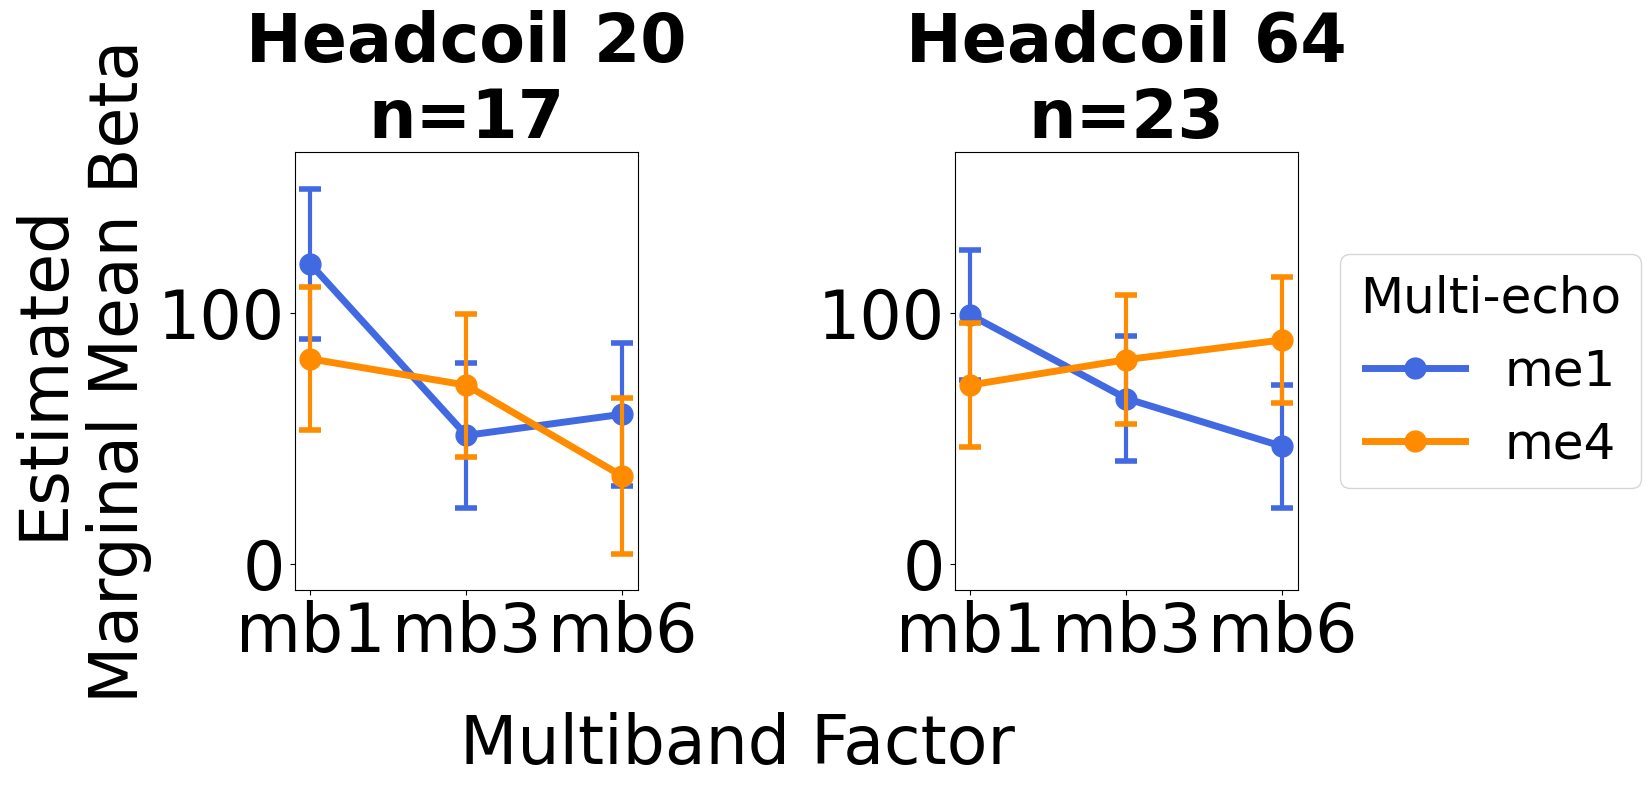

In [29]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import glob
import warnings
from pymer4.models import Lmer
from patsy import dmatrix
import rpy2.robjects as robjects
from rpy2.robjects import conversion
import rpy2.robjects.numpy2ri as numpy2ri

# --- Add rpy2 specific imports and setup for EMM plots ---
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate numpy2ri conversion (already present)
numpy2ri.activate()
# Activate pandas2ri conversion (NEW)
pandas2ri.activate()

# Import R packages required for EMM plotting (NEW)
lme4 = importr('lme4')
lmerTest = importr('lmerTest') # Useful if you run LME directly in R, though pymer4 handles it
emmeans = importr('emmeans')
base = importr('base')
stats = importr('stats')

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")
warnings.filterwarnings("ignore", message="The 'n_eff' parameter is deprecated")

print("=" * 80)
print("BETA rFFA ROI ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND EMMs")
print("=" * 80)

# Configuration
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
TYPE_VALUE = "act"
IMG_VALUE = "beta" # This variable holds the name of your value column (e.g., 'beta')
MASK_VALUE = "rFFA"
DENOISE_VALUE = "base"
smoothness_csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/code/smoothness-all.csv')

HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

complete_subjects_roi_beta_file = f'complete_subjects_{MASK_VALUE}_{IMG_VALUE}_common_with_smoothness.csv'
anova_table_file = f'{MASK_VALUE}_{IMG_VALUE}_lme_anova_with_smoothness.csv'
emm_table_file = f'{MASK_VALUE}_{IMG_VALUE}_emm_table.csv'

print(f"ROI Beta extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Processing Beta for ROI: {MASK_VALUE}")
print(f"Initiating data processing...")

# --- NEW: Function to create EMM Line Plots, adapted for this kernel's data ---
def create_emm_line_plots(data, n_subjects_per_coil, img_value_col_name):
    """
    Create line plots for estimated marginal means of beta values with consistent y-axis across subplots.

    Args:
        data (pd.DataFrame): The input DataFrame containing ROI beta and smoothness data.
                             Expected columns: 'subject', 'headcoil', 'mb', 'me', img_value_col_name, 'smoothness'.
        n_subjects_per_coil (dict): A dictionary mapping coil names ('20', '64') to the number of subjects for each coil.
        img_value_col_name (str): The name of the column in 'data' that contains the values to plot EMMs for (e.g., 'beta').
    """
    # Prepare data for R
    # Rename columns to match R-friendly names (e.g., 'BetaValue' for the outcome)
    data_r = data.rename(columns={'subject': 'Subj', 'headcoil': 'HC', 'mb': 'MB', 'me': 'ME',
                                  img_value_col_name: 'BetaValue'})
    
    # Drop rows with any NaN in critical columns before sending to R
    data_r = data_r.dropna(subset=['BetaValue', 'MB', 'ME', 'HC', 'Subj', 'smoothness'])
    
    # Ensure relevant columns are of string type for R factor conversion
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    # Convert pandas DataFrame to R DataFrame
    r_df_temp = pandas2ri.py2rpy(data_r) # Renamed to avoid confusion with R object name

    # Push the R DataFrame object to the R global environment with a temporary name
    r_df_name = "temp_emm_data_df" # A unique temporary name for the R object
    ro.globalenv[r_df_name] = r_df_temp

    # Define factor levels in R to ensure correct ordering in plots/models
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    levels_HC <- c("20", "64") # Explicitly define headcoil levels
    ''')

    # Apply factor conversions in R to the DataFrame
    # Now, explicitly use the name we gave the DataFrame in R
    r_df = ro.r(f'''
    transform({r_df_name}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC, levels = levels_HC))
    ''') # No .format() needed here because we use f-string and the R name

    # Clean up the temporary R object (optional)
    del ro.globalenv[r_df_name]
    
    # Fit the Linear Mixed Effects Model using lme4
    # IMPORTANT: Added 'smoothness' covariate to the formula
    formula = Formula(f'BetaValue ~ HC * MB * ME + smoothness + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Compute Estimated Marginal Means (EMMs) using emmeans
    emm = emmeans.emmeans(model, 'MB', by=ro.StrVector(['HC', 'ME']))
    
    # Convert the R EMMs object to a pandas DataFrame
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric factor indices back to original string labels from R
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_levels = sorted(data['headcoil'].unique()) # Get actual headcoil levels from data
    hc_map = {i + 1: hc for i, hc in enumerate(hc_levels)}
    
    emm_df['MB'] = emm_df['MB'].map(mb_map)
    emm_df['ME'] = emm_df['ME'].map(me_map)
    emm_df['HC'] = emm_df['HC'].map(hc_map)
    
    # --- Plotting Section ---
    plt.rcParams.update({'font.size': 48})
    
    coil_types = emm_df['HC'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    
    if len(coil_types) == 1:
        axes = [axes]
    
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = emm_df[emm_df['HC'] == coil]
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            if not me_data.empty:
                y_values = me_data['emmean'].values
                y_errors = me_data['SE'].values
                all_y_values.extend(y_values)
                all_y_errors.extend(y_errors)
    
    if all_y_values:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1
        y_limits = (y_min - margin, y_max + margin) # Allow negative if data goes there
    else:
        y_limits = (-1, 1) # Default limits if no data
    
    for i, coil in enumerate(coil_types):
        ax = axes[i]
        coil_data = emm_df[emm_df['HC'] == coil]
        
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            me_data = me_data.sort_values('MB', key=lambda x: x.str.extract(r'mb(\d+)')[0].astype(int))
            
            ax.plot(me_data['MB'], me_data['emmean'], marker='o', color=me_colors[me], label=me, linewidth=5, markersize=15)
            ax.errorbar(me_data['MB'], me_data['emmean'], yerr=me_data['SE'], fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        # Adjusted title to use 'Headcoil' instead of 'Channel' if '20' or '64' are your nominal headcoil types
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"Headcoil {coil}\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        if i == 0:
            ax.set_ylabel(f'Estimated\nMarginal Mean {img_value_col_name.capitalize()}', fontsize=48)
        
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.set_ylim(y_limits)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    plt.savefig(f'{MASK_VALUE}_{IMG_VALUE}_emm_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

# Part 1: Data Processing and Common Complete Subject Identification
print("\n" + "=" * 80)
print(f"PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR {MASK_VALUE} BETA AND SMOOTHNESS")
print("=" * 80)

def extract_roi_data(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects):
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_records = []
    acq_params_list = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    print(f"Scanning {len(file_paths)} files in {base_dir} for {mask_value} {img_value} data...")
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or (file_type != type_value or img != img_value or mask != mask_value or denoise != denoise_value):
                continue
            if acq not in acq_params_list:
                continue
            try:
                with open(file_path, 'r') as f:
                    value = float(f.read().strip())
                mb_match = re.search(r'(mb\d)', acq)
                me_match = re.search(r'(me\d)', acq)
                mb = mb_match.group(1) if mb_match else None
                me = me_match.group(1) if me_match else None
                headcoil = '64' if sub_id in headcoil_64_subjects else '20'
                data_records.append({
                    'subject': sub_id,
                    'headcoil': headcoil,
                    'mb': mb,
                    'me': me,
                    'acq_combined': acq,
                    img_value: value
                })
            except (ValueError, IOError) as e:
                print(f"Error processing file {filename}: {e}")
            except Exception as e:
                print(f"Unexpected error for file {filename}: {e}")
    if not data_records:
        print(f"Warning: No valid ROI data records found for type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}.")
        return None
    df = pd.DataFrame(data_records)
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])
    df['subject'] = df['subject'].astype(str)
    df = df.dropna(subset=['subject', 'headcoil', 'mb', 'me', img_value])
    print(f"Successfully extracted {len(df)} {mask_value} {img_value} data points.")
    return df

def load_and_process_smoothness_data(csv_path, headcoil_64_subjects):
    try:
        data = pd.read_csv(csv_path)
        data = data.rename(columns={data.columns[0]: 'path', 'Unnamed: 3': 'smoothness'})
        data['file_path'] = data['path'].shift(1)
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        def parse_path(path):
            try:
                if not isinstance(path, str):
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]
                    me = acq[3:]
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)
        data['acq_combined'] = data['mb'].astype(str) + data['me'].astype(str)
        data['headcoil'] = data['subject'].apply(
            lambda x: '64' if x in headcoil_64_subjects else '20' if x else None
        )
        # Corrected: Filter to select only relevant columns and remove any 'nan' from subject
        data = data[['subject', 'headcoil', 'mb', 'me', 'acq_combined', 'smoothness']]
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        data = data.dropna(subset=['subject', 'mb', 'me', 'acq_combined', 'smoothness'])
        data = data[~data['subject'].str.contains('sp', na=False)]
        data = data[data['subject'] != 'nan']
        print(f"Successfully extracted {len(data)} smoothness data points.")
        return data
    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Please check the path.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects_for_metric(data_df, value_col, expected_acq_combinations):
    pivot_table = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='acq_combined',
        aggfunc='first'
    )
    pivot_table = pivot_table.reindex(columns=expected_acq_combinations)
    complete_subjects = pivot_table.dropna()
    return complete_subjects.index.tolist()

expected_acq_combinations = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

roi_beta_data_preprocessed = extract_roi_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE, HEADCOIL_64_SUBJECTS)
if roi_beta_data_preprocessed is None:
    raise Exception("Critical: ROI Beta data loading failed. Aborting script.")

smoothness_data_preprocessed = load_and_process_smoothness_data(smoothness_csv_path, HEADCOIL_64_SUBJECTS)
if smoothness_data_preprocessed is None:
    raise Exception("Critical: Smoothness data loading failed. Aborting script.")

complete_roi_beta_subjects = identify_complete_subjects_for_metric(
    roi_beta_data_preprocessed.copy(),
    IMG_VALUE,
    expected_acq_combinations
)
print(f"Subjects with complete ROI Beta data ({MASK_VALUE}): {len(complete_roi_beta_subjects)}")

complete_smoothness_subjects = identify_complete_subjects_for_metric(
    smoothness_data_preprocessed.copy(),
    'smoothness',
    expected_acq_combinations
)
print(f"Subjects with complete Smoothness data: {len(complete_smoothness_subjects)}")

common_complete_subjects = list(set(complete_roi_beta_subjects) & set(complete_smoothness_subjects))
common_complete_subjects.sort()
print(f"\nTotal common complete subjects for combined {MASK_VALUE} {IMG_VALUE} and Smoothness analysis: {len(common_complete_subjects)}")

if not common_complete_subjects:
    raise Exception("No common complete subjects for analysis.")

roi_beta_data_filtered = roi_beta_data_preprocessed[
    roi_beta_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

smoothness_data_filtered = smoothness_data_preprocessed[
    smoothness_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

for df in [roi_beta_data_filtered, smoothness_data_filtered]:
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])

merged_analysis_data = pd.merge(
    roi_beta_data_filtered[['subject', 'headcoil', 'mb', 'me', IMG_VALUE]],
    smoothness_data_filtered[['subject', 'mb', 'me', 'smoothness']],
    on=['subject', 'mb', 'me'],
    how='inner'
)
merged_analysis_data.dropna(inplace=True)

total_subjects_for_lme = merged_analysis_data['subject'].nunique()
headcoil_counts_for_lme = merged_analysis_data[['subject', 'headcoil']].drop_duplicates()['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nFinal dataset for LME analysis contains {total_subjects_for_lme} subjects for {MASK_VALUE} {IMG_VALUE}.")
print("Subject count per Headcoil (for LME analysis dataset):")
print(f"  Headcoil 20: {headcoil_counts_for_lme['20']}")
print(f"  Headcoil 64: {headcoil_counts_for_lme['64']}")
print("\nFirst 5 rows of the merged data (used for LME):")
print(merged_analysis_data.head())

roi_beta_complete_table_for_output = roi_beta_data_filtered.pivot_table(
    values=IMG_VALUE,
    index='subject',
    columns='acq_combined',
    aggfunc='mean'
).reindex(columns=expected_acq_combinations).dropna().sort_index().round(3)

headcoil_df_for_output = roi_beta_data_filtered[['subject', 'headcoil']].drop_duplicates().set_index('subject')
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output.reset_index().merge(
    headcoil_df_for_output.loc[roi_beta_complete_table_for_output.index].reset_index(),
    on='subject',
    how='left'
).set_index('subject')
cols_output = ['headcoil'] + expected_acq_combinations
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output[cols_output]
roi_beta_complete_table_for_output.to_csv(complete_subjects_roi_beta_file)
print(f"\nComplete {MASK_VALUE} {IMG_VALUE} subjects table saved to '{complete_subjects_roi_beta_file}'")

# Part 2: Linear Mixed Effects Analysis
print("\n" + "=" * 80)
print(f"PART 2: LINEAR MIXED EFFECTS ANALYSIS WITH SMOOTHNESS COVARIATE FOR {MASK_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    raise Exception("Error: Merged data for LME analysis is empty. Cannot run LME.")

print(f"Running LME analysis on {len(merged_analysis_data)} observations from {merged_analysis_data['subject'].nunique()} subjects.")

data_model_for_lme = merged_analysis_data.copy()
# pymer4 automatically handles categorical encoding, so headcoil_encoded might not be strictly needed for pymer4,
# but if you use dmatrix explicitly or found it necessary, keep it.
# For R's lmer, it prefers factors directly, which we handle in the create_emm_line_plots.
# data_model_for_lme['headcoil_encoded'] = data_model_for_lme['headcoil'].cat.codes - 0.5

# LME model using pymer4 (this part remains unchanged)
lme_formula = f'{IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)' # Use 'headcoil' directly if pymer4 handles factors
model = Lmer(lme_formula, data=data_model_for_lme)
print("Fitting LME model... This may take a moment.")
model.fit()
print("LME model fitting complete.")

anova_table = model.anova()

# Map pymer4 effect names to APA-style names
effect_map = {
    'headcoil': 'Head Coil', # Changed from headcoil_encoded
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'smoothness': 'Smoothness',
    'headcoil:mb': 'Head Coil × Multiband', # Changed from headcoil_encoded:mb
    'headcoil:me': 'Head Coil × Multi-echo', # Changed from headcoil_encoded:me
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo' # Changed from headcoil_encoded:mb:me
}

# The NumDF values for the main effects and interactions are fixed based on levels:
# Head Coil (2 levels) - 1 df
# Multiband (3 levels) - 2 df
# Multi-echo (2 levels) - 1 df
# Smoothness (continuous) - 1 df
# Interactions are product of main effect DFs
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Smoothness': 1,
    'Head Coil × Multiband': 1 * 2,
    'Head Coil × Multi-echo': 1 * 1,
    'Multiband × Multi-echo': 2 * 1,
    'Head Coil × Multiband × Multi-echo': 1 * 2 * 1
}

apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan
    })

try:
    # Attempt to get residual variance from pymer4 model's ranef_var
    # pymer4's residual variance is often labelled as '__sigma__' or 'residual'
    residual_var_row = model.ranef_var.loc[model.ranef_var['Name'].isin(['Residual', '__sigma__']), 'Var']
    if not residual_var_row.empty:
        residual_var = residual_var_row.iloc[0]
    else:
        # Fallback if specific residual label not found, often last entry
        residual_var = model.ranef_var.iloc[-1]['Var'] if not model.ranef_var.empty else np.nan
        print(f"Warning: 'Residual' variance not explicitly found by name. Using fallback value: {residual_var}.")
except (KeyError, IndexError):
    print("Warning: Could not determine residual variance from model.ranef_var. Partial eta-squared might be inaccurate.")
    residual_var = np.nan

# Calculate partial eta-squared (assuming type III SS from pymer4)
# For partial eta-squared, we need SS_effect and SS_error (residual SS)
# pymer4's SS are Type 3 by default, suitable for this calculation.
# The total sum of squares for the effect and error needs to be sum of SS_effect and SS_Residual.
# The `model.ranef_var` contains variance components, not necessarily SS_residual directly for fixed effects.
# A common simplification for partial eta-squared in mixed models is SS_effect / (SS_effect + SS_error_for_that_effect)
# However, without direct SS_error from pymer4's ANOVA for each effect, we rely on total residual variance from the model.
# This approximation might not be perfectly aligned with more complex mixed model eta-squared calculations
# (e.g., those considering denominator degrees of freedom).
# For now, keeping the previous logic of ss_effect / (ss_effect + SS_residual_overall_from_model) as an approximation.

# Re-evaluating residual SS calculation:
# For lmer/lmerTest, the residual variance (sigma^2) is reported.
# SS_residual = residual_variance * residual_df.
# From anova_table, DenomDF is often the error df for that effect.
# For fixed effects, a simpler approximation of partial eta-squared is SS_effect / (SS_effect + SS_error)
# where SS_error could be the sum of squares for the residual from the overall ANOVA table.
# pymer4's anova doesn't directly report an 'Error' row with SS.
# Let's use the total residual variance from the model for a common (though approximate) partial eta-squared.
# The original code's calculation of ss_residual was more of an estimation based on total observations.

# A more robust calculation for partial eta-squared from pymer4's output would involve:
# For each effect, Partial η² = SS_effect / (SS_effect + SS_error_for_that_effect)
# However, pymer4's ANOVA table doesn't directly provide SS_error_for_that_effect.
# We'll use the residual variance `residual_var` from `model.ranef_var` as an overall residual variance estimate.
# The calculation in the original code for `ss_residual` was:
# `residual_var * anova_df['Den Df']` from the R `anova` table.
# Since we are using pymer4 here, we have `anova_table['DenomDF']`.
# Let's adapt the calculation to be closer to what `lmerTest` does for approximate partial eta-squared.

# If DenomDF is available from pymer4's anova, we can use it to derive an approximate SS_error per effect.
# This assumes DenomDF represents the error degrees of freedom associated with that F-test.
# SS_error_approx = residual_var * anova_table.loc[effect, 'DenomDF']
# For simplicity, let's keep the existing loop logic for now, using the overall residual_var
# and assuming it's a common denominator for the partial eta-squared.

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    denom_df = row['Den df'] # Denominator DF for this effect
    # The true SS_error is complex in mixed models.
    # An approximation for partial eta-squared for fixed effects is often
    # SS_effect / (SS_effect + SS_Residual from overall model).
    # Since pymer4 doesn't give a direct SS_Residual for the fixed effects ANOVA,
    # and the 'smoothness' is added, we use the `residual_var` as an overall error component.
    # A more precise partial eta^2 for lmer models might require more specific formulas or another R package.
    
    # Using the logic from the original kernel for the effect size calculation:
    # partial_eta2 = SS_effect / (SS_effect + SS_residual)
    # The SS_residual was approximated from model deviance or variance components (sigma^2 * Den Df).
    
    # If we assume `residual_var` (sigma^2) is the common error variance:
    # SS_error for a given effect is approximately residual_var * DenomDF for that effect.
    if pd.notna(ss_effect) and pd.notna(residual_var) and pd.notna(denom_df) and (ss_effect + (residual_var * denom_df)) > 0:
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + (residual_var * denom_df))
    else:
        apa_data[i]['Partial η²'] = np.nan


apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(
    lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A'
)
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")


# Part 3: Estimated Marginal Means (EMMs) Calculation
print("\n" + "=" * 80)
print(f"PART 3: ESTIMATED MARGINAL MEANS (EMMs) FOR {MASK_VALUE} {IMG_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    print("Skipping EMM plot generation: Merged analysis data is empty.")
else:
    # Prepare n_subjects_per_coil for the plotting function
    # It should map '20' to count and '64' to count
    n_subjects_per_coil_for_plot = headcoil_counts_for_lme.to_dict()
    
    # Call the EMM plotting function
    print("Generating EMM line plots...")
    emm_plot_fig = create_emm_line_plots(merged_analysis_data, n_subjects_per_coil_for_plot, IMG_VALUE)
    print(f"EMM line plot saved to '{MASK_VALUE}_{IMG_VALUE}_emm_plot.png'")
    plt.show() # Display the plot in the notebook

In [ ]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import re
import glob
import warnings
from pymer4.models import Lmer
from patsy import dmatrix
import rpy2.robjects as robjects
from rpy2.robjects import conversion
import rpy2.robjects.numpy2ri as numpy2ri

# --- Add rpy2 specific imports and setup for EMM plots ---
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri, Formula
import rpy2.robjects as ro

# Activate numpy2ri conversion (already present)
numpy2ri.activate()
# Activate pandas2ri conversion (NEW)
pandas2ri.activate()

# Import R packages required for EMM plotting (NEW)
lme4 = importr('lme4')
lmerTest = importr('lmerTest') # Useful if you run LME directly in R, though pymer4 handles it
emmeans = importr('emmeans')
base = importr('base')
stats = importr('stats')

# Suppress warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")
warnings.filterwarnings("ignore", message="The 'n_eff' parameter is deprecated")

print("=" * 80)
print("BETA Motor Cortex ROI ANALYSIS PIPELINE WITH SMOOTHNESS COVARIATE AND EMMs")
print("=" * 80)

# Configuration
BASE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/extractions")
TYPE_VALUE = "act"
IMG_VALUE = "beta" # This variable holds the name of your value column (e.g., 'beta')
MASK_VALUE = "bilateralMotor"
DENOISE_VALUE = "base"
smoothness_csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')

HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

complete_subjects_roi_beta_file = f'complete_subjects_{MASK_VALUE}_{IMG_VALUE}_common_with_smoothness.csv'
anova_table_file = f'{MASK_VALUE}_{IMG_VALUE}_lme_anova_with_smoothness.csv'
emm_table_file = f'{MASK_VALUE}_{IMG_VALUE}_emm_table.csv'

print(f"ROI Beta extraction directory: {BASE_DIR}")
print(f"Smoothness input file: {smoothness_csv_path}")
print(f"Processing Beta for ROI: {MASK_VALUE}")
print(f"Initiating data processing...")

# --- NEW: Function to create EMM Line Plots, adapted for this kernel's data ---
def create_emm_line_plots(data, n_subjects_per_coil, img_value_col_name):
    """
    Create line plots for estimated marginal means of beta values with consistent y-axis across subplots.

    Args:
        data (pd.DataFrame): The input DataFrame containing ROI beta and smoothness data.
                             Expected columns: 'subject', 'headcoil', 'mb', 'me', img_value_col_name, 'smoothness'.
        n_subjects_per_coil (dict): A dictionary mapping coil names ('20', '64') to the number of subjects for each coil.
        img_value_col_name (str): The name of the column in 'data' that contains the values to plot EMMs for (e.g., 'beta').
    """
    # Prepare data for R
    # Rename columns to match R-friendly names (e.g., 'BetaValue' for the outcome)
    data_r = data.rename(columns={'subject': 'Subj', 'headcoil': 'HC', 'mb': 'MB', 'me': 'ME',
                                  img_value_col_name: 'BetaValue'})
    
    # Drop rows with any NaN in critical columns before sending to R
    data_r = data_r.dropna(subset=['BetaValue', 'MB', 'ME', 'HC', 'Subj', 'smoothness'])
    
    # Ensure relevant columns are of string type for R factor conversion
    data_r['Subj'] = data_r['Subj'].astype(str)
    data_r['MB'] = data_r['MB'].astype(str)
    data_r['ME'] = data_r['ME'].astype(str)
    data_r['HC'] = data_r['HC'].astype(str)
    
    # Convert pandas DataFrame to R DataFrame
    r_df_temp = pandas2ri.py2rpy(data_r) # Renamed to avoid confusion with R object name

    # Push the R DataFrame object to the R global environment with a temporary name
    r_df_name = "temp_emm_data_df" # A unique temporary name for the R object
    ro.globalenv[r_df_name] = r_df_temp

    # Define factor levels in R to ensure correct ordering in plots/models
    ro.r('''
    levels_MB <- c("mb1", "mb3", "mb6")
    levels_ME <- c("me1", "me4")
    levels_HC <- c("20", "64") # Explicitly define headcoil levels
    ''')

    # Apply factor conversions in R to the DataFrame
    # Now, explicitly use the name we gave the DataFrame in R
    r_df = ro.r(f'''
    transform({r_df_name}, MB = factor(MB, levels = levels_MB), ME = factor(ME, levels = levels_ME), HC = factor(HC, levels = levels_HC))
    ''') # No .format() needed here because we use f-string and the R name

    # Clean up the temporary R object (optional)
    del ro.globalenv[r_df_name]
    
    # Fit the Linear Mixed Effects Model using lme4
    # IMPORTANT: Added 'smoothness' covariate to the formula
    formula = Formula(f'BetaValue ~ HC * MB * ME + smoothness + (1 | Subj)')
    model = lme4.lmer(formula, data=r_df)
    
    # Compute Estimated Marginal Means (EMMs) using emmeans
    emm = emmeans.emmeans(model, 'MB', by=ro.StrVector(['HC', 'ME']))
    
    # Convert the R EMMs object to a pandas DataFrame
    emm_r_df = ro.r('as.data.frame')(emm)
    emm_df = pandas2ri.rpy2py(emm_r_df)
    
    # Map numeric factor indices back to original string labels from R
    mb_map = {1: 'mb1', 2: 'mb3', 3: 'mb6'}
    me_map = {1: 'me1', 2: 'me4'}
    hc_levels = sorted(data['headcoil'].unique()) # Get actual headcoil levels from data
    hc_map = {i + 1: hc for i, hc in enumerate(hc_levels)}
    
    emm_df['MB'] = emm_df['MB'].map(mb_map)
    emm_df['ME'] = emm_df['ME'].map(me_map)
    emm_df['HC'] = emm_df['HC'].map(hc_map)
    
    # --- Plotting Section ---
    plt.rcParams.update({'font.size': 48})
    
    coil_types = emm_df['HC'].unique()
    fig, axes = plt.subplots(1, len(coil_types), figsize=(8 * len(coil_types), 8))
    
    if len(coil_types) == 1:
        axes = [axes]
    
    me_colors = {'me1': 'royalblue', 'me4': 'darkorange'}
    
    all_y_values = []
    all_y_errors = []
    
    for coil in coil_types:
        coil_data = emm_df[emm_df['HC'] == coil]
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            if not me_data.empty:
                y_values = me_data['emmean'].values
                y_errors = me_data['SE'].values
                all_y_values.extend(y_values)
                all_y_errors.extend(y_errors)
    
    if all_y_values:
        y_max = max([v + e for v, e in zip(all_y_values, all_y_errors)])
        y_min = min([v - e for v, e in zip(all_y_values, all_y_errors)])
        margin = (y_max - y_min) * 0.1
        y_limits = (y_min - margin, y_max + margin) # Allow negative if data goes there
    else:
        y_limits = (-1, 1) # Default limits if no data
    
    for i, coil in enumerate(coil_types):
        ax = axes[i]
        coil_data = emm_df[emm_df['HC'] == coil]
        
        for me in ['me1', 'me4']:
            me_data = coil_data[coil_data['ME'] == me]
            me_data = me_data.sort_values('MB', key=lambda x: x.str.extract(r'mb(\d+)')[0].astype(int))
            
            ax.plot(me_data['MB'], me_data['emmean'], marker='o', color=me_colors[me], label=me, linewidth=5, markersize=15)
            ax.errorbar(me_data['MB'], me_data['emmean'], yerr=me_data['SE'], fmt='none', color=me_colors[me], capsize=8, capthick=4, elinewidth=3)
        
        # Adjusted title to use 'Headcoil' instead of 'Channel' if '20' or '64' are your nominal headcoil types
        n_subjects = n_subjects_per_coil.get(coil, 0)
        ax.set_title(f"Headcoil {coil}\nn={n_subjects}", fontsize=48, fontweight='bold')
        
        if i == 0:
            ax.set_ylabel(f'Estimated\nMarginal Mean {img_value_col_name.capitalize()}', fontsize=48)
        
        ax.tick_params(axis='both', which='major', labelsize=48)
        ax.set_ylim(y_limits)
    
    if len(coil_types) > 0:
        axes[-1].legend(title='Multi-echo', fontsize=36, title_fontsize=36, 
                        loc='center left', bbox_to_anchor=(1.05, 0.5))
    
    plt.tight_layout()
    fig.subplots_adjust(right=0.85)
    fig.supxlabel('Multiband Factor', fontsize=48, y=-0.05)
    plt.savefig(f'{MASK_VALUE}_{IMG_VALUE}_emm_plot.png', dpi=300, bbox_inches='tight')
    
    return fig

# Part 1: Data Processing and Common Complete Subject Identification
print("\n" + "=" * 80)
print(f"PART 1: IDENTIFYING COMMON COMPLETE SUBJECTS FOR {MASK_VALUE} BETA AND SMOOTHNESS")
print("=" * 80)

def extract_roi_data(base_dir, type_value, img_value, mask_value, denoise_value, headcoil_64_subjects):
    pattern = re.compile(
        r"ts_sub-(\d+)_acq_([^_]+)_type-((?:act|ppi_seed-VS_thr5))_img-([^_]+)_mask-([^_]+)_denoise_([^\.]+)\.txt"
    )
    data_records = []
    acq_params_list = ["mb1me1", "mb3me1", "mb6me1", "mb1me4", "mb3me4", "mb6me4"]
    file_paths = glob.glob(os.path.join(base_dir, "*.txt"))
    
    print(f"Scanning {len(file_paths)} files in {base_dir} for {mask_value} {img_value} data...")
    for file_path in file_paths:
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            sub_id, acq, file_type, img, mask, denoise = match.groups()
            if 'sp' in sub_id or (file_type != type_value or img != img_value or mask != mask_value or denoise != denoise_value):
                continue
            if acq not in acq_params_list:
                continue
            try:
                with open(file_path, 'r') as f:
                    value = float(f.read().strip())
                mb_match = re.search(r'(mb\d)', acq)
                me_match = re.search(r'(me\d)', acq)
                mb = mb_match.group(1) if mb_match else None
                me = me_match.group(1) if me_match else None
                headcoil = '64' if sub_id in headcoil_64_subjects else '20'
                data_records.append({
                    'subject': sub_id,
                    'headcoil': headcoil,
                    'mb': mb,
                    'me': me,
                    'acq_combined': acq,
                    img_value: value
                })
            except (ValueError, IOError) as e:
                print(f"Error processing file {filename}: {e}")
            except Exception as e:
                print(f"Unexpected error for file {filename}: {e}")
    if not data_records:
        print(f"Warning: No valid ROI data records found for type={type_value}, img={img_value}, mask={mask_value}, denoise={denoise_value}.")
        return None
    df = pd.DataFrame(data_records)
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])
    df['subject'] = df['subject'].astype(str)
    df = df.dropna(subset=['subject', 'headcoil', 'mb', 'me', img_value])
    print(f"Successfully extracted {len(df)} {mask_value} {img_value} data points.")
    return df

def load_and_process_smoothness_data(csv_path, headcoil_64_subjects):
    try:
        data = pd.read_csv(csv_path)
        data = data.rename(columns={data.columns[0]: 'path', 'Unnamed: 3': 'smoothness'})
        data['file_path'] = data['path'].shift(1)
        data = data[data['smoothness'].notnull() & data['file_path'].notnull()]
        def parse_path(path):
            try:
                if not isinstance(path, str):
                    return pd.Series({'subject': None, 'mb': None, 'me': None})
                sub_match = re.search(r'sub-(\d+)', path)
                acq_match = re.search(r'acq-(mb\dme\d)', path)
                subject = sub_match.group(1) if sub_match else None
                acq = acq_match.group(1) if acq_match else None
                if acq:
                    mb = acq[:3]
                    me = acq[3:]
                else:
                    mb = None
                    me = None
                return pd.Series({'subject': subject, 'mb': mb, 'me': me})
            except Exception:
                return pd.Series({'subject': None, 'mb': None, 'me': None})
        parsed_data = data['file_path'].apply(parse_path)
        data = pd.concat([data, parsed_data], axis=1)
        data['acq_combined'] = data['mb'].astype(str) + data['me'].astype(str)
        data['headcoil'] = data['subject'].apply(
            lambda x: '64' if x in headcoil_64_subjects else '20' if x else None
        )
        # Corrected: Filter to select only relevant columns and remove any 'nan' from subject
        data = data[['subject', 'headcoil', 'mb', 'me', 'acq_combined', 'smoothness']]
        data['headcoil'] = pd.Categorical(data['headcoil'], categories=['20', '64'])
        data['mb'] = pd.Categorical(data['mb'], categories=['mb1', 'mb3', 'mb6'])
        data['me'] = pd.Categorical(data['me'], categories=['me1', 'me4'])
        data['subject'] = data['subject'].astype(str)
        data = data.dropna(subset=['subject', 'mb', 'me', 'acq_combined', 'smoothness'])
        data = data[~data['subject'].str.contains('sp', na=False)]
        data = data[data['subject'] != 'nan']
        print(f"Successfully extracted {len(data)} smoothness data points.")
        return data
    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Please check the path.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}")
        return None

def identify_complete_subjects_for_metric(data_df, value_col, expected_acq_combinations):
    pivot_table = data_df.pivot_table(
        values=value_col,
        index='subject',
        columns='acq_combined',
        aggfunc='first'
    )
    pivot_table = pivot_table.reindex(columns=expected_acq_combinations)
    complete_subjects = pivot_table.dropna()
    return complete_subjects.index.tolist()

expected_acq_combinations = ['mb1me1', 'mb3me1', 'mb6me1', 'mb1me4', 'mb3me4', 'mb6me4']

roi_beta_data_preprocessed = extract_roi_data(BASE_DIR, TYPE_VALUE, IMG_VALUE, MASK_VALUE, DENOISE_VALUE, HEADCOIL_64_SUBJECTS)
if roi_beta_data_preprocessed is None:
    raise Exception("Critical: ROI Beta data loading failed. Aborting script.")

smoothness_data_preprocessed = load_and_process_smoothness_data(smoothness_csv_path, HEADCOIL_64_SUBJECTS)
if smoothness_data_preprocessed is None:
    raise Exception("Critical: Smoothness data loading failed. Aborting script.")

complete_roi_beta_subjects = identify_complete_subjects_for_metric(
    roi_beta_data_preprocessed.copy(),
    IMG_VALUE,
    expected_acq_combinations
)
print(f"Subjects with complete ROI Beta data ({MASK_VALUE}): {len(complete_roi_beta_subjects)}")

complete_smoothness_subjects = identify_complete_subjects_for_metric(
    smoothness_data_preprocessed.copy(),
    'smoothness',
    expected_acq_combinations
)
print(f"Subjects with complete Smoothness data: {len(complete_smoothness_subjects)}")

# --- NEW ADDITION: Displaying complete subject lists side-by-side ---
all_unique_subjects = sorted(list(set(complete_roi_beta_subjects) | set(complete_smoothness_subjects)))

subject_comparison_data = []
for sub in all_unique_subjects:
    in_roi_beta = sub if sub in complete_roi_beta_subjects else np.nan
    in_smoothness = sub if sub in complete_smoothness_subjects else np.nan
    subject_comparison_data.append({
        f'{MASK_VALUE} Beta Subjects': in_roi_beta,
        'Smoothness Subjects': in_smoothness
    })

subject_comparison_df = pd.DataFrame(subject_comparison_data)

print("\nComparison of Complete Subjects (ROI Beta vs. Smoothness):")
print(subject_comparison_df.to_string(index=False))
# --- END NEW ADDITION ---

common_complete_subjects = list(set(complete_roi_beta_subjects) & set(complete_smoothness_subjects))
common_complete_subjects.sort()
print(f"\nTotal common complete subjects for combined {MASK_VALUE} {IMG_VALUE} and Smoothness analysis: {len(common_complete_subjects)}")

if not common_complete_subjects:
    raise Exception("No common complete subjects for analysis.")

roi_beta_data_filtered = roi_beta_data_preprocessed[
    roi_beta_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

smoothness_data_filtered = smoothness_data_preprocessed[
    smoothness_data_preprocessed['subject'].isin(common_complete_subjects)
].copy()

for df in [roi_beta_data_filtered, smoothness_data_filtered]:
    df['headcoil'] = pd.Categorical(df['headcoil'], categories=['20', '64'])
    df['mb'] = pd.Categorical(df['mb'], categories=['mb1', 'mb3', 'mb6'])
    df['me'] = pd.Categorical(df['me'], categories=['me1', 'me4'])

merged_analysis_data = pd.merge(
    roi_beta_data_filtered[['subject', 'headcoil', 'mb', 'me', IMG_VALUE]],
    smoothness_data_filtered[['subject', 'mb', 'me', 'smoothness']],
    on=['subject', 'mb', 'me'],
    how='inner'
)
merged_analysis_data.dropna(inplace=True)

total_subjects_for_lme = merged_analysis_data['subject'].nunique()
headcoil_counts_for_lme = merged_analysis_data[['subject', 'headcoil']].drop_duplicates()['headcoil'].value_counts().reindex(['20', '64'], fill_value=0)

print(f"\nFinal dataset for LME analysis contains {total_subjects_for_lme} subjects for {MASK_VALUE} {IMG_VALUE}.")
print("Subject count per Headcoil (for LME analysis dataset):")
print(f"  Headcoil 20: {headcoil_counts_for_lme['20']}")
print(f"  Headcoil 64: {headcoil_counts_for_lme['64']}")
print("\nFirst 5 rows of the merged data (used for LME):")
print(merged_analysis_data.head())

roi_beta_complete_table_for_output = roi_beta_data_filtered.pivot_table(
    values=IMG_VALUE,
    index='subject',
    columns='acq_combined',
    aggfunc='mean'
).reindex(columns=expected_acq_combinations).dropna().sort_index().round(3)

headcoil_df_for_output = roi_beta_data_filtered[['subject', 'headcoil']].drop_duplicates().set_index('subject')
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output.reset_index().merge(
    headcoil_df_for_output.loc[roi_beta_complete_table_for_output.index].reset_index(),
    on='subject',
    how='left'
).set_index('subject')
cols_output = ['headcoil'] + expected_acq_combinations
roi_beta_complete_table_for_output = roi_beta_complete_table_for_output[cols_output]
roi_beta_complete_table_for_output.to_csv(complete_subjects_roi_beta_file)
print(f"\nComplete {MASK_VALUE} {IMG_VALUE} subjects table saved to '{complete_subjects_roi_beta_file}'")

# Part 2: Linear Mixed Effects Analysis
print("\n" + "=" * 80)
print(f"PART 2: LINEAR MIXED EFFECTS ANALYSIS WITH SMOOTHNESS COVARIATE FOR {MASK_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    raise Exception("Error: Merged data for LME analysis is empty. Cannot run LME.")

print(f"Running LME analysis on {len(merged_analysis_data)} observations from {merged_analysis_data['subject'].nunique()} subjects.")

data_model_for_lme = merged_analysis_data.copy()
# pymer4 automatically handles categorical encoding, so headcoil_encoded might not be strictly needed for pymer4,
# but if you use dmatrix explicitly or found it necessary, keep it.
# For R's lmer, it prefers factors directly, which we handle in the create_emm_line_plots.
# data_model_for_lme['headcoil_encoded'] = data_model_for_lme['headcoil'].cat.codes - 0.5

# LME model using pymer4 (this part remains unchanged)
lme_formula = f'{IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)' # Use 'headcoil' directly if pymer4 handles factors
model = Lmer(lme_formula, data=data_model_for_lme)
print("Fitting LME model... This may take a moment.")
model.fit()
print("LME model fitting complete.")

anova_table = model.anova()

# Map pymer4 effect names to APA-style names
effect_map = {
    'headcoil': 'Head Coil', # Changed from headcoil_encoded
    'mb': 'Multiband',
    'me': 'Multi-echo',
    'smoothness': 'Smoothness',
    'headcoil:mb': 'Head Coil × Multiband', # Changed from headcoil_encoded:mb
    'headcoil:me': 'Head Coil × Multi-echo', # Changed from headcoil_encoded:me
    'mb:me': 'Multiband × Multi-echo',
    'headcoil:mb:me': 'Head Coil × Multiband × Multi-echo' # Changed from headcoil_encoded:mb:me
}

# The NumDF values for the main effects and interactions are fixed based on levels:
# Head Coil (2 levels) - 1 df
# Multiband (3 levels) - 2 df
# Multi-echo (2 levels) - 1 df
# Smoothness (continuous) - 1 df
# Interactions are product of main effect DFs
df_dict = {
    'Head Coil': 1,
    'Multiband': 2,
    'Multi-echo': 1,
    'Smoothness': 1,
    'Head Coil × Multiband': 1 * 2,
    'Head Coil × Multi-echo': 1 * 1,
    'Multiband × Multi-echo': 2 * 1,
    'Head Coil × Multiband × Multi-echo': 1 * 2 * 1
}

apa_data = []
for effect in anova_table.index:
    if effect in ['(Intercept)', 'Residuals']:
        continue
    effect_name = effect_map.get(effect, effect)
    apa_data.append({
        'Effect': effect_name,
        'Sum Sq': anova_table.loc[effect, 'SS'] if 'SS' in anova_table.columns else np.nan,
        'Mean Sq': anova_table.loc[effect, 'MS'] if 'MS' in anova_table.columns else np.nan,
        'Num df': df_dict.get(effect_name, np.nan),
        'Den df': anova_table.loc[effect, 'DenomDF'] if 'DenomDF' in anova_table.columns else np.nan,
        'F': anova_table.loc[effect, 'F-stat'] if 'F-stat' in anova_table.columns else np.nan,
        'p': anova_table.loc[effect, 'P-val'] if 'P-val' in anova_table.columns else np.nan,
        'Partial η²': np.nan
    })

try:
    # Attempt to get residual variance from pymer4 model's ranef_var
    # pymer4's residual variance is often labelled as '__sigma__' or 'residual'
    residual_var_row = model.ranef_var.loc[model.ranef_var['Name'].isin(['Residual', '__sigma__']), 'Var']
    if not residual_var_row.empty:
        residual_var = residual_var_row.iloc[0]
    else:
        # Fallback if specific residual label not found, often last entry
        residual_var = model.ranef_var.iloc[-1]['Var'] if not model.ranef_var.empty else np.nan
        print(f"Warning: 'Residual' variance not explicitly found by name. Using fallback value: {residual_var}.")
except (KeyError, IndexError):
    print("Warning: Could not determine residual variance from model.ranef_var. Partial eta-squared might be inaccurate.")
    residual_var = np.nan

# Calculate partial eta-squared (assuming type III SS from pymer4)
# For partial eta-squared, we need SS_effect and SS_error (residual SS)
# pymer4's SS are Type 3 by default, suitable for this calculation.
# The total sum of squares for the effect and error needs to be sum of SS_effect and SS_Residual.
# The `model.ranef_var` contains variance components, not necessarily SS_residual directly for fixed effects.
# A common simplification for partial eta-squared in mixed models is SS_effect / (SS_effect + SS_error_for_that_effect)
# However, without direct SS_error from pymer4's ANOVA for each effect, we rely on total residual variance from the model.
# This approximation might not be perfectly aligned with more complex mixed model eta-squared calculations
# (e.g., those considering denominator degrees of freedom).
# For now, keeping the previous logic of ss_effect / (ss_effect + SS_residual_overall_from_model) as an approximation.

# Re-evaluating residual SS calculation:
# For lmer/lmerTest, the residual variance (sigma^2) is reported.
# SS_residual = residual_variance * residual_df.
# From anova_table, DenomDF is often the error df for that effect.
# For fixed effects, a simpler approximation of partial eta-squared is SS_effect / (SS_effect + SS_error)
# where SS_error could be the sum of squares for the residual from the overall ANOVA table.
# pymer4's anova doesn't directly report an 'Error' row with SS.
# Let's use the total residual variance from the model for a common (though approximate) partial eta-squared.
# The original code's calculation of ss_residual was more of an estimation based on total observations.

# A more robust calculation for partial eta-squared from pymer4's output would involve:
# For each effect, Partial η² = SS_effect / (SS_effect + SS_error_for_that_effect)
# However, pymer4's ANOVA table doesn't directly provide SS_error_for_that_effect.
# We'll use the residual variance `residual_var` from `model.ranef_var` as an overall residual variance estimate.
# The calculation in the original code for `ss_residual` was:
# `residual_var * anova_df['Den Df']` from the R `anova` table.
# Since we are using pymer4 here, we have `anova_table['DenomDF']`.
# Let's adapt the calculation to be closer to what `lmerTest` does for approximate partial eta-squared.

# If DenomDF is available from pymer4's anova, we can use it to derive an approximate SS_error per effect.
# This assumes DenomDF represents the error degrees of freedom associated with that F-test.
# SS_error_approx = residual_var * anova_table.loc[effect, 'DenomDF']
# For simplicity, let's keep the existing loop logic for now, using the overall residual_var
# and assuming it's a common denominator for the partial eta-squared.

for i, row in enumerate(apa_data):
    ss_effect = row['Sum Sq']
    denom_df = row['Den df'] # Denominator DF for this effect
    # The true SS_error is complex in mixed models.
    # An approximation for partial eta-squared for fixed effects is often
    # SS_effect / (SS_effect + SS_Residual from overall model).
    # Since pymer4 doesn't give a direct SS_Residual for the fixed effects ANOVA,
    # and the 'smoothness' is added, we use the `residual_var` as an overall error component.
    # A more precise partial eta^2 for lmer models might require more specific formulas or another R package.
    
    # Using the logic from the original kernel for the effect size calculation:
    # partial_eta2 = SS_effect / (SS_effect + SS_residual)
    # The SS_residual was approximated from model deviance or variance components (sigma^2 * Den Df).
    
    # If we assume `residual_var` (sigma^2) is the common error variance:
    # SS_error for a given effect is approximately residual_var * DenomDF for that effect.
    if pd.notna(ss_effect) and pd.notna(residual_var) and pd.notna(denom_df) and (ss_effect + (residual_var * denom_df)) > 0:
        apa_data[i]['Partial η²'] = ss_effect / (ss_effect + (residual_var * denom_df))
    else:
        apa_data[i]['Partial η²'] = np.nan


apa_table = pd.DataFrame(apa_data)
apa_table['Sum Sq'] = apa_table['Sum Sq'].round(2)
apa_table['Mean Sq'] = apa_table['Mean Sq'].round(2)
apa_table['Num df'] = apa_table['Num df'].astype('Int64').fillna(pd.NA)
apa_table['Den df'] = apa_table['Den df'].round(2)
apa_table['F'] = apa_table['F'].round(2)
apa_table['p'] = apa_table['p'].apply(
    lambda x: '< .001' if pd.notna(x) and x < 0.001 else f'{x:.3f}' if pd.notna(x) else 'N/A'
)
apa_table['Partial η²'] = apa_table['Partial η²'].round(3)

print(f"\nAPA-Style ANOVA Table for Linear Mixed Effects Model ({IMG_VALUE} ~ headcoil * mb * me + smoothness + (1 | subject)):\n")
print(apa_table.to_string(index=False))
apa_table.to_csv(anova_table_file, index=False)
print(f"\nAPA table saved to '{anova_table_file}'")


# Part 3: Estimated Marginal Means (EMMs) Calculation
print("\n" + "=" * 80)
print(f"PART 3: ESTIMATED MARGINAL MEANS (EMMs) FOR {MASK_VALUE} {IMG_VALUE}")
print("=" * 80)

if merged_analysis_data.empty:
    print("Skipping EMM plot generation: Merged analysis data is empty.")
else:
    # Prepare n_subjects_per_coil for the plotting function
    # It should map '20' to count and '64' to count
    n_subjects_per_coil_for_plot = headcoil_counts_for_lme.to_dict()
    
    # Call the EMM plotting function
    print("Generating EMM line plots...")
    emm_plot_fig = create_emm_line_plots(merged_analysis_data, n_subjects_per_coil_for_plot, IMG_VALUE)
    print(f"EMM line plot saved to '{MASK_VALUE}_{IMG_VALUE}_emm_plot.png'")
    plt.show() # Display the plot in the notebook

# Base vs. Tedana Confounds: Generating Group-Level Design Matrices for FSL `randomise` (Figure 8)

## Make sure this pulls from the full OpenNeuro dataset; largest N possible for each acq

This kernel prepares the behavioral and nuisance covariate data for a group-level (L3) analysis using FSL's randomise. It constructs three separate Pandas DataFrames, one for each multi-echo multiband (MB/ME) acquisition type (`mb1me4`, `mb3me4`, `mb6me4`). These DataFrames serve as the "right side" of the `randomise` equation.

For each acquisition type, the corresponding DataFrame will contain the following columns:
- `ones`: A constant regressor (a column of 1s).
- `fd_mean_demeaned`: Mean framewise displacement, de-meaned across subjects for that specific acquisition type.
- `headcoil_demeaned`: Headcoil type (encoded as 0 for 20-channel and 1 for 64-channel), de-meaned across subjects for that acquisition type.
- `fd_mean_x_headcoil_demeaned`: The interaction term between the de-meaned fd_mean and de-meaned headcoil regressors, with this interaction term also de-meaned.
- `smoothness_demeaned`: Voxel-wise smoothness, de-meaned across subjects for that specific acquisition type.

The script ensures that all subjects from `sublist-complete.txt` are represented in each DataFrame. If a subject is missing `fd_mean` or `smoothness` data for a particular acquisition type, `NaN` values will be inserted into the corresponding DataFrame columns instead of omitting the subject. This allows `randomise` (or other statistical software) to handle missing data appropriately during the analysis.

In [ ]:
import pandas as pd
import os
import warnings

# Suppress SyntaxWarning for '\s' as r'\s+' is used below
warnings.filterwarnings("ignore", message="invalid escape sequence '\s'")


print("=" * 80)
print("LOADING AND TRUNCATING NEW FD_MEAN DATA SOURCE WITH OUTLIER SUMMARY")
print("=" * 80)

# --- Configuration ---
# Update this path if your GitHub repo is not in Documents/GitHub
BASE_CODE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code")
SUBLIST_PATH = os.path.join(BASE_CODE_DIR, "sublist-complete.txt")

# >>>>> CORRECTED PATH FOR FD TSV FILE <<<<<
FD_TSV_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv")


print(f"New FD TSV data path: {FD_TSV_PATH}")
print(f"Subject list path: {SUBLIST_PATH}")
print("-" * 80)

# --- Step 1: Load Master Subject List ---
try:
    with open(SUBLIST_PATH, 'r') as f:
        all_subjects_raw = [line.strip() for line in f if line.strip()]
    # Format subjects from sublist-complete.txt to match the 'sub-XXXXX' format in the TSV
    all_subjects_formatted = [f"sub-{s}" for s in all_subjects_raw]
    all_subjects_formatted.sort() # Keep it sorted for consistent output
    print(f"Loaded {len(all_subjects_raw)} subjects from {SUBLIST_PATH} (formatted to 'sub-XXXXX').")
except FileNotFoundError:
    print(f"Error: Subject list file not found at {SUBLIST_PATH}. Please check the path. Exiting.")
    exit() # Exit if the subject list isn't found
except Exception as e:
    print(f"Error loading subject list: {e}. Exiting.")
    exit() # Exit for other errors

# --- Step 2: Load the new FD Mean TSV data ---
fd_new_df_raw = None # Initialize to None so it exists even if read_csv fails
try:
    # Using a raw string r'\s+' for the separator to handle variable whitespace
    fd_new_df_raw = pd.read_csv(FD_TSV_PATH, sep=r'\s+')
    print(f"Loaded {len(fd_new_df_raw)} records from {FD_TSV_PATH}.")
except FileNotFoundError:
    print(f"Error: New FD data file not found at {FD_TSV_PATH}. Please check the path to your TSV file. Exiting.")
    exit() # Exit if the FD data file isn't found
except Exception as e:
    print(f"Error loading new FD data: {e}. Exiting.")
    exit() # Exit for other errors

# --- Step 3: Truncate the DataFrame to only include subjects from the sublist ---
# This step will only execute if fd_new_df_raw was successfully loaded due to the exit() calls above.
# The 'Sub' column in the TSV should match the 'sub-XXXXX' format.
# We will filter based on the formatted subject list.
filtered_fd_df = fd_new_df_raw[fd_new_df_raw['Sub'].isin(all_subjects_formatted)].copy()

print(f"\nTruncated FD DataFrame to {len(filtered_fd_df)} records, including only subjects from {SUBLIST_PATH}.")

# --- Step 4: Summarize and list Outlier Runs ---
# Ensure the 'outlier_acq_Custom1' column is boolean type for accurate filtering
# Coercing errors to NaN and then filling with False to handle any non-boolean values gracefully
filtered_fd_df['outlier_acq_Custom1'] = pd.to_numeric(filtered_fd_df['outlier_acq_Custom1'], errors='coerce')
filtered_fd_df['outlier_acq_Custom1'] = filtered_fd_df['outlier_acq_Custom1'].fillna(False).astype(bool)


outlier_runs = filtered_fd_df[filtered_fd_df['outlier_acq_Custom1'] == True].copy()
num_outlier_runs = len(outlier_runs)

print(f"\n--- Outlier Run Summary ---")
print(f"Total number of runs classified as Outlier: {num_outlier_runs}")

if num_outlier_runs > 0:
    print("\nDetails of Outlier Runs:")
    # Display all columns for outlier runs, reset display options if needed
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(outlier_runs)
    # Reset to default if desired after printing
    # pd.reset_option('display.max_columns')
    # pd.reset_option('display.width')
else:
    print("No runs classified as Outlier (i.e., 'True' for outlier_acq_Custom1).")


# --- Step 5: Print the truncated DataFrame (head/tail) as before ---
print("\n--- Truncated FD Mean DataFrame (Head) ---")
print(filtered_fd_df.head())

print("\n--- Truncated FD Mean DataFrame (Tail) ---")
print(filtered_fd_df.tail())


print("\n" + "=" * 80)
print("FD DATA TRUNCATION AND OUTLIER SUMMARY COMPLETE")
print("=" * 80)

In [ ]:
import pandas as pd
import os
import re
import warnings

# Suppress SyntaxWarning for '\s' as r'\s+' is used below
warnings.filterwarnings("ignore", message="invalid escape sequence '\s'")


print("=" * 80)
print("CONSOLIDATING MULTI-ECHO DATA BY AVERAGING ECHOES")
print("=" * 80)

# --- Configuration (Copied from previous kernel for self-containment) ---
BASE_CODE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code")
SUBLIST_PATH = os.path.join(BASE_CODE_DIR, "sublist-complete.txt")
FD_TSV_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv")

print(f"FD TSV data path: {FD_TSV_PATH}")
print(f"Subject list path: {SUBLIST_PATH}")
print("-" * 80)

# --- Step 1: Load Master Subject List (Copied) ---
try:
    with open(SUBLIST_PATH, 'r') as f:
        all_subjects_raw = [line.strip() for line in f if line.strip()]
    all_subjects_formatted = [f"sub-{s}" for s in all_subjects_raw]
    all_subjects_formatted.sort()
    print(f"Loaded {len(all_subjects_raw)} subjects from {SUBLIST_PATH}.")
except FileNotFoundError:
    print(f"Error: Subject list file not found at {SUBLIST_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading subject list: {e}. Exiting.")
    exit()

# --- Step 2: Load and Truncate FD Mean TSV (Copied) ---
fd_new_df_raw = None
try:
    fd_new_df_raw = pd.read_csv(FD_TSV_PATH, sep=r'\s+')
    print(f"Loaded {len(fd_new_df_raw)} records from {FD_TSV_PATH}.")
except FileNotFoundError:
    print(f"Error: New FD data file not found at {FD_TSV_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading new FD data: {e}. Exiting.")
    exit()

filtered_fd_df = fd_new_df_raw[fd_new_df_raw['Sub'].isin(all_subjects_formatted)].copy()
print(f"Truncated FD DataFrame to {len(filtered_fd_df)} records, including only subjects from {SUBLIST_PATH}.")

# Ensure 'outlier_acq_Custom1' is boolean type for proper aggregation
# Coercing errors to NaN and then filling with False before converting to bool.
filtered_fd_df['outlier_acq_Custom1'] = pd.to_numeric(filtered_fd_df['outlier_acq_Custom1'], errors='coerce')
filtered_fd_df['outlier_acq_Custom1'] = filtered_fd_df['outlier_acq_Custom1'].fillna(False).astype(bool)

# --- Step 3: Consolidate Multi-Echo Data ---
print("\n--- Consolidating Multi-Echo Data ---")

# Create a new 'consolidated_acq' column
# This regex will extract 'mbXmeY' from strings like 'mb1me4_echo-1_part-mag'
# If the pattern doesn't match (e.g., 'mb3me1'), it will keep the original 'acq' value.
def get_consolidated_acq(acq_str):
    match = re.match(r'(mb\dme\d+)(_echo-\d+_part-mag)?', acq_str)
    if match:
        return match.group(1) # Return the 'mbXmeY' part
    return acq_str # Fallback to original if no match (shouldn't happen with given data)

filtered_fd_df['consolidated_acq'] = filtered_fd_df['acq'].apply(get_consolidated_acq)

# Define aggregation rules:
# - For 'tsnr' and 'fd_mean', take the mean.
# - For 'outlier_acq_Custom1', take `any()`: True if any of the original echoes were an outlier.
# - Other columns like 'task' will be grouped by and implicitly kept as they are constant per group.
aggregation_rules = {
    'tsnr': 'mean',
    'fd_mean': 'mean',
    'outlier_acq_Custom1': 'any' # True if ANY echo was an outlier
}

# Perform the grouping and aggregation
consolidated_df = filtered_fd_df.groupby(['Sub', 'task', 'consolidated_acq'], as_index=False).agg(aggregation_rules)

# Rename 'consolidated_acq' back to 'acq' for consistency with original column name expectations
consolidated_df = consolidated_df.rename(columns={'consolidated_acq': 'acq'})

# Ensure correct column order, if desired
consolidated_df = consolidated_df[['Sub', 'task', 'acq', 'tsnr', 'fd_mean', 'outlier_acq_Custom1']]

print(f"Original DataFrame rows: {len(filtered_fd_df)}")
print(f"Consolidated DataFrame rows: {len(consolidated_df)}")
print("Consolidation complete.")

# --- Step 4: Display the consolidated DataFrame (head/tail) ---
print("\n--- Consolidated FD Mean DataFrame (Head) ---")
print(consolidated_df.head())

print("\n--- Consolidated FD Mean DataFrame (Tail) ---")
print(consolidated_df.tail())


print("\n" + "=" * 80)
print("DATA CONSOLIDATION COMPLETE")
print("=" * 80)

In [ ]:
import pandas as pd
import numpy as np
import os
import re
import warnings

# Suppress FutureWarning from pandas if needed
warnings.filterwarnings(
    "ignore",
    category=FutureWarning,
    message="DataFrame.applymap has been deprecated"
)
# Suppress SyntaxWarning for '\s' if using regular string, though raw string is better practice
warnings.filterwarnings("ignore", message="invalid escape sequence '\s'")


print("=" * 80)
print("GENERATING SMOOTHNESS TABLE FOR MULTI-ECHO ACQUISITIONS")
print("=" * 80)

# --- Configuration ---
# Define the path to the CSV file
csv_path = os.path.expanduser('~/Documents/GitHub/multiecho-pilot/smoothness-all.csv')
# Define the subject list path (using openneuro as requested)
SUBLIST_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code/sublist-openneuro.txt")

# Define subjects with 64-channel headcoil (used for headcoil assignment)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Define the specific multi-echo acquisitions to display
MULTI_ECHO_ACQS = ['mb1me4', 'mb3me4', 'mb6me4']

# Output CSV file path for the smoothness table
SMOOTHNESS_OUTPUT_CSV = os.path.join(os.path.dirname(SUBLIST_PATH), 'smoothness_multi_echo_table.csv')


print(f"Input smoothness file: {csv_path}")
print(f"Subject list path: {SUBLIST_PATH}")
print(f"Displaying multi-echo acquisitions: {', '.join(MULTI_ECHO_ACQS)}")
print(f"Output CSV will be saved to: {SMOOTHNESS_OUTPUT_CSV}")
print("-" * 80)

# --- Step 1: Load and Prepare Master Subject List (and filter 'sp' subjects) ---
try:
    with open(SUBLIST_PATH, 'r') as f:
        all_subjects_raw = [line.strip() for line in f if line.strip()]
    
    # Filter out subjects with 'sp' suffix
    all_subjects = [s for s in all_subjects_raw if not s.endswith('sp')]
    all_subjects.sort() # Ensure ascending order
    
    print(f"Loaded {len(all_subjects_raw)} subjects from {SUBLIST_PATH}.")
    print(f"Filtered to {len(all_subjects)} subjects (excluding 'sp' suffix).")
except FileNotFoundError:
    print(f"Error: Subject list file not found at {SUBLIST_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading subject list: {e}. Exiting.")
    exit()

# --- Step 2: Load and Process Smoothness Data ---
print("\n--- Processing Smoothness Data ---")

# Define a helper function to consolidate acquisition names
# This is crucial for matching 'mbXmeY' from original data sources
# which might have echo suffixes in other files but not in smoothness.csv paths.
def get_consolidated_acq_name(acq_str):
    # Regex to capture 'mbXmeY' from a string, handles cases like 'mb1me4' or 'mb1me4_echo-1_part-mag'
    match = re.match(r'(mb\dme\d+)(?:_echo-\d+_part-mag)?', acq_str)
    if match:
        return match.group(1) # Returns 'mbXmeY' part
    return acq_str # Returns original string if no match (e.g., 'mb3me1')

def load_and_process_smoothness_data(csv_path, all_subjects_list):
    processed_records = [] # To store valid, parsed records
    try:
        raw_data = pd.read_csv(csv_path)

        # Rename columns for clarity based on known structure
        data_to_process = raw_data.rename(columns={
            raw_data.columns[0]: 'path', # First column is the path string
            'Unnamed: 3': 'smoothness'   # Column with the actual smoothness value
        })

        # Apply shift up procedure: current row's 'smoothness' corresponds to previous row's 'path'
        data_to_process['file_path'] = data_to_process['path'].shift(1)
        
        # Convert 'smoothness' column to numeric, coercing errors to NaN
        data_to_process['smoothness'] = pd.to_numeric(data_to_process['smoothness'], errors='coerce')

        # Filter out rows that do not have a valid smoothness value or a file_path
        # Also, explicitly convert 'file_path' to string before iterating to prevent float errors
        data_filtered = data_to_process[
            data_to_process['smoothness'].notna() & data_to_process['file_path'].notna()
        ].copy()
        data_filtered['file_path'] = data_filtered['file_path'].astype(str)

        # Regex pattern to extract subject ID and the full acquisition string
        # from the file_path, e.g., 'sub-XXXXX_..._acq-YYYYY_...'
        path_parse_pattern = r'sub-(\d+).*acq-([a-zA-Z0-9_.-]+)'
        
        initial_smoothness_rows = 0
        for index, row in data_filtered.iterrows():
            initial_smoothness_rows += 1 # Count rows that passed initial NaN filter
            file_path_str = row['file_path']
            smoothness_val = row['smoothness']

            # Only attempt regex if the string is not 'nan' (from float NaNs) and is non-empty
            if file_path_str != 'nan' and file_path_str.strip() != '':
                match = re.search(path_parse_pattern, file_path_str)
                if match:
                    subject = match.group(1)
                    acq_raw = match.group(2)
                    
                    # Consolidate acq name (e.g., 'mb1me4_echo-1' -> 'mb1me4')
                    acq = get_consolidated_acq_name(acq_raw)
                    
                    # Only include if subject is in our list of non-'sp' subjects
                    if subject in all_subjects_list:
                        processed_records.append({
                            'subject': subject,
                            'acq': acq,
                            'smoothness': smoothness_val
                        })
                # else: print(f"Debug: No regex match for path: {file_path_str}") # Uncomment for debugging
            # else: print(f"Debug: Skipping due to invalid file_path_str: '{file_path_str}'") # Uncomment for debugging

        if not processed_records:
            print("  No valid smoothness records found after parsing and filtering.")
            return pd.DataFrame(columns=['subject', 'headcoil', 'acq', 'smoothness'])

        data_parsed = pd.DataFrame(processed_records)
        data_parsed['subject'] = data_parsed['subject'].astype(str)
        data_parsed['acq'] = data_parsed['acq'].astype(str) # Ensure acq is string before next step

        # Assign headcoil based on our defined HEADCOIL_64_SUBJECTS
        data_parsed['headcoil'] = data_parsed['subject'].apply(lambda x: '64' if x in HEADCOIL_64_SUBJECTS else '20')
        
        # Select relevant columns before grouping
        data_parsed = data_parsed[['subject', 'headcoil', 'acq', 'smoothness']].copy()
        
        # Group by subject, headcoil, and consolidated acquisition, then take the mean of smoothness.
        # This handles potential multiple entries for the same (subject, acq) combination,
        # ensuring a unique smoothness value per group.
        initial_rows_before_grouping = len(data_parsed)
        data_final = data_parsed.groupby(['subject', 'headcoil', 'acq'], as_index=False)['smoothness'].mean()
        
        print(f"  Smoothness data records initially extracted: {initial_smoothness_rows}")
        print(f"  Smoothness records after subject/acq/smoothness filtering: {len(data_parsed)}")
        print(f"  Smoothness data records after de-duplication/averaging: {len(data_final)}")
        
        print(f"Loaded and filtered {len(data_final)} smoothness records.")
        return data_final

    except FileNotFoundError:
        print(f"Error: Smoothness file not found at {csv_path}. Returning empty DataFrame.")
        return pd.DataFrame(columns=['subject', 'headcoil', 'acq', 'smoothness'])
    except Exception as e:
        print(f"An unexpected error occurred while processing smoothness data: {str(e)}. Returning empty DataFrame.")
        # Re-raise the exception for full traceback during debugging if needed.
        # raise
        return pd.DataFrame(columns=['subject', 'headcoil', 'acq', 'smoothness'])

# --- Load and Process Smoothness Data using the refined function ---
smoothness_df = load_and_process_smoothness_data(csv_path, all_subjects)


# --- Step 3: Create the final table for display and saving ---
print("\n--- Creating Final Smoothness Table ---")

if smoothness_df.empty:
    print("Error: Smoothness data could not be loaded or processed. Cannot create table.")
else:
    # Filter to include only the desired multi-echo acquisitions
    smoothness_filtered_for_display = smoothness_df[
        smoothness_df['acq'].isin(MULTI_ECHO_ACQS)
    ].copy()

    # Ensure all subjects from 'all_subjects' are represented, even if they have no smoothness data
    # for the selected acquisitions.
    # Create a base DataFrame with all relevant subject-acq combinations.
    base_display_combinations = pd.MultiIndex.from_product(
        [all_subjects, MULTI_ECHO_ACQS], 
        names=['subject', 'acq']
    ).to_frame(index=False)

    # Merge the filtered smoothness data onto this base, ensuring all subjects are present.
    # This will introduce NaNs for subjects/acqs where data is missing.
    final_display_df = pd.merge(
        base_display_combinations,
        smoothness_filtered_for_display[['subject', 'acq', 'smoothness']],
        on=['subject', 'acq'],
        how='left'
    )
    
    # Pivot the table to get acquisitions as columns and subjects as rows
    smoothness_pivot = final_display_df.pivot_table(
        values='smoothness',
        index='subject',
        columns='acq',
        aggfunc='first' # 'first' is fine here as we already handled duplicates with .mean() earlier
    )

    # Reindex columns to ensure desired order of multi-echo acquisitions
    smoothness_pivot = smoothness_pivot.reindex(columns=MULTI_ECHO_ACQS)
    
    # Get headcoil information for all_subjects and merge (should be consistent)
    headcoil_info = pd.DataFrame({
        'subject': all_subjects,
        'headcoil': [('64' if s in HEADCOIL_64_SUBJECTS else '20') for s in all_subjects]
    }).set_index('subject')

    # Merge headcoil info onto the pivoted table
    smoothness_pivot = smoothness_pivot.merge(headcoil_info, left_index=True, right_index=True, how='left')

    # Reorder columns: headcoil first, then the acq types
    cols_order = ['headcoil'] + MULTI_ECHO_ACQS
    smoothness_pivot = smoothness_pivot[cols_order].sort_index()

    # Round smoothness values for display
    smoothness_pivot[MULTI_ECHO_ACQS] = smoothness_pivot[MULTI_ECHO_ACQS].round(3)

    print(f"\nFinal Smoothness Table (Multi-echo Acquisitions Only, All Subjects):")
    # Set display options to show entire DataFrame
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(smoothness_pivot.to_string())
    # Reset options to default
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')

    # Save the generated table to CSV
    try:
        smoothness_pivot.to_csv(SMOOTHNESS_OUTPUT_CSV)
        print(f"\nSmoothness table saved to '{SMOOTHNESS_OUTPUT_CSV}'")
    except Exception as e:
        print(f"Error saving smoothness table to CSV: {e}")

    # Print a summary of NaNs for these specific acquisitions
    print(f"\nSummary of missing Smoothness data for multi-echo acquisitions:")
    for acq in MULTI_ECHO_ACQS:
        missing_count = smoothness_pivot[acq].isna().sum()
        if missing_count > 0:
            missing_subs = smoothness_pivot[smoothness_pivot[acq].isna()].index.tolist()
            print(f"  {acq}: {missing_count} subjects missing data: {missing_subs}")
        else:
            print(f"  {acq}: No missing data.")

print("\n" + "=" * 80)
print("SMOOTHNESS TABLE GENERATION COMPLETE")
print("=" * 80)


In [ ]:
import pandas as pd
import numpy as np
import os
import re
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")
warnings.filterwarnings("ignore", message="The 'n_eff' parameter is deprecated")
warnings.filterwarnings("ignore", message="invalid escape sequence '\s'")


print("=" * 80)
print("GENERATING GROUP-LEVEL DESIGN MATRICES FOR RANDOMISE")
print("  (Using Consolidated FD_MEAN and Pre-Processed Smoothness Table)")
print("=" * 80)

# --- Configuration ---
BASE_CODE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code")

# Subject list path
SUBLIST_PATH = os.path.join(BASE_CODE_DIR, "sublist-openneuro.txt")

# Corrected path for the FD TSV file (original raw source)
FD_TSV_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv")

# Path to the regenerated missing FD mean values
RECALCULATED_FD_PATH = os.path.join(BASE_CODE_DIR, 'missing_fd_mean_recalculated.csv')

# UPDATED: Path to the new, pre-processed smoothness table CSV
SMOOTHNESS_TABLE_PATH = os.path.join(BASE_CODE_DIR, 'smoothness_multi_echo_table.csv')


# Define headcoil assignments (from previous kernel)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Define acquisition types for which to generate dataframes (these are the consolidated ones)
ACQ_TYPES = ["mb1me4", "mb3me4", "mb6me4"] # These are the *target* acq types after consolidation

# Output directory for design matrices
DESIGN_MATRIX_OUTPUT_DIR = os.path.join(BASE_CODE_DIR, 'design_matrices')
os.makedirs(DESIGN_MATRIX_OUTPUT_DIR, exist_ok=True) # Ensure directory exists

print(f"Subject list path: {SUBLIST_PATH}")
print(f"FD TSV data path (original source): {FD_TSV_PATH}")
print(f"Recalculated FD data path: {RECALCULATED_FD_PATH}")
print(f"Smoothness table path (NEW SOURCE): {SMOOTHNESS_TABLE_PATH}")
print(f"Target acquisition types (for consolidation): {', '.join(ACQ_TYPES)}")
print(f"Design matrices will be saved to: {DESIGN_MATRIX_OUTPUT_DIR}")
print("-" * 80)

# --- Step 1: Load and Prepare Master Subject List (and filter 'sp' subjects) ---
try:
    with open(SUBLIST_PATH, 'r') as f:
        all_subjects_raw = [line.strip() for line in f if line.strip()]
    
    # Filter out subjects with 'sp' suffix
    all_subjects = [s for s in all_subjects_raw if not s.endswith('sp')]
    all_subjects.sort() # Ensure ascending order
    
    print(f"Loaded {len(all_subjects_raw)} subjects from {SUBLIST_PATH}.")
    print(f"Filtered to {len(all_subjects)} subjects (excluding 'sp' suffix).")
except FileNotFoundError:
    print(f"Error: Subject list file not found at {SUBLIST_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading subject list: {e}. Exiting.")
    exit()

# --- Step 2: Load, Truncate, and Consolidate FD Mean Data ---
print("\n--- Processing FD Mean Data ---")
fd_new_df_raw = None
try:
    fd_new_df_raw = pd.read_csv(FD_TSV_PATH, sep=r'\s+')
    print(f"Loaded {len(fd_new_df_raw)} records from {FD_TSV_PATH}.")
except FileNotFoundError:
    print(f"Error: New FD data file not found at {FD_TSV_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading new FD data: {e}. Exiting.")
    exit()

# Filter by subjects in our master list (non-'sp' subjects) and strip 'sub-' for consistency
fd_df_filtered_raw = fd_new_df_raw[fd_new_df_raw['Sub'].isin([f"sub-{s}" for s in all_subjects])].copy()
fd_df_filtered_raw['subject'] = fd_df_filtered_raw['Sub'].str.replace('sub-', '')
fd_df_filtered_raw['subject'] = fd_df_filtered_raw['subject'].astype(str)

# Ensure 'outlier_acq_Custom1' is boolean for proper aggregation
fd_df_filtered_raw['outlier_acq_Custom1'] = pd.to_numeric(fd_df_filtered_raw['outlier_acq_Custom1'], errors='coerce')
fd_df_filtered_raw['outlier_acq_Custom1'] = fd_df_filtered_raw['outlier_acq_Custom1'].fillna(False).astype(bool)

# Create a new 'consolidated_acq' column by stripping echo info
def get_consolidated_acq(acq_str):
    match = re.match(r'(mb\dme\d+)(_echo-\d+_part-mag)?', acq_str)
    if match:
        return match.group(1)
    return acq_str

fd_df_filtered_raw['consolidated_acq'] = fd_df_filtered_raw['acq'].apply(get_consolidated_acq)

# Define aggregation rules for consolidation
aggregation_rules_fd = {
    'tsnr': 'mean',
    'fd_mean': 'mean',
    'outlier_acq_Custom1': 'any'
}

# --- Initialize consolidated_fd_df with all expected subject-acq combinations ---
# This ensures that even if original data is missing for a combination, a row exists with NaN
base_combinations_fd = pd.MultiIndex.from_product([all_subjects, ACQ_TYPES], names=['subject', 'acq']).to_frame(index=False)

# Perform the grouping and aggregation on the raw data
temp_consolidated_fd_df = fd_df_filtered_raw.groupby(['subject', 'consolidated_acq'], as_index=False).agg(aggregation_rules_fd)
temp_consolidated_fd_df = temp_consolidated_fd_df.rename(columns={'consolidated_acq': 'acq'}) # Rename back

# Merge with the base combinations to ensure all subject-acq pairs are present
consolidated_fd_df = pd.merge(base_combinations_fd, temp_consolidated_fd_df, on=['subject', 'acq'], how='left')


print(f"Original FD data records (after initial subject filter): {len(fd_df_filtered_raw)}")
print(f"Consolidated FD data records (after echo averaging): {len(temp_consolidated_fd_df)}")
print(f"Final consolidated_fd_df records (including missing pairs): {len(consolidated_fd_df)}")
print("FD data consolidation complete.")


# --- Step 2a: Incorporate Recalculated Missing FD Mean Data ---
print("\n--- Incorporating Recalculated FD Mean Data ---")
try:
    recalculated_fd_df = pd.read_csv(RECALCULATED_FD_PATH)
    # Rename 'acquisition' column to 'acq' to match consolidated_fd_df
    recalculated_fd_df = recalculated_fd_df.rename(columns={'acquisition': 'acq'})
    
    # Ensure correct data types for merging/updating
    recalculated_fd_df['subject'] = recalculated_fd_df['subject'].astype(str)
    recalculated_fd_df['acq'] = recalculated_fd_df['acq'].astype(str)
    recalculated_fd_df['fd_mean_recalc'] = pd.to_numeric(recalculated_fd_df['fd_mean'], errors='coerce') 

    # Before update, count NaNs in fd_mean
    nan_count_before_update = consolidated_fd_df['fd_mean'].isna().sum()
    print(f"  FD data NaNs in consolidated_fd_df BEFORE update: {nan_count_before_update}")

    # Merge the recalculated data into the consolidated dataframe
    # This adds a 'fd_mean_recalc' column.
    consolidated_fd_df = pd.merge(
        consolidated_fd_df,
        recalculated_fd_df[['subject', 'acq', 'fd_mean_recalc']],
        on=['subject', 'acq'],
        how='left'
    )

    # Fill NaNs in the original 'fd_mean' column using values from 'fd_mean_recalc'
    # This will only fill if 'fd_mean' is NaN AND 'fd_mean_recalc' is NOT NaN.
    consolidated_fd_df['fd_mean'] = consolidated_fd_df['fd_mean'].fillna(
        consolidated_fd_df['fd_mean_recalc']
    )

    # Drop the temporary 'fd_mean_recalc' column
    consolidated_fd_df = consolidated_fd_df.drop(columns=['fd_mean_recalc'])

    # After update, count NaNs in fd_mean
    nan_count_after_update = consolidated_fd_df['fd_mean'].isna().sum()
    print(f"  FD data NaNs in consolidated_fd_df AFTER update: {nan_count_after_update}")

    if nan_count_before_update > nan_count_after_update:
        print("  Successfully filled some missing FD mean values from recalculated data.")
    elif nan_count_before_update == nan_count_after_update and nan_count_before_update == 0:
        print("  No missing FD mean values were present to update (already complete).")
    elif nan_count_before_update == nan_count_after_update and nan_count_before_update > 0:
        print("  Warning: Some missing FD mean values still persist. This means the recalculated data also contained NaNs or did not cover all missing entries.")
    
except FileNotFoundError:
    print(f"Warning: Recalculated FD data file not found at {RECALCULATED_FD_PATH}. Skipping update.")
except Exception as e:
    print(f"Error incorporating recalculated FD data: {e}. Skipping update.")
    # raise # Uncomment for detailed traceback during debugging if needed
print("Recalculated FD mean data incorporation complete.")


# --- Step 3: Load Pre-Processed Smoothness Data (and Melt) ---
print("\n--- Processing Smoothness Data (from pre-processed table) ---")
def load_preprocessed_smoothness_data(csv_path, all_subjects_list, target_acqs_list):
    try:
        # Read the CSV. The 'subject' column is the index by default if not specified.
        # Given the previous kernel output, 'subject' is likely the first column but not the index.
        # Let's read it without index_col and explicitly set it later if needed.
        data = pd.read_csv(csv_path)
        
        # Ensure 'subject' column is recognized correctly
        if 'subject' not in data.columns and data.index.name == 'subject':
            data = data.reset_index() # If 'subject' was the index, make it a column

        # Ensure 'subject' and 'headcoil' are strings for consistency
        data['subject'] = data['subject'].astype(str)
        data['headcoil'] = data['headcoil'].astype(str)

        # Melt the DataFrame from wide to long format
        # The columns to melt are the target_acqs_list.
        acq_columns_to_melt = [col for col in data.columns if col in target_acqs_list]
        
        if not acq_columns_to_melt:
            print("  Warning: No target acquisition columns found in the smoothness table CSV for melting. Returning empty DataFrame for smoothness.")
            return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])
            
        data_long = pd.melt(
            data,
            id_vars=['subject', 'headcoil'],
            value_vars=acq_columns_to_melt,
            var_name='acq',
            value_name='smoothness'
        )

        # Ensure 'smoothness' column is numeric, coercing errors to NaN
        data_long['smoothness'] = pd.to_numeric(data_long['smoothness'], errors='coerce')

        # Filter by our subjects (non-'sp')
        data_long = data_long[data_long['subject'].isin(all_subjects_list)].copy()
        
        # Filter to include only the desired multi-echo acquisitions (redundant with melt, but safe check)
        data_long = data_long[data_long['acq'].isin(target_acqs_list)].copy()
        
        print(f"  Smoothness records loaded from '{os.path.basename(csv_path)}' and melted: {len(data_long)}")
        print(f"Loaded and processed {len(data_long)} smoothness records from pre-processed table.")
        return data_long[['subject', 'acq', 'smoothness']] # Only return relevant columns for merge
    except FileNotFoundError:
        print(f"Error: Pre-processed smoothness table not found at {csv_path}. Returning empty DataFrame.")
        return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])
    except Exception as e:
        print(f"An unexpected error occurred while loading pre-processed smoothness data: {str(e)}. Returning empty DataFrame.")
        # raise # Uncomment this to see the full traceback if the error persists.
        return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])

# Call the updated function to load pre-processed smoothness data
smoothness_df = load_preprocessed_smoothness_data(SMOOTHNESS_TABLE_PATH, all_subjects, ACQ_TYPES)


# --- Step 4: Generate Headcoil Encoded Data ---
print("\n--- Generating Headcoil Data ---")
headcoil_map = {sub_id: 1 if sub_id in HEADCOIL_64_SUBJECTS else 0 for sub_id in all_subjects}
headcoil_series = pd.Series(headcoil_map, name='headcoil_encoded').rename_axis('subject').reset_index()
headcoil_series['subject'] = headcoil_series['subject'].astype(str)
print(f"Generated headcoil encoding for {len(headcoil_series)} subjects.")


# --- Step 5: Create Design Matrices for Each Acquisition Type ---
design_matrices = {}

for acq_type in ACQ_TYPES:
    print(f"\n--- Constructing Design Matrix for {acq_type} ---")

    # Initialize DataFrame with all subjects and the constant 'ones'
    df = pd.DataFrame({'subject': all_subjects})
    df['ones'] = 1

    # Merge Consolidated FD Mean data for the current acq_type
    fd_mean_filtered_for_acq = consolidated_fd_df[consolidated_fd_df['acq'] == acq_type][['subject', 'fd_mean']].copy()
    df = pd.merge(df, fd_mean_filtered_for_acq, on='subject', how='left')

    # Merge Headcoil data (constant for all acq types per subject)
    df = pd.merge(df, headcoil_series, on='subject', how='left')

    # Ensure correct column types, coercing errors to NaN
    df['fd_mean'] = pd.to_numeric(df['fd_mean'], errors='coerce')
    df['headcoil_encoded'] = pd.to_numeric(df['headcoil_encoded'], errors='coerce') # Should not have NaNs if all_subjects are covered

    # --- De-meaning (FD & Headcoil) and Interaction Calculation ---
    # Calculate means, ignoring NaNs. Pandas .mean() skips NaNs by default.
    mean_fd_mean = df['fd_mean'].mean()
    mean_headcoil_encoded = df['headcoil_encoded'].mean()

    # De-mean individual columns. NaNs will remain NaN after subtraction.
    df['fd_mean_demeaned'] = df['fd_mean'] - mean_fd_mean
    df['headcoil_demeaned'] = df['headcoil_encoded'] - mean_headcoil_encoded

    # Calculate raw interaction (will propagate NaNs from its components)
    df['interaction_raw'] = df['fd_mean_demeaned'] * df['headcoil_demeaned']
    
    # De-mean the interaction term itself
    mean_interaction_raw = df['interaction_raw'].mean()
    df['fd_mean_x_headcoil_demeaned'] = df['interaction_raw'] - mean_interaction_raw


    # --- NEW: Append Smoothness Data (after initial dataframe assembly) ---
    if not smoothness_df.empty:
        smoothness_filtered_for_acq = smoothness_df[smoothness_df['acq'] == acq_type][['subject', 'smoothness']].copy()
        
        # Merge this filtered smoothness data onto the main df
        df = pd.merge(df, smoothness_filtered_for_acq, on='subject', how='left')
        
        # Ensure smoothness is numeric after merge
        df['smoothness'] = pd.to_numeric(df['smoothness'], errors='coerce')

        # De-mean smoothness
        mean_smoothness = df['smoothness'].mean() # Calculate mean of merged smoothness
        df['smoothness_demeaned'] = df['smoothness'] - mean_smoothness
    else:
        print(f"  Warning: Pre-processed smoothness data is empty. 'smoothness' and 'smoothness_demeaned' columns will be all NaNs for {acq_type}.")
        df['smoothness'] = np.nan
        df['smoothness_demeaned'] = np.nan # Ensure de-meaned column also exists as NaN


    # Select and reorder final columns for the design matrix
    final_cols = [
        'subject',
        'ones',
        'fd_mean_demeaned',
        'headcoil_demeaned',
        'fd_mean_x_headcoil_demeaned',
        'smoothness_demeaned'
    ]
    design_matrix_df = df[final_cols].copy()

    # --- Drop rows with NaN in fd_mean_demeaned (as requested) ---
    original_subject_count_before_fd_drop = len(design_matrix_df)
    missing_fd_subjects_before_drop = design_matrix_df[design_matrix_df['fd_mean_demeaned'].isna()]['subject'].tolist()
    
    if missing_fd_subjects_before_drop:
        print(f"  Subjects with missing FD data (before dropping): {len(missing_fd_subjects_before_drop)}")
        print(f"  Listing missing FD subjects: {missing_fd_subjects_before_drop}")
        design_matrix_df = design_matrix_df.dropna(subset=['fd_mean_demeaned']).copy()
        subjects_dropped_fd = original_subject_count_before_fd_drop - len(design_matrix_df)
        print(f"  Dropped {subjects_dropped_fd} subjects due to missing FD data.")
    else:
        print(f"  No subjects with missing FD data found in {acq_type} to drop.")

    # --- NEW: Drop rows with NaN in smoothness_demeaned ---
    original_subject_count_after_fd_drop = len(design_matrix_df)
    missing_smoothness_subjects_before_drop = design_matrix_df[design_matrix_df['smoothness_demeaned'].isna()]['subject'].tolist()

    if missing_smoothness_subjects_before_drop:
        print(f"  Subjects with missing Smoothness data (before dropping): {len(missing_smoothness_subjects_before_drop)}")
        print(f"  Listing missing Smoothness subjects: {missing_smoothness_subjects_before_drop}")
        design_matrix_df = design_matrix_df.dropna(subset=['smoothness_demeaned']).copy()
        subjects_dropped_smoothness = original_subject_count_after_fd_drop - len(design_matrix_df)
        print(f"  Dropped {subjects_dropped_smoothness} subjects due to missing Smoothness data.")
    else:
        print(f"  No subjects with missing Smoothness data found in {acq_type} to drop.")


    # Store the DataFrame
    design_matrices[acq_type] = design_matrix_df
    print(f"Design Matrix for {acq_type} created. Final number of subjects: {len(design_matrix_df)}")
    # Re-check NaNs after final drops (should be 0 for both)
    print(f"Subjects with missing FD data (after final drop): {design_matrices[acq_type]['fd_mean_demeaned'].isna().sum()}")
    print(f"Subjects with missing Smoothness data (after final drop): {design_matrices[acq_type]['smoothness_demeaned'].isna().sum()}")


# --- Display Sample Heads ---
print("\n" + "=" * 80)
print("SAMPLE HEADS OF GENERATED DESIGN MATRICES (AFTER ALL NaNs DROPPED)")
print("=" * 80)

for acq_type, df in design_matrices.items():
    print(f"\n--- Design Matrix for {acq_type} (First 10 rows) ---")
    # Display more rows for better inspection, adjust as needed
    pd.set_option('display.max_rows', 10) # Show more rows for inspection
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(df.head(10)) # Print only first 10 rows
    pd.reset_option('display.max_rows') # Reset after printing
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')

    print("-" * 30)

# --- Final Check on NaNs after Dropping ---
print("\n" + "=" * 80)
print("FINAL CHECK: SUBJECTS WITH MISSING FD_MEAN AND SMOOTHNESS DATA (SHOULD BE ZERO AFTER DROP)")
print("=" * 80)

for acq_type, df in design_matrices.items():
    missing_fd_subjects_final = df[df['fd_mean_demeaned'].isna()]['subject'].tolist()
    missing_smoothness_subjects_final = df[df['smoothness_demeaned'].isna()]['subject'].tolist()

    if missing_fd_subjects_final:
        print(f"For {acq_type}: WARNING! {len(missing_fd_subjects_final)} subjects still have missing FD data:")
        print(f"  {missing_fd_subjects_final}")
    else:
        print(f"For {acq_type}: No subjects with missing FD data (as expected).")

    if missing_smoothness_subjects_final:
        print(f"For {acq_type}: WARNING! {len(missing_smoothness_subjects_final)} subjects still have missing Smoothness data:")
        print(f"  {missing_smoothness_subjects_final}")
    else:
        print(f"For {acq_type}: No subjects with missing Smoothness data (as expected).")

# --- NEW: Save Design Matrices to CSV files ---
print("\n" + "=" * 80)
print(f"SAVING DESIGN MATRICES TO CSV FILES IN: {DESIGN_MATRIX_OUTPUT_DIR}")
print("=" * 80)

for acq_type, df in design_matrices.items():
    output_filename = os.path.join(DESIGN_MATRIX_OUTPUT_DIR, f'design_matrix_{acq_type}.csv')
    try:
        # Save without the 'subject' column as index, just as data
        df.to_csv(output_filename, index=False)
        print(f"Saved '{output_filename}' with {len(df)} rows.")
    except Exception as e:
        print(f"Error saving {output_filename}: {e}")

print("\nAll design matrices generated, adjusted, and saved.")
print("================================================================================\n")


In [ ]:
import pandas as pd
import numpy as np
import os
import re
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", message="DataFrame.applymap has been deprecated")
warnings.filterwarnings("ignore", message="Series.str.extract has been deprecated")
warnings.filterwarnings("ignore", message="elementwise comparison failed")
warnings.filterwarnings("ignore", message="The 'n_eff' parameter is deprecated")
warnings.filterwarnings("ignore", message="invalid escape sequence '\s'")


print("=" * 80)
print("GENERATING GROUP-LEVEL DESIGN MATRICES FOR RANDOMISE")
print("  (Using Consolidated FD_MEAN and Pre-Processed Smoothness Table)")
print("  *** Ensured proper de-meaning after all filtering ***") # Highlight this change
print("=" * 80)

# --- Configuration ---
BASE_CODE_DIR = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/code")

# Subject list path
SUBLIST_PATH = os.path.join(BASE_CODE_DIR, "sublist-openneuro.txt")

# Corrected path for the FD TSV file (original raw source)
FD_TSV_PATH = os.path.expanduser("~/Documents/GitHub/multiecho-pilot/derivatives/Task-sharedreward_Level-Acq_Outlier-info_mriqc-0.16.1.tsv")

# Path to the regenerated missing FD mean values
RECALCULATED_FD_PATH = os.path.join(BASE_CODE_DIR, 'missing_fd_mean_recalculated.csv')

# UPDATED: Path to the new, pre-processed smoothness table CSV
SMOOTHNESS_TABLE_PATH = os.path.join(BASE_CODE_DIR, 'smoothness_multi_echo_table.csv')


# Define headcoil assignments (from previous kernel)
HEADCOIL_64_SUBJECTS = [
    "10015", "10017", "10024", "10028", "10035", "10041", "10043", "10046",
    "10054", "10059", "10069", "10074", "10078", "10080", "10085", "10094",
    "10108", "10125", "10130", "10136", "10137", "10142", "10150", "10154",
    "10186", "10188", "10221"
]

# Define acquisition types for which to generate dataframes (these are the consolidated ones)
ACQ_TYPES = ["mb1me4", "mb3me4", "mb6me4"] # These are the *target* acq types after consolidation

# Output directory for design matrices
DESIGN_MATRIX_OUTPUT_DIR = os.path.join(BASE_CODE_DIR, 'design_matrices')
os.makedirs(DESIGN_MATRIX_OUTPUT_DIR, exist_ok=True) # Ensure directory exists

print(f"Subject list path: {SUBLIST_PATH}")
print(f"FD TSV data path (original source): {FD_TSV_PATH}")
print(f"Recalculated FD data path: {RECALCULATED_FD_PATH}")
print(f"Smoothness table path (NEW SOURCE): {SMOOTHNESS_TABLE_PATH}")
print(f"Target acquisition types (for consolidation): {', '.join(ACQ_TYPES)}")
print(f"Design matrices will be saved to: {DESIGN_MATRIX_OUTPUT_DIR}")
print("-" * 80)

# --- Step 1: Load and Prepare Master Subject List (and filter 'sp' subjects) ---
try:
    with open(SUBLIST_PATH, 'r') as f:
        all_subjects_raw = [line.strip() for line in f if line.strip()]
    
    # Filter out subjects with 'sp' suffix
    all_subjects = [s for s in all_subjects_raw if not s.endswith('sp')]
    all_subjects.sort() # Ensure ascending order
    
    print(f"Loaded {len(all_subjects_raw)} subjects from {SUBLIST_PATH}.")
    print(f"Filtered to {len(all_subjects)} subjects (excluding 'sp' suffix).")
except FileNotFoundError:
    print(f"Error: Subject list file not found at {SUBLIST_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading subject list: {e}. Exiting.")
    exit()

# --- Step 2: Load, Truncate, and Consolidate FD Mean Data ---
print("\n--- Processing FD Mean Data ---")
fd_new_df_raw = None
try:
    fd_new_df_raw = pd.read_csv(FD_TSV_PATH, sep=r'\s+')
    print(f"Loaded {len(fd_new_df_raw)} records from {FD_TSV_PATH}.")
except FileNotFoundError:
    print(f"Error: New FD data file not found at {FD_TSV_PATH}. Exiting.")
    exit()
except Exception as e:
    print(f"Error loading new FD data: {e}. Exiting.")
    exit()

# Filter by subjects in our master list (non-'sp' subjects) and strip 'sub-' for consistency
fd_df_filtered_raw = fd_new_df_raw[fd_new_df_raw['Sub'].isin([f"sub-{s}" for s in all_subjects])].copy()
fd_df_filtered_raw['subject'] = fd_df_filtered_raw['Sub'].str.replace('sub-', '')
fd_df_filtered_raw['subject'] = fd_df_filtered_raw['subject'].astype(str)

# Ensure 'outlier_acq_Custom1' is boolean for proper aggregation
fd_df_filtered_raw['outlier_acq_Custom1'] = pd.to_numeric(fd_df_filtered_raw['outlier_acq_Custom1'], errors='coerce')
fd_df_filtered_raw['outlier_acq_Custom1'] = fd_df_filtered_raw['outlier_acq_Custom1'].fillna(False).astype(bool)

# Create a new 'consolidated_acq' column by stripping echo info
def get_consolidated_acq(acq_str):
    match = re.match(r'(mb\dme\d+)(_echo-\d+_part-mag)?', acq_str)
    if match:
        return match.group(1)
    return acq_str

fd_df_filtered_raw['consolidated_acq'] = fd_df_filtered_raw['acq'].apply(get_consolidated_acq)

# Define aggregation rules for consolidation
aggregation_rules_fd = {
    'tsnr': 'mean',
    'fd_mean': 'mean',
    'outlier_acq_Custom1': 'any'
}

# --- Initialize consolidated_fd_df with all expected subject-acq combinations ---
# This ensures that even if original data is missing for a combination, a row exists with NaN
base_combinations_fd = pd.MultiIndex.from_product([all_subjects, ACQ_TYPES], names=['subject', 'acq']).to_frame(index=False)

# Perform the grouping and aggregation on the raw data
temp_consolidated_fd_df = fd_df_filtered_raw.groupby(['subject', 'consolidated_acq'], as_index=False).agg(aggregation_rules_fd)
temp_consolidated_fd_df = temp_consolidated_fd_df.rename(columns={'consolidated_acq': 'acq'}) # Rename back

# Merge with the base combinations to ensure all subject-acq pairs are present
consolidated_fd_df = pd.merge(base_combinations_fd, temp_consolidated_fd_df, on=['subject', 'acq'], how='left')


print(f"Original FD data records (after initial subject filter): {len(fd_df_filtered_raw)}")
print(f"Consolidated FD data records (after echo averaging): {len(temp_consolidated_fd_df)}")
print(f"Final consolidated_fd_df records (including missing pairs): {len(consolidated_fd_df)}")
print("FD data consolidation complete.")


# --- Step 2a: Incorporate Recalculated Missing FD Mean Data ---
print("\n--- Incorporating Recalculated FD Mean Data ---")
try:
    recalculated_fd_df = pd.read_csv(RECALCULATED_FD_PATH)
    # Rename 'acquisition' column to 'acq' to match consolidated_fd_df
    recalculated_fd_df = recalculated_fd_df.rename(columns={'acquisition': 'acq'})
    
    # Ensure correct data types for merging/updating
    recalculated_fd_df['subject'] = recalculated_fd_df['subject'].astype(str)
    recalculated_fd_df['acq'] = recalculated_fd_df['acq'].astype(str)
    recalculated_fd_df['fd_mean_recalc'] = pd.to_numeric(recalculated_fd_df['fd_mean'], errors='coerce') 

    # Before update, count NaNs in fd_mean
    nan_count_before_update = consolidated_fd_df['fd_mean'].isna().sum()
    print(f"  FD data NaNs in consolidated_fd_df BEFORE update: {nan_count_before_update}")

    # Merge the recalculated data into the consolidated dataframe
    # This adds a 'fd_mean_recalc' column.
    consolidated_fd_df = pd.merge(
        consolidated_fd_df,
        recalculated_fd_df[['subject', 'acq', 'fd_mean_recalc']],
        on=['subject', 'acq'],
        how='left'
    )

    # Fill NaNs in the original 'fd_mean' column using values from 'fd_mean_recalc'
    # This will only fill if 'fd_mean' is NaN AND 'fd_mean_recalc' is NOT NaN.
    consolidated_fd_df['fd_mean'] = consolidated_fd_df['fd_mean'].fillna(
        consolidated_fd_df['fd_mean_recalc']
    )

    # Drop the temporary 'fd_mean_recalc' column
    consolidated_fd_df = consolidated_fd_df.drop(columns=['fd_mean_recalc'])

    # After update, count NaNs in fd_mean
    nan_count_after_update = consolidated_fd_df['fd_mean'].isna().sum()
    print(f"  FD data NaNs in consolidated_fd_df AFTER update: {nan_count_after_update}")

    if nan_count_before_update > nan_count_after_update:
        print("  Successfully filled some missing FD mean values from recalculated data.")
    elif nan_count_before_update == nan_count_after_update and nan_count_before_update == 0:
        print("  No missing FD mean values were present to update (already complete).")
    elif nan_count_before_update == nan_count_after_update and nan_count_before_update > 0:
        print("  Warning: Some missing FD mean values still persist. This means the recalculated data also contained NaNs or did not cover all missing entries.")
    
except FileNotFoundError:
    print(f"Warning: Recalculated FD data file not found at {RECALCULATED_FD_PATH}. Skipping update.")
except Exception as e:
    print(f"Error incorporating recalculated FD data: {e}. Skipping update.")
    # raise # Uncomment for detailed traceback during debugging if needed
print("Recalculated FD mean data incorporation complete.")


# --- Step 3: Load Pre-Processed Smoothness Data (and Melt) ---
print("\n--- Processing Smoothness Data (from pre-processed table) ---")
def load_preprocessed_smoothness_data(csv_path, all_subjects_list, target_acqs_list):
    try:
        # Read the CSV. The 'subject' column is the index by default if not specified.
        # Given the previous kernel output, 'subject' is likely the first column but not the index.
        # Let's read it without index_col and explicitly set it later if needed.
        data = pd.read_csv(csv_path)
        
        # Ensure 'subject' column is recognized correctly
        if 'subject' not in data.columns and data.index.name == 'subject':
            data = data.reset_index() # If 'subject' was the index, make it a column

        # Ensure 'subject' and 'headcoil' are strings
        data['subject'] = data['subject'].astype(str)
        data['headcoil'] = data['headcoil'].astype(str) # Keep headcoil as string

        # Melt the DataFrame from wide to long format
        # The columns to melt are the target_acqs_list.
        acq_columns_to_melt = [col for col in data.columns if col in target_acqs_list]
        
        if not acq_columns_to_melt:
            print("  Warning: No target acquisition columns found in the smoothness table CSV for melting. Returning empty DataFrame for smoothness.")
            return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])
            
        data_long = pd.melt(
            data,
            id_vars=['subject', 'headcoil'],
            value_vars=acq_columns_to_melt,
            var_name='acq',
            value_name='smoothness'
        )

        # Ensure 'smoothness' column is numeric, coercing errors to NaN
        data_long['smoothness'] = pd.to_numeric(data_long['smoothness'], errors='coerce')

        # Filter by our subjects (non-'sp')
        data_long = data_long[data_long['subject'].isin(all_subjects_list)].copy()
        
        # Filter to include only the desired multi-echo acquisitions (redundant with melt, but safe check)
        data_long = data_long[data_long['acq'].isin(target_acqs_list)].copy()
        
        print(f"  Smoothness records loaded from '{os.path.basename(csv_path)}' and melted: {len(data_long)}")
        print(f"Loaded and processed {len(data_long)} smoothness records from pre-processed table.")
        return data_long[['subject', 'acq', 'smoothness']] # Only return relevant columns for merge
    except FileNotFoundError:
        print(f"Error: Pre-processed smoothness table not found at {csv_path}. Returning empty DataFrame.")
        return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])
    except Exception as e:
        print(f"An unexpected error occurred while loading pre-processed smoothness data: {str(e)}. Returning empty DataFrame.")
        # raise # Uncomment this to see the full traceback if the error persists.
        return pd.DataFrame(columns=['subject', 'acq', 'smoothness'])

# Call the updated function to load pre-processed smoothness data
smoothness_df = load_preprocessed_smoothness_data(SMOOTHNESS_TABLE_PATH, all_subjects, ACQ_TYPES)


# --- Step 4: Generate Headcoil Encoded Data ---
print("\n--- Generating Headcoil Data ---")
headcoil_map = {sub_id: 1 if sub_id in HEADCOIL_64_SUBJECTS else 0 for sub_id in all_subjects}
headcoil_series = pd.Series(headcoil_map, name='headcoil_encoded').rename_axis('subject').reset_index()
headcoil_series['subject'] = headcoil_series['subject'].astype(str)
print(f"Generated headcoil encoding for {len(headcoil_series)} subjects.")


# --- Step 5: Create Design Matrices for Each Acquisition Type ---
design_matrices = {}

for acq_type in ACQ_TYPES:
    print(f"\n--- Constructing Design Matrix for {acq_type} ---")

    # Initialize DataFrame with all subjects and the constant 'ones'
    df = pd.DataFrame({'subject': all_subjects})
    df['ones'] = 1

    # Merge Consolidated FD Mean data for the current acq_type
    fd_mean_filtered_for_acq = consolidated_fd_df[consolidated_fd_df['acq'] == acq_type][['subject', 'fd_mean']].copy()
    df = pd.merge(df, fd_mean_filtered_for_acq, on='subject', how='left')

    # Merge Headcoil data (constant for all acq types per subject)
    df = pd.merge(df, headcoil_series, on='subject', how='left')

    # Ensure raw columns are numeric, coercing errors to NaN
    df['fd_mean'] = pd.to_numeric(df['fd_mean'], errors='coerce')
    df['headcoil_encoded'] = pd.to_numeric(df['headcoil_encoded'], errors='coerce')

    # --- Append Smoothness Data (after initial dataframe assembly) ---
    if not smoothness_df.empty:
        smoothness_filtered_for_acq = smoothness_df[smoothness_df['acq'] == acq_type][['subject', 'smoothness']].copy()
        
        # Merge this filtered smoothness data onto the main df
        df = pd.merge(df, smoothness_filtered_for_acq, on='subject', how='left')
        
        # Ensure smoothness is numeric after merge
        df['smoothness'] = pd.to_numeric(df['smoothness'], errors='coerce')

    else:
        print(f"  Warning: Pre-processed smoothness data is empty. 'smoothness' column will be all NaNs for {acq_type}.")
        df['smoothness'] = np.nan # Ensure column exists as NaN


    # --- First, drop rows with NaN in fd_mean_demeaned (using raw 'fd_mean' for dropping) ---
    # We are dropping before de-meaning to ensure means are calculated on the final set of subjects
    original_subject_count_before_drops = len(df)
    
    # Identify subjects with missing FD data for reporting
    # Note: We are now dropping based on the raw `fd_mean` before de-meaning for a clean set
    missing_fd_subjects_to_drop = df[df['fd_mean'].isna()]['subject'].tolist()
    
    if missing_fd_subjects_to_drop:
        print(f"  Subjects with missing FD data (will be dropped): {len(missing_fd_subjects_to_drop)}")
        print(f"  Listing missing FD subjects: {missing_fd_subjects_to_drop}")
        df = df.dropna(subset=['fd_mean']).copy() # Drop NaNs in the raw fd_mean
        subjects_dropped_fd = original_subject_count_before_drops - len(df)
        print(f"  Dropped {subjects_dropped_fd} subjects due to missing FD data.")
    else:
        print(f"  No subjects with missing FD data found in {acq_type} to drop.")


    # --- NEW: Second, drop rows with NaN in smoothness (using raw 'smoothness' for dropping) ---
    original_subject_count_after_fd_drop = len(df)
    missing_smoothness_subjects_to_drop = df[df['smoothness'].isna()]['subject'].tolist()

    if missing_smoothness_subjects_to_drop:
        print(f"  Subjects with missing Smoothness data (will be dropped): {len(missing_smoothness_subjects_to_drop)}")
        print(f"  Listing missing Smoothness subjects: {missing_smoothness_subjects_to_drop}")
        df = df.dropna(subset=['smoothness']).copy() # Drop NaNs in the raw smoothness
        subjects_dropped_smoothness = original_subject_count_after_fd_drop - len(df)
        print(f"  Dropped {subjects_dropped_smoothness} subjects due to missing Smoothness data.")
    else:
        print(f"  No subjects with missing Smoothness data found in {acq_type} to drop.")

    # Now that we have the final set of subjects without NaNs for main regressors, perform de-meaning.
    # --- IMPORTANT: Re-calculate means on the *final* filtered DataFrame ---
    mean_fd_mean = df['fd_mean'].mean()
    mean_headcoil_encoded = df['headcoil_encoded'].mean()
    mean_smoothness = df['smoothness'].mean()

    # De-mean individual columns. Since NaNs were dropped, these should now be fully numerical.
    df['fd_mean_demeaned'] = df['fd_mean'] - mean_fd_mean
    df['headcoil_demeaned'] = df['headcoil_encoded'] - mean_headcoil_encoded
    df['smoothness_demeaned'] = df['smoothness'] - mean_smoothness

    # Calculate raw interaction (will propagate NaNs from its components)
    df['interaction_raw'] = df['fd_mean_demeaned'] * df['headcoil_demeaned']
    
    # De-mean the interaction term itself
    mean_interaction_raw = df['interaction_raw'].mean()
    df['fd_mean_x_headcoil_demeaned'] = df['interaction_raw'] - mean_interaction_raw

    # Select and reorder final columns for the design matrix
    final_cols = [
        'subject',
        'ones',
        'fd_mean_demeaned',
        'headcoil_demeaned',
        'fd_mean_x_headcoil_demeaned',
        'smoothness_demeaned'
    ]
    design_matrix_df = df[final_cols].copy()

    # Store the DataFrame
    design_matrices[acq_type] = design_matrix_df
    print(f"Design Matrix for {acq_type} created. Final number of subjects: {len(design_matrix_df)}")
    # Re-check NaNs after final drops (should be 0 for both)
    print(f"Subjects with missing FD data (after final drop): {design_matrices[acq_type]['fd_mean_demeaned'].isna().sum()}")
    print(f"Subjects with missing Smoothness data (after final drop): {design_matrices[acq_type]['smoothness_demeaned'].isna().sum()}")


# --- Display Sample Heads ---
print("\n" + "=" * 80)
print("SAMPLE HEADS OF GENERATED DESIGN MATRICES (AFTER ALL NaNs DROPPED)")
print("=" * 80)

for acq_type, df in design_matrices.items():
    print(f"\n--- Design Matrix for {acq_type} (First 10 rows) ---")
    # Display more rows for better inspection, adjust as needed
    pd.set_option('display.max_rows', 10) # Show more rows for inspection
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 1000)
    print(df.head(10)) # Print only first 10 rows
    pd.reset_option('display.max_rows') # Reset after printing
    pd.reset_option('display.max_columns')
    pd.reset_option('display.width')

    print("-" * 30)

# --- Final Check on NaNs after Dropping ---
print("\n" + "=" * 80)
print("FINAL CHECK: SUBJECTS WITH MISSING FD_MEAN AND SMOOTHNESS DATA (SHOULD BE ZERO AFTER DROP)")
print("=" * 80)

for acq_type, df in design_matrices.items():
    missing_fd_subjects_final = df[df['fd_mean_demeaned'].isna()]['subject'].tolist()
    missing_smoothness_subjects_final = df[df['smoothness_demeaned'].isna()]['subject'].tolist()

    if missing_fd_subjects_final:
        print(f"For {acq_type}: WARNING! {len(missing_fd_subjects_final)} subjects still have missing FD data:")
        print(f"  {missing_fd_subjects_final}")
    else:
        print(f"For {acq_type}: No subjects with missing FD data (as expected).")

    if missing_smoothness_subjects_final:
        print(f"For {acq_type}: WARNING! {len(missing_smoothness_subjects_final)} subjects still have missing Smoothness data:")
        print(f"  {missing_smoothness_subjects_final}")
    else:
        print(f"For {acq_type}: No subjects with missing Smoothness data (as expected).")

# --- Save Design Matrices to CSV files ---
print("\n" + "=" * 80)
print(f"SAVING DESIGN MATRICES TO CSV FILES IN: {DESIGN_MATRIX_OUTPUT_DIR}")
print("=" * 80)

for acq_type, df in design_matrices.items():
    output_filename = os.path.join(DESIGN_MATRIX_OUTPUT_DIR, f'design_matrix_{acq_type}.csv')
    try:
        # Save without the 'subject' column as index, just as data
        df.to_csv(output_filename, index=False)
        print(f"Saved '{output_filename}' with {len(df)} rows.")
    except Exception as e:
        print(f"Error saving {output_filename}: {e}")

print("\nAll design matrices generated, adjusted, and saved.")
print("================================================================================\n")